In [1]:
import os
os.chdir("/home/tangir/crmbm/python/pastis")

from IPython import get_ipython
get_ipython().magic("clear")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.log as log
import mrs.aliases as xxx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import suspect
from datetime import datetime
import multiprocessing

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [11, 8]
# get_ipython().magic("matplotlib inline")
get_ipython().magic("matplotlib notebook")
log.setLevel(log.INFO)

cm = sns.color_palette("rocket", as_cmap=True)
pd.set_option('display.max_rows', 100)
#pd.options.mode.chained_assignment = None  # default='warn'

(DEBUG) Loaded backend nbAgg version unknown.


# Load dataframes from files

In [2]:
df_sc_all_reco = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_all_reco_notebook.pkl")
df_brain = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_notebook.pkl")

In [3]:
df_sc_fit_14 = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_fit_14metas.pkl")
df_sc_fit_14["reco_template_name"] = "sc"

df_sc_fit_15 = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_fit_15metas.pkl")
df_sc_fit_15["reco_template_name"] = "sc"
# drop redundant lcmodel results
df_sc_fit_15 = df_sc_fit_15.loc[df_sc_fit_15["fit_ws_name"].str.contains("pastis")]

df_sc_fit_18 = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_fit_18metas.pkl")
df_sc_fit_18["reco_template_name"] = "sc"
# drop redundant lcmodel results
df_sc_fit_18 = df_sc_fit_18.loc[df_sc_fit_18["fit_ws_name"].str.contains("pastis")]

df_sc_fit = pd.concat([df_sc_fit_14, df_sc_fit_15, df_sc_fit_18])

df_sc_nodatarej_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodatarej_fit.pkl")
df_sc_nodatarej_fit["reco_template_name"] = "sc_nodatarej"

df_sc_nodatarej_norea_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/sc_nodatarej_norea_fit.pkl")
df_sc_nodatarej_norea_fit["reco_template_name"] = "sc_nodatarej_norea"

df_brain_fit = pd.read_pickle("/home/tangir/crmbm/acq_db/brain_fit.pkl")
df_brain_fit["reco_template_name"] = "brain"

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Re

# Join dataframes

In [4]:
df_sc_all_reco = df_sc_all_reco.reset_index()
df_brain = df_brain.reset_index()
#
df_sc_fit = pd.concat([df_sc_fit, df_sc_nodatarej_fit, df_sc_nodatarej_norea_fit])
df_sc_fit = df_sc_fit.reset_index()
#
df_brain_fit = df_brain_fit.reset_index()

In [5]:
df_sc_all_reco = pd.merge(df_sc_all_reco, df_sc_fit, left_on=["index", "reco_template_name"], right_on=["fit_ws_data_file_hash", "reco_template_name"], how="inner")
df_sc_all_reco = df_sc_all_reco.rename(columns = {'index': 'data_hash'})
df_sc_all_reco = df_sc_all_reco.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])

df_brain = pd.merge(df_brain, df_brain_fit, left_on=["index", "reco_template_name"], right_on=["fit_ws_data_file_hash", "reco_template_name"], how="inner")
df_brain = df_brain.rename(columns = {'index': 'data_hash'})
df_brain = df_brain.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])

# Recalculate metabolite parameters
## T2 correction

In [6]:
def recalculate_metabolite_concentrations(this_df):
    # fit
    # T2 correction
    this_df["fit_ws_params_fit_t2cor_obj"] = [o.correct_T2s(te) for o,te in zip(this_df["fit_ws_params_fit_obj"], this_df["reco_dataset_raw_data_sequence_te"])]
    this_df["fit_nows_params_fit_t2cor_obj"] = [o.correct_T2s(te) for o,te in zip(this_df["fit_nows_params_fit_obj"], this_df["reco_dataset_raw_data_sequence_te"])]

    return(this_df)

# multiproc run
#pool = multiprocessing.Pool()
#a = pool.map(recalculate_metabolite_concentrations, [df_brain, df_sc_all_reco])
df_brain = recalculate_metabolite_concentrations(df_brain)
df_sc_all_reco = recalculate_metabolite_concentrations(df_sc_all_reco)


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


## Breakdown params into columns

In [7]:
cols2breakdown_list = ["fit_ws_params_fit_obj",
                       "fit_ws_params_fit_t2cor_obj",
                       "fit_nows_params_fit_t2cor_obj"]

def breakdown_params_into_columns(this_df):

    # remove all params columns
    this_df = this_df.reset_index()
    cols2remove_list = this_df.columns[this_df.columns.str.contains("\|")].to_list()
    this_df = this_df.drop(cols2remove_list, axis=1)

    # for each column, break down, concat
    this_df_new_columns_list = []
    for c in cols2breakdown_list:
        c_prefix = c[:-3]
        print(c_prefix)

        # break down, keep only concentrations
        this_df_list = [o.to_dataframe(c_prefix).filter(regex="cm\|") if(type(o) is not float) else None for o in this_df[c]]

        this_df_new_columns = pd.concat(this_df_list)

        # add to list of new columns
        this_df_new_columns_list.append(this_df_new_columns.reset_index())

    this_df = pd.concat([this_df] + this_df_new_columns_list, axis=1)
    this_df = this_df.set_index(["data_hash", "reco_template_name", "fit_ws_fit_hash"])
    
    # clean-up: remove index and all params_obj columns
    this_df = this_df.drop("index", axis=1) # from previous reset_index
    this_df = this_df.rename(columns = {"fit_ws_params_fit_obj": "final_fit_params_arr"})
    cols2remove = this_df.columns[this_df.columns.str.contains("_params_") & this_df.columns.str.endswith("_obj")]
    this_df = this_df.drop(cols2remove, axis=1)

    return(this_df)

df_brain = breakdown_params_into_columns(df_brain)
df_sc_all_reco = breakdown_params_into_columns(df_sc_all_reco)


fit_ws_params_fit_


/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/sim.py:725: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[p + "|" + m + "|val"] = self[im, ip]
/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/sim.py:726: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[p + "|" + m + "|err"] = self._errors[im, ip]


fit_ws_params_fit_t2cor_
fit_nows_params_fit_t2cor_
fit_ws_params_fit_
fit_ws_params_fit_t2cor_
fit_nows_params_fit_t2cor_


## Check for nulled concentrations

In [8]:
cm_threshold = 1e-3

def check_nulled_estimates(this_df):

    fit_ws_params_fit_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_columns_list:
        
        # find rows for which this col is zero or nan
        badval_rows = ((this_df[this_col] < cm_threshold) | (this_df[this_col] == np.nan))
        
        # set the err col to zero
        this_err_col = this_col.replace("|val", "|err")
        this_df.loc[badval_rows, this_err_col] = 0
        
        # set the val col to zero
        this_df.loc[badval_rows, this_col] = 0
        
    return(this_df)

df_brain = check_nulled_estimates(df_brain)
df_sc_all_reco = check_nulled_estimates(df_sc_all_reco)

## Combine some metabolite estimates

In [9]:
combined_metabolites_dict = {"tNAA": ["NAA", "NAAG"],
                             "tCr": ["Cr_CH3", "PCr"],
                             "tCho": ["GPC", "PC"],
                             "Glx": ["Glu", "Gln"]}  

def additional_columns(this_df):

    for this_param_type in cols2breakdown_list:
        print(this_param_type)
        for this_meta_parent, this_meta_children_list in combined_metabolites_dict.items():

            # init concentration
            this_meta_parent_key = this_param_type[:-3] + "cm|" + this_meta_parent + "|" + "val"
            this_df[this_meta_parent_key] = 0.0
            print(this_meta_parent_key)

            # summing up estimated concentrations
            for this_meta_child in this_meta_children_list:
                this_meta_child_key = this_param_type[:-3] + "cm|" + this_meta_child + "|" + "val"
                this_df[this_meta_parent_key] += this_df[this_meta_child_key]

            # init error
            this_meta_parent_key = this_param_type[:-3] + "cm|" + this_meta_parent + "|" + "err"
            this_df[this_meta_parent_key] = 0.0
            print(this_meta_parent_key)

            # summing up squared of errors
            for this_meta_child in this_meta_children_list:
                this_meta_child_key = this_param_type[:-3] + "cm|" + this_meta_child + "|" + "err"
                this_df[this_meta_parent_key] += this_df[this_meta_child_key]**2

            # sqrt the sum of squares
            this_df[this_meta_parent_key] = [np.sqrt(e) for e in this_df[this_meta_parent_key]]

    return(this_df)

df_brain = additional_columns(df_brain)
df_sc_all_reco = additional_columns(df_sc_all_reco)

fit_ws_params_fit_obj
fit_ws_params_fit_cm|tNAA|val
fit_ws_params_fit_cm|tNAA|err
fit_ws_params_fit_cm|tCr|val
fit_ws_params_fit_cm|tCr|err
fit_ws_params_fit_cm|tCho|val
fit_ws_params_fit_cm|tCho|err
fit_ws_params_fit_cm|Glx|val
fit_ws_params_fit_cm|Glx|err
fit_ws_params_fit_t2cor_obj
fit_ws_params_fit_t2cor_cm|tNAA|val
fit_ws_params_fit_t2cor_cm|tNAA|err
fit_ws_params_fit_t2cor_cm|tCr|val
fit_ws_params_fit_t2cor_cm|tCr|err
fit_ws_params_fit_t2cor_cm|tCho|val
fit_ws_params_fit_t2cor_cm|tCho|err
fit_ws_params_fit_t2cor_cm|Glx|val
fit_ws_params_fit_t2cor_cm|Glx|err
fit_nows_params_fit_t2cor_obj
fit_nows_params_fit_t2cor_cm|tNAA|val
fit_nows_params_fit_t2cor_cm|tNAA|err
fit_nows_params_fit_t2cor_cm|tCr|val
fit_nows_params_fit_t2cor_cm|tCr|err
fit_nows_params_fit_t2cor_cm|tCho|val
fit_nows_params_fit_t2cor_cm|tCho|err
fit_nows_params_fit_t2cor_cm|Glx|val
fit_nows_params_fit_t2cor_cm|Glx|err
fit_ws_params_fit_obj
fit_ws_params_fit_cm|tNAA|val
fit_ws_params_fit_cm|tNAA|err
fit_ws_params_fit_

## Replace nulled concentrations by NaN

In [10]:
def check_nulled_estimates(this_df):

    fit_ws_params_fit_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_columns_list:
        
        # find rows for which this col is zero or nan
        badval_rows = ((this_df[this_col] == 0) | (this_df[this_col] == np.nan))
        
        # set the err col to zero
        this_err_col = this_col.replace("|val", "|err")
        this_df.loc[badval_rows, this_err_col] = np.nan
        
        # set the val col to zero
        this_df.loc[badval_rows, this_col] = np.nan
        
    return(this_df)

df_brain = check_nulled_estimates(df_brain)
df_sc_all_reco = check_nulled_estimates(df_sc_all_reco)

## Calculate metabolite absolute and ratio concentrations

In [11]:
water_concentration = 55000.0

def recalculate_metabolite_abs_ratios(this_df):

    fit_ws_params_fit_t2cor_columns_list = this_df.columns[this_df.columns.str.startswith("fit_ws_params_fit_t2cor_cm") & this_df.columns.str.endswith("|val")].tolist()

    for this_col in fit_ws_params_fit_t2cor_columns_list:
        
        # calculate relative CRB errors in (%)
        this_err_col = this_col.replace("|val", "|err")
        this_err_prct_col = this_col.replace("|val", "|err_prct")
        this_df[this_err_prct_col] = this_df[this_err_col] / this_df[this_col] * 100.0

        # absolute concentrations rel. to water
        this_abs_val_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm")
        this_water_val_col = "fit_nows_params_fit_t2cor_cm|Water|val"
        this_df[this_abs_val_col] = this_df[this_col] * water_concentration / this_df[this_water_val_col]
        # and its error: propagating metabolite/water errors
        this_err_col = this_col.replace("|val", "|err")
        this_abs_err_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm").replace("|val", "|err")
        this_abs_err_prct_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_abs_cm").replace("|val", "|err_prct")
        this_water_err_col = "fit_nows_params_fit_t2cor_cm|Water|err"
        this_df[this_abs_err_col] = [met_abs_cm * np.sqrt((met_err/met_cm)**2 + (water_err/water_cm)**2) for (met_abs_cm, met_cm, met_err, water_cm, water_err) in zip(this_df[this_abs_val_col], this_df[this_col], this_df[this_err_col], this_df[this_water_val_col], this_df[this_water_err_col])]   
        this_df[this_abs_err_prct_col] = this_df[this_abs_err_col] / this_df[this_abs_val_col] * 100.0
        
        # ratio concentrations rel. to tCr
        this_ratio_val_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm")
        this_tcr_val_col = "fit_ws_params_fit_t2cor_cm|tCr|val"
        this_df[this_ratio_val_col] = this_df[this_col] / this_df[this_tcr_val_col]
        # and its error: propagating metabolite/tCr errors
        this_err_col = this_col.replace("|val", "|err")
        this_ratio_err_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm").replace("|val", "|err")
        this_ratio_err_prct_col = this_col.replace("fit_ws_params_fit_t2cor_cm", "fit_ws_params_fit_t2cor_ratio_cm").replace("|val", "|err_prct")
        this_tcr_err_col = "fit_ws_params_fit_t2cor_cm|tCr|err"
        this_df[this_ratio_err_col] = [met_ratio_cm * np.sqrt((met_err/met_cm)**2 + (tcr_err/tcr_cm)**2) for (met_ratio_cm, met_cm, met_err, tcr_cm, tcr_err) in zip(this_df[this_ratio_val_col], this_df[this_col], this_df[this_err_col], this_df[this_tcr_val_col], this_df[this_tcr_err_col])]   
        this_df[this_ratio_err_prct_col] = this_df[this_ratio_err_col] / this_df[this_ratio_val_col] * 100.0

    return(this_df)

df_brain = recalculate_metabolite_abs_ratios(df_brain)
df_sc_all_reco = recalculate_metabolite_abs_ratios(df_sc_all_reco)

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = fra

# Correlation matrix analysis
In case I missed something interesting!

In [12]:
def list_highest_corr(this_df_corr, column_name):

    this_df_corr2 = this_df_corr[column_name]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() < (1.00 - 1e-6)]
    this_df_corr2 = this_df_corr2.loc[this_df_corr2.abs() > 0.5]
    this_df_corr2 = this_df_corr2.iloc[(-this_df_corr2.abs()).argsort()]
    return(this_df_corr2)

df = df_sc_all_reco
# correlate only numeric fields
df_num = df.select_dtypes(include=np.number)   
df_corr = df_num.corr(min_periods=5)
pd.set_option('display.max_rows', 500)


In [13]:
this_df_corr = list_highest_corr(df_corr, "snr_final")
this_df_corr

reco_dataset_raw_analysis_results_frequency shifting_snr        0.960015
reco_dataset_raw_analysis_results_data rejecting_snr            0.956610
reco_dataset_raw_analysis_results_averaging_snr                 0.954441
reco_dataset_raw_analysis_results_frequency realigning_snr      0.947687
reco_dataset_raw_analysis_results_zero-filling_snr              0.930851
reco_dataset_raw_analysis_results_channel-combining_snr         0.926900
reco_dataset_raw_analysis_results_estimating noise level_snr    0.926900
reco_dataset_raw_analysis_results_scaling intensity_snr         0.923755
reco_dataset_raw_analysis_results_phasing_snr                   0.923755
reco_dataset_dcm_analysis_results_frequency shifting_snr        0.917614
reco_dataset_dcm_analysis_results_averaging_snr                 0.891262
reco_dataset_dcm_analysis_results_zero-filling_snr              0.891262
reco_dataset_dcm_analysis_results_frequency realigning_snr      0.890980
reco_dataset_dcm_analysis_results_data rejecting_sn

* The SNR is correlated with:
    * water signal intensity
    * phase, amplitude std (negative)

In [14]:
this_df_corr = list_highest_corr(df_corr, "patient_bmi")
this_df_corr

patient_weight                                       0.880361
fit_nows_data_weight                                 0.880361
reco_dataset_dcm_data_weight                         0.880361
fit_ws_data_weight                                   0.880361
reco_dataset_dcm_data_sequence_f0                    0.709327
voxel_pos_y_mm                                      -0.702260
patient_height                                       0.674617
reco_dataset_dcm_data_height                         0.674617
fit_nows_data_height                                 0.674617
fit_ws_data_height                                   0.674617
reco_dataset_raw_data_sequence_tr                    0.658218
reco_dataset_dcm_data_sequence_tr                    0.658218
fit_ws_data_sequence_tr                              0.658218
csde_z                                               0.652347
csde_y                                               0.652347
reco_dataset_dcm_data_sequence_vref                  0.637977
reco_dat

* BMI is correlated with:
    * patient weight/height etc.
    * f0 frequency !
    * voxel Y position
    * sequence TR
    * CSDEs
    * SNR (negative)
    * sequence Vref
    * sequence pulse duration
    * shim n*4 (ZX)

In [15]:
this_df_corr = list_highest_corr(df_corr, "lw_final")
this_df_corr

reco_dataset_raw_analysis_results_data rejecting_lw            0.954204
reco_dataset_raw_analysis_results_frequency shifting_lw        0.953866
reco_dataset_raw_analysis_results_averaging_lw                 0.951126
reco_dataset_raw_analysis_results_frequency realigning_lw      0.929630
prerejection_linewidth_mean                                    0.877923
prerejection_linewidth_std                                     0.778376
reco_dataset_raw_analysis_results_phasing_lw                   0.607060
reco_dataset_raw_analysis_results_scaling intensity_lw         0.607060
reco_dataset_raw_analysis_results_channel-combining_lw         0.604307
reco_dataset_raw_analysis_results_estimating noise level_lw    0.604307
reco_dataset_raw_analysis_results_zero-filling_lw              0.604307
reco_dataset_dcm_analysis_results_frequency realigning_lw      0.601573
reco_dataset_dcm_analysis_results_data rejecting_lw            0.601053
reco_dataset_dcm_analysis_results_frequency shifting_lw        0

* Linewidth is correlated with:
    * some small metabolites error
    * metabolites damping factors
    * prejection linewidth std

In [16]:
this_df_corr = list_highest_corr(df_corr, "reco_dataset_raw_data_sequence_vref")
this_df_corr

fit_ws_data_sequence_tr                              0.963054
reco_dataset_dcm_data_sequence_tr                    0.963054
reco_dataset_raw_data_sequence_tr                    0.963054
fit_nows_data_sequence_pulse_exc_duration            0.955548
fit_ws_data_sequence_pulse_exc_duration              0.955548
reco_dataset_raw_data_sequence_pulse_exc_duration    0.955548
reco_dataset_dcm_data_sequence_pulse_exc_duration    0.955548
csde_z                                               0.930190
csde_y                                               0.930190
fit_nows_data_sequence_tr                            0.852669
voxel_pos_y_mm                                      -0.765449
fit_ws_data_weight                                   0.760424
reco_dataset_dcm_data_weight                         0.760424
fit_nows_data_weight                                 0.760424
patient_weight                                       0.760424
patient_height                                       0.724624
reco_dat

* Vref is correlated with:
    * sequence TR
    * sequence pulse duration
    * CSDEs
    * voxel Y position (negative)
    * patient BMI/weight/height etc.
    * acquisition duration
    * shims (sum) (negative)
    * shims (2nd order) (negative)

In [17]:
this_df_corr = list_highest_corr(df_corr, "reco_dataset_raw_data_sequence_te")
this_df_corr

fit_nows_data_sequence_te                            0.875267
reco_dataset_raw_data_sequence_pulse_rfc_duration    0.869845
reco_dataset_dcm_data_sequence_pulse_rfc_duration    0.869845
fit_ws_data_sequence_pulse_rfc_duration              0.869845
fit_nows_data_sequence_pulse_rfc_duration            0.869845
reco_dataset_dcm_data_sequence_na                    0.772897
fit_nows_optim_results_fqn                           0.768073
reco_dataset_dcm_data_sequence_fs                    0.766596
reco_dataset_raw_data_sequence_pulse_rfc_r           0.674346
reco_dataset_dcm_data_sequence_pulse_rfc_r           0.674346
fit_nows_data_sequence_pulse_rfc_r                   0.674346
fit_ws_data_sequence_pulse_rfc_r                     0.674346
reco_dataset_raw_data_sequence_pulse_rfc_n          -0.627528
reco_dataset_dcm_data_sequence_pulse_rfc_n          -0.627528
fit_nows_data_sequence_pulse_rfc_n                  -0.627528
fit_ws_data_sequence_pulse_rfc_n                    -0.627528
fit_ws_p

* TE is correlated with:
    * sequence pulse duration
    * sequence pulse R
    * sequence pulse N (negative)

In [18]:
this_df_corr = list_highest_corr(df_corr, "fit_ws_params_fit_cm|NAA_CH3|err")
this_df_corr

Series([], Name: fit_ws_params_fit_cm|NAA_CH3|err, dtype: float64)

* CRB(NAA) is correlated with:
    * other metabolites' CRBs
    * no acquisition parameters

In [19]:
pd.set_option('display.max_rows', 50)

# Free some memory

In [20]:
except_list = ["df_sc_all_reco", "df_brain"]

for var_name in dir():
    if(eval("type(" + var_name + ")") == pd.DataFrame and var_name not in except_list):
        del globals()[var_name]


# Additional columns

In [21]:
def additional_columns(this_df):
    this_df["strategy_reco"] = this_df.index.get_level_values("reco_template_name").astype(str)
    this_df["strategy_fittool_name"] = ["pastis" if("pastis" in s) else "lcmodel" for s in this_df["fit_ws_name"]]
    this_df["strategy_fit_sequence"] = ["press" if("press" in s) else "none" for s in this_df["fit_ws_sequence"].astype(str)]
    this_df["strategy_fit_metabolites_len"] = [len(mbl) if (type(mbl) is not float) else 1 for mbl in this_df["fit_ws_metabolites"]]
    this_df["strategy_fit_constraint_shrink"] = this_df["fit_ws_constraint_shrink"]
    this_df["strategy_fit_constraint_type"] = this_df["fit_ws_constraint_type"]
    
    this_df["strategy_full"] = this_df["strategy_reco"].astype(str) + "|" + \
                this_df["strategy_fittool_name"].astype(str) + "|" + \
                this_df["strategy_fit_sequence"].astype(str) + "|" + \
                this_df["strategy_fit_metabolites_len"].astype(str) + "|" + \
                this_df["strategy_fit_constraint_shrink"].astype(str) + "|" + \
                this_df["strategy_fit_constraint_type"].astype(str)
    
    return(this_df)

df_brain = additional_columns(df_brain)
df_sc_all_reco = additional_columns(df_sc_all_reco)

/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat i

# Convert to a long dataframe
in order to be able to do seaborn plots easily

In [22]:
def convert_to_long(this_df):
    
    this_df = this_df.reset_index()
    
    # find all columns not related to params
    id_vars_list = this_df.columns[~this_df.columns.str.contains("\|")]

    # melt all those param columns
    this_df = this_df.melt(id_vars=id_vars_list, var_name="melted_params_name", value_name="param_val")         

    # split columns into metabolite, parameter name, err, etc.
    melted_params_name_col = this_df["melted_params_name"]
    this_df["param_p_type"] = melted_params_name_col.str.split("|").str[0]
    this_df["param_m_name"] = melted_params_name_col.str.split("|").str[1]
    this_df["param_val_err"] = melted_params_name_col.str.split("|").str[2]
    this_df = this_df.drop("melted_params_name", axis=1)
    
    this_df = this_df.set_index(["data_hash", "strategy_reco", "fit_ws_fit_hash"])

    return(this_df)

df_brain = convert_to_long(df_brain)
df_sc_all_reco = convert_to_long(df_sc_all_reco)


# Optimal fit strategy

* Which sequence for simulation?
* How many metabolites?
* What fit constraints?
* What links?

## Brain data

### Fit strategies vs R2/FQN

In [23]:
df = df_brain.loc[(df_brain.index.get_level_values("strategy_reco") == "brain") &
                  (df_brain["strategy_fittool_name"] == "pastis")]

df.groupby(["strategy_fittool_name", 
            "strategy_fit_sequence",
            "strategy_fit_metabolites_len",
            "strategy_fit_constraint_shrink",
            "strategy_fit_constraint_type"])[["fit_ws_optim_results_fqn", 
                           "fit_ws_optim_results_rsq_f", 
                           "fit_ws_optim_results_rsq_t"] ].mean().sort_values("fit_ws_optim_results_fqn")

fit_ws_optim_results_fqn  \
strategy_fittool_name strategy_fit_sequence strategy_fit_metabolites_len strategy_fit_constraint_shrink strategy_fit_constraint_type                             
pastis                none                  18                           1.0                            lastallfree                                   4.953320   
                                                                                                        allfree                                       4.953320   
                                                                         0.5                            allfree                                       5.179131   
                                                                                                        lastallfree                                   5.179131   
                                            15                           1.0                            lastallfree                                   5.771981   
...                                                                                                                                                        ...   
                      press                 18                           0.5                            alllinked                                    14.268346   
                                            15                           1.0                            alllinked                                    14.604038   
                                                                         0.5                            alllinked                                    14.808569   
                                            14                           1.0                            alllinked                                    15.323930   
                                                                         0.5                            alllinked                                    15.427060   

                                                                                                                                      fit_ws_optim_results_rsq_f  \
strategy_fittool_name strategy_fit_sequence strategy_fit_metabolites_len strategy_fit_constraint_shrink strategy_fit_constraint_type                               
pastis                none                  18                           1.0                            lastallfree                                     0.919657   
                                                                                                        allfree                                         0.919657   
                                                                         0.5                            allfree                                         0.919119   
                                                                                                        lastallfree                                     0.919119   
                                            15                           1.0                            lastallfree                                     0.918168   
...                                                                                                                                                          ...   
                      press                 18                           0.5                            alllinked                                       0.897093   
                                            15                           1.0                            alllinked                                       0.895658   
                                                                         0.5                            alllinked                                       0.894577   
                                            14                           1.0                            alllinked                                       0.893305   
                                                           

* sLASER ("none") has the lowest FQN compared to PRESS
* It should be use for the signal simulation/fit
* The more we constraint the fit, the more the FQN is high
* The more we add metabolites, the lower the FQN

We will have to make a compromise with low fit residue and quantification metrics such as SD, CRB and COV.

### Fit strategies vs CRBs

<IPython.core.display.Javascript object>


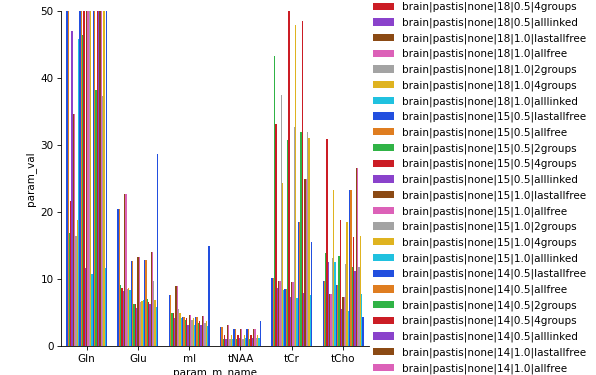

(0.0, 50.0)

In [24]:
df = df_brain.loc[(df_brain.index.get_level_values("strategy_reco") == "brain")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"])) &
                 (df["strategy_fit_sequence"] == "none")]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="bar", ci=None,
                palette = "bright",
                data=this_df)

plt.ylim([0, 50])

* LCModel gives higher CRB for Glu, mI and NAA
* PASTIS gives higher CRB for Cr and Cho, depending on the strategy

### Fit strategies vs Metabolite ratios

<IPython.core.display.Javascript object>


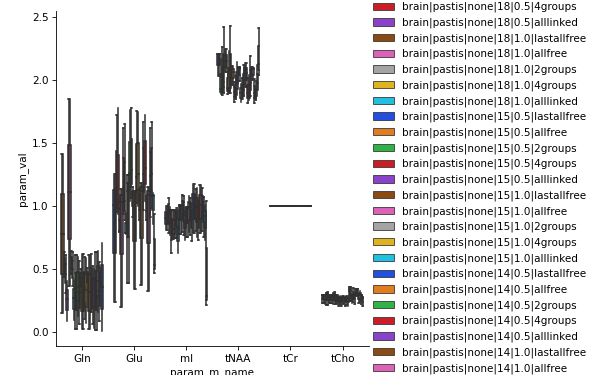

In [25]:
# keep only pastis/sLASER and lcmodel
df = df_brain.loc[(df_brain.index.get_level_values("strategy_reco") == "brain")]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"])) &
                 (df["strategy_fit_sequence"] == "none")]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="box", 
                palette = "bright",
                data=this_df)


* Big differences (significant ?) for tNAA, mI and Glu... Will need to check that with t-tests
* On brain data, LCModel shows higher variability for some metabolite ratios :)

### Fit strategies vs Metabolites ratios SDs

<IPython.core.display.Javascript object>


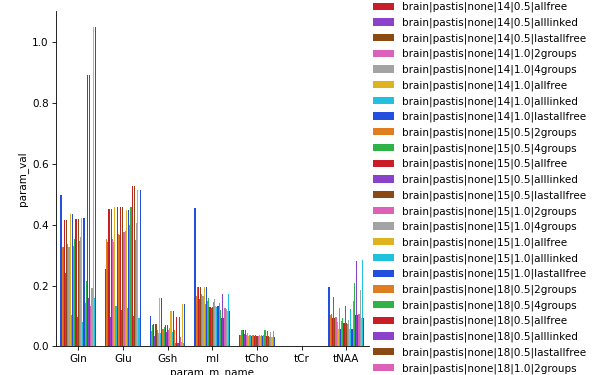

In [26]:
# keep only pastis/sLASER and lcmodel
df = df_brain.loc[(df_brain.index.get_level_values("strategy_reco") == "brain")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI", "Gsh"])) &
                 (df["strategy_fit_sequence"] == "none")]

this_df_grp = this_df.groupby(["strategy_full", "param_m_name"]).std()

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="bar",
                palette = "bright", 
                data=this_df_grp.reset_index())

* Clearly higher SDs with LCModel except for:
    * Cho, Glu and Gln
* Very strange considering LCModel's Glu/Gln simulations are approximate due to the use of the PRESS sequence and an approximate TE...

## Spinal cord data

### Fit strategies vs R2/FQN

In [27]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_fittool_name"] == "pastis")]

df.groupby(["strategy_fittool_name", 
            "strategy_fit_sequence", 
            "strategy_fit_metabolites_len",
            "strategy_fit_constraint_shrink", 
            "strategy_fit_constraint_type"])[["fit_ws_optim_results_fqn", 
                           "fit_ws_optim_results_rsq_f", 
                           "fit_ws_optim_results_rsq_t"] ].mean().sort_values("fit_ws_optim_results_fqn")

fit_ws_optim_results_fqn  \
strategy_fittool_name strategy_fit_sequence strategy_fit_metabolites_len strategy_fit_constraint_shrink strategy_fit_constraint_type                             
pastis                none                  18                           1.0                            lastallfree                                   3.163302   
                                                                                                        allfree                                       3.163302   
                                                                                                        2groups                                       3.224095   
                                                                         0.5                            lastallfree                                   3.224790   
                                                                                                        allfree                                       3.224790   
                                                                         1.0                            alllinked                                     3.227405   
                                                                         0.5                            2groups                                       3.231004   
                                            15                           1.0                            lastallfree                                   3.234769   
                                                                                                        allfree                                       3.234769   
                                            14                           1.0                            allfree                                       3.246266   
                                                                                                        lastallfree                                   3.246266   
                                            18                           1.0                            4groups                                       3.246650   
                                                                         0.5                            4groups                                       3.250527   
                                            14                           1.0                            alllinked                                     3.275266   
                                            18                           0.5                            alllinked                                     3.285909   
                                            15                           0.5                            lastallfree                                   3.286186   
                                                                                                        allfree                                       3.286186   
                                            14                           0.5                            lastallfree                                   3.291695   
                                                                                                        allfree                                       3.291695   
                                            15                           1.0                            2groups                                       3.304674   
                                            14                           1.0                            2groups                                       3.310788   
                                                                                                        4groups                                       3.312775   
                                            15                           0.5                            2groups                                       3.317542   
                                                                         1.0        

A little lower FQN with sLASER ("none"). Not as clear as on brain...

### Fit strategies vs CRBs

<IPython.core.display.Javascript object>


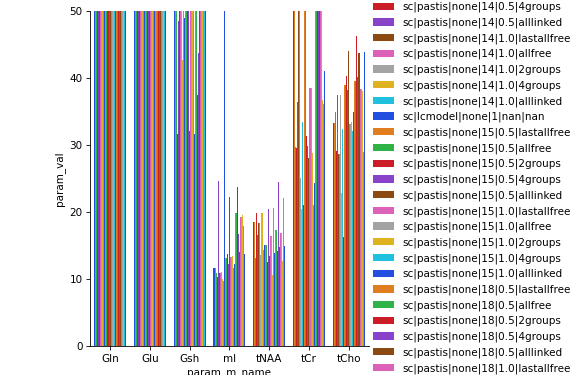

(0.0, 50.0)

In [28]:
# keep only pastis/sLASER and lcmodel
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_fit_sequence"] == "none")]

# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI", "Gsh"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="bar", ci=None,
                palette = "bright", 
                data=this_df)

plt.ylim([0, 50])

* Seems that the best PASTIS strategy consists in NOT applying any constraint shrinking! (=1)
* Depends on metabolites... Need to check after filtering

### Fit strategies vs Metabolite ratios

<IPython.core.display.Javascript object>


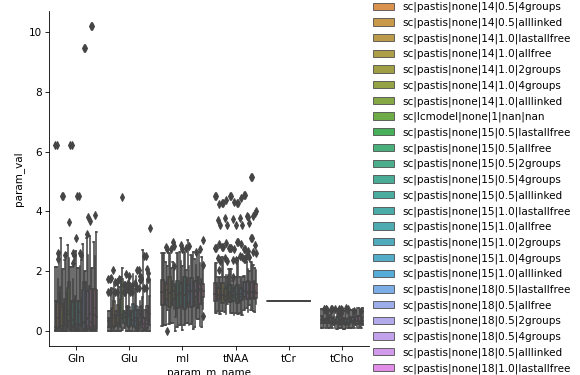

In [29]:
# keep only pastis/sLASER and lcmodel
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_fit_sequence"] == "none")]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "Glu", "Gln", "mI"]))]

g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="box", 
                data=this_df)

* Variability is stronger for some metabolites with LCModel
* Need to check after dataset filtering

# Data quality (SNR & LW)
## Annotated SNR vs. LW

In [30]:
def add_labels(key_x, key_y, key_label, this_df_labels, ax, font_size=10, x_offset=0.0, y_offset=0.0):
    for i, pt in this_df_labels.iterrows():
        ax.text(pt[key_x] + .02 + x_offset, pt[key_y] + y_offset, str(pt[key_label]), fontsize=font_size)

<IPython.core.display.Javascript object>


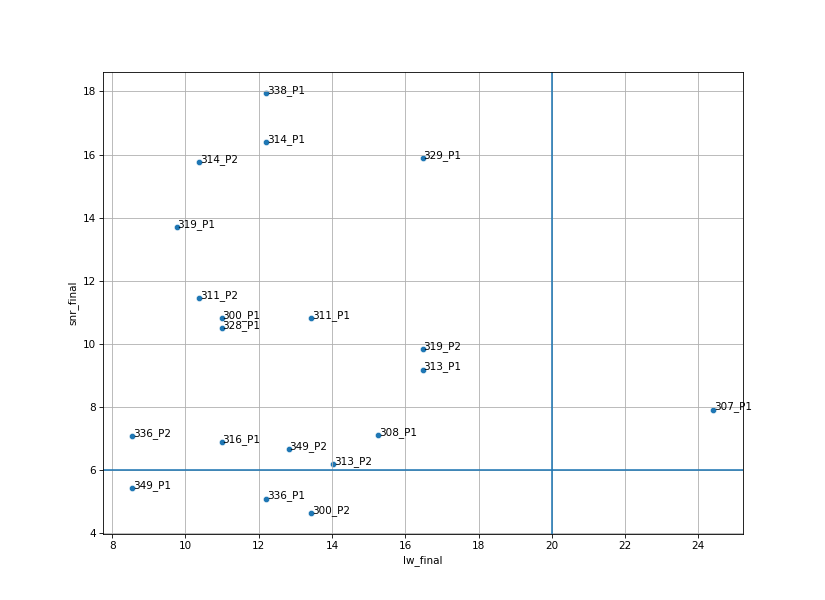

In [31]:
threshold_snr_test = 6
threshold_lw_test = 20

df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

this_df = df.drop_duplicates("patient_pass_id")

plt.figure()
g = sns.scatterplot(x="lw_final", y="snr_final", data=this_df)
add_labels("lw_final", "snr_final", "patient_pass_id", this_df, plt.gca())
plt.axvline(threshold_lw_test)
plt.axhline(threshold_snr_test)
plt.grid('on')

## Annotated R2 & FQN

<IPython.core.display.Javascript object>


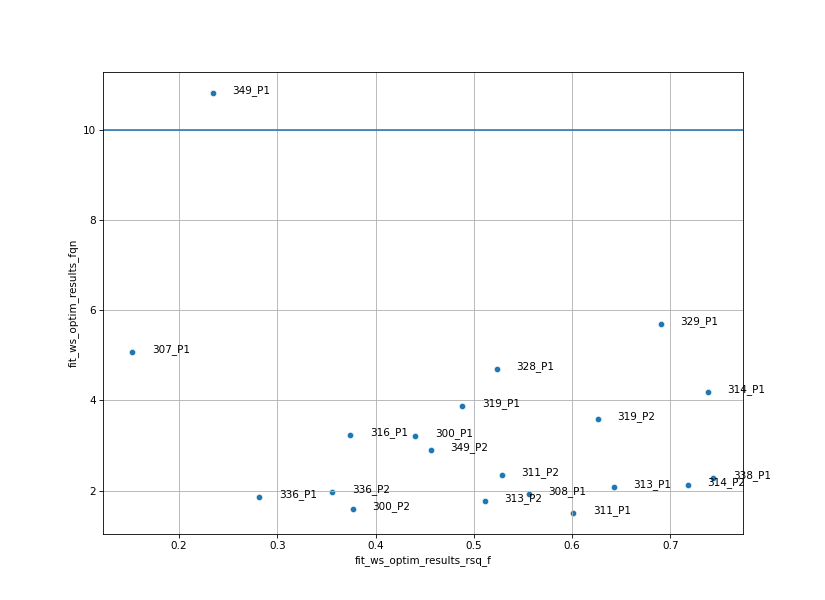

In [32]:
threshold_fqn_test = 10

df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

this_df = df.drop_duplicates("patient_pass_id")

plt.figure()
g = sns.scatterplot(x="fit_ws_optim_results_rsq_f", y="fit_ws_optim_results_fqn", data=this_df)
add_labels("fit_ws_optim_results_rsq_f", "fit_ws_optim_results_fqn", "patient_pass_id", this_df, plt.gca())
plt.axhline(threshold_fqn_test)
plt.grid('on')


# Quantification results
## Annotated metabolite ratios

<IPython.core.display.Javascript object>


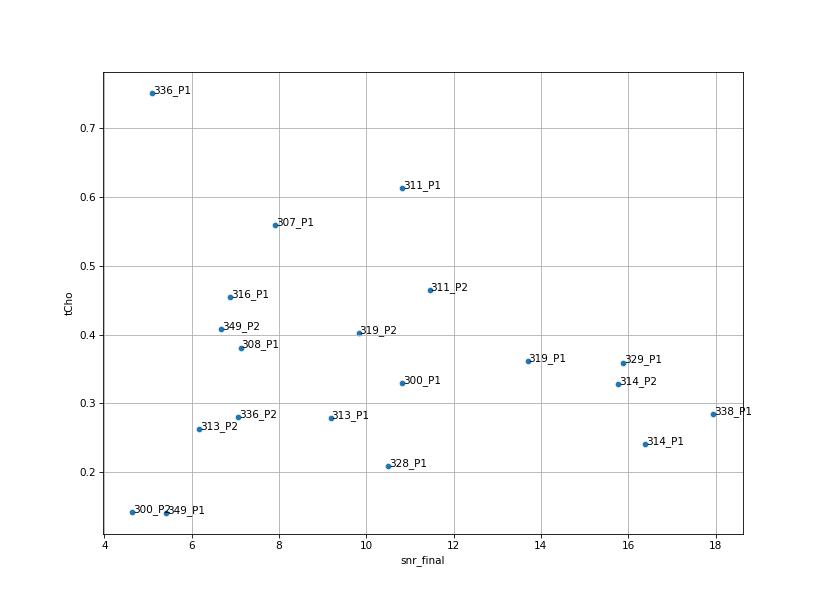

<IPython.core.display.Javascript object>


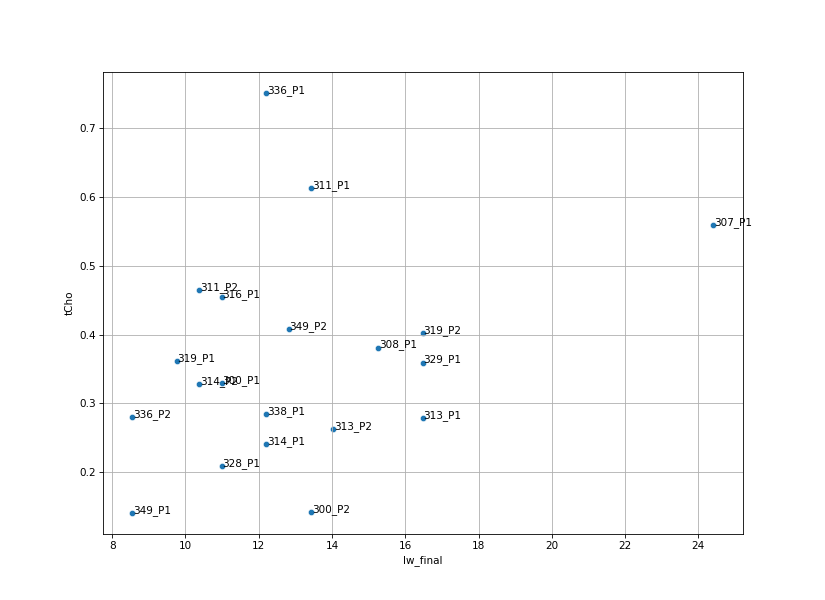

<IPython.core.display.Javascript object>


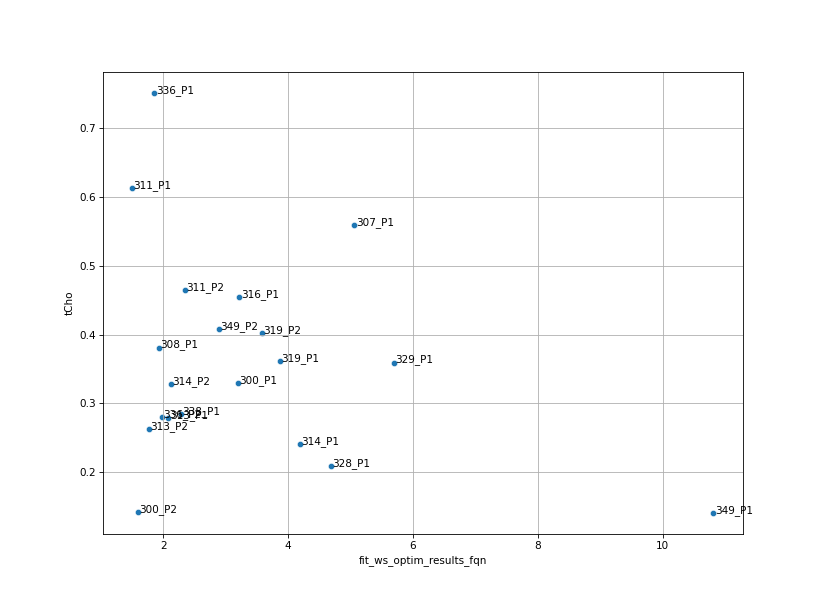

<IPython.core.display.Javascript object>


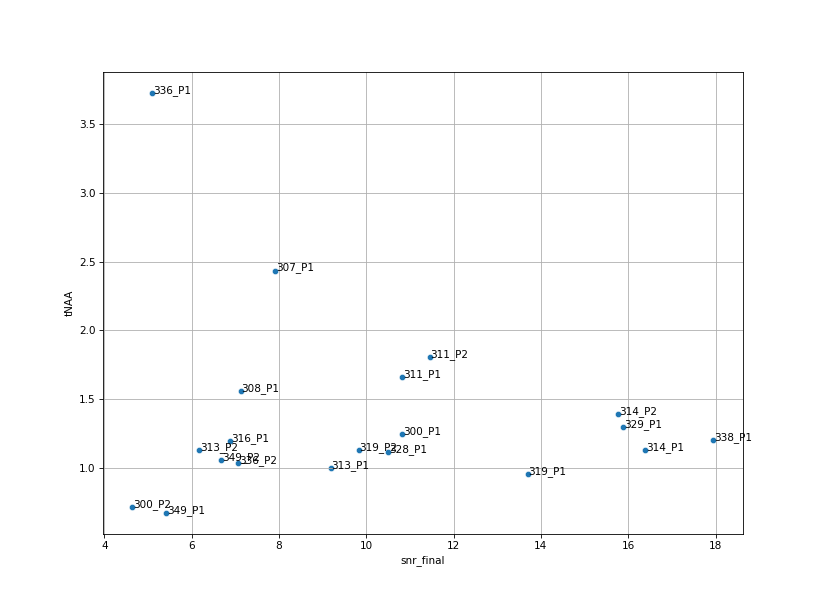

<IPython.core.display.Javascript object>


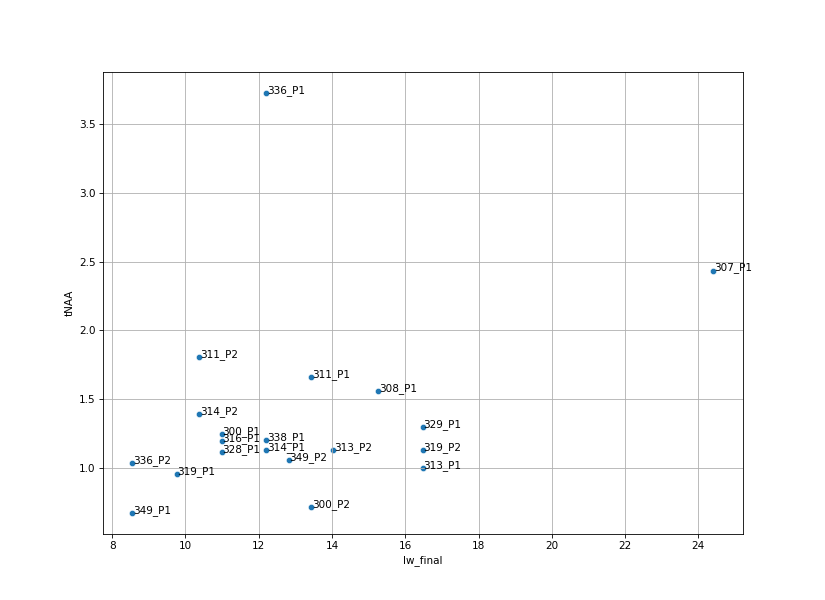

<IPython.core.display.Javascript object>


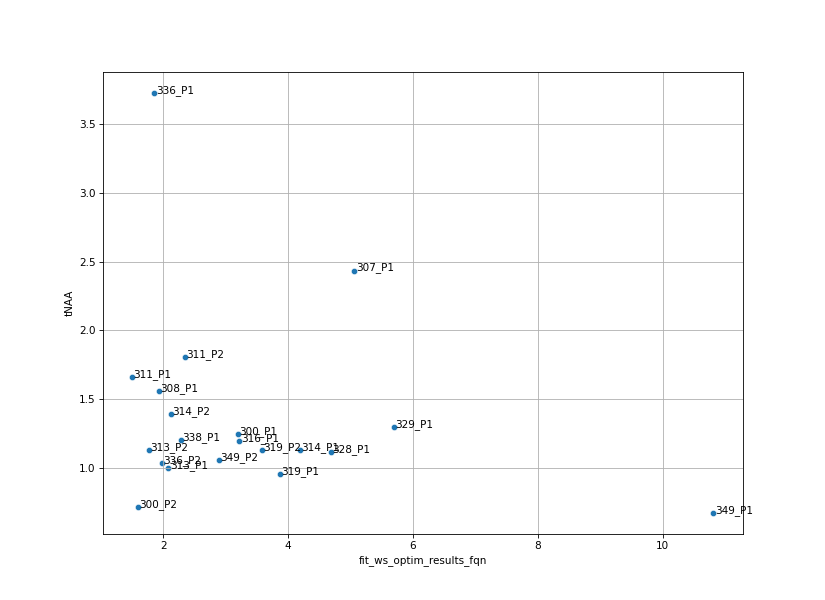

<IPython.core.display.Javascript object>


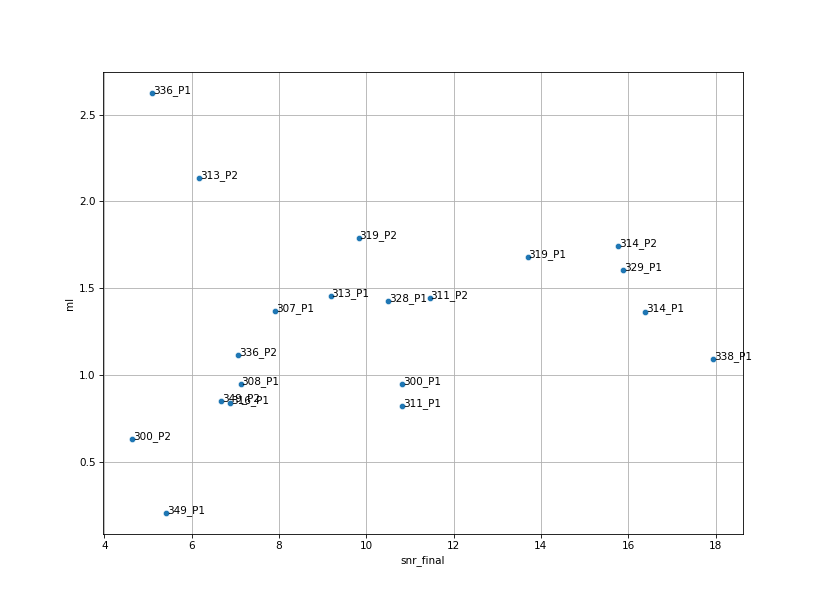

<IPython.core.display.Javascript object>


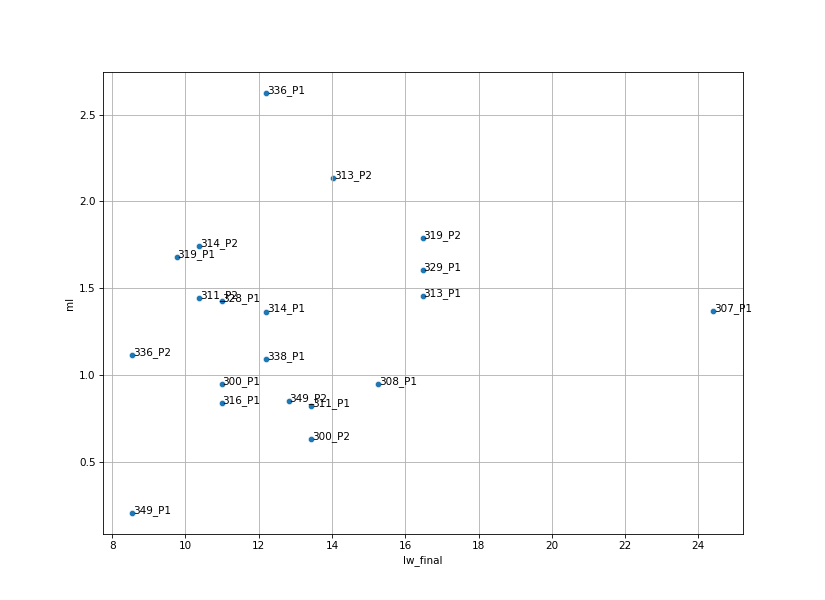

<IPython.core.display.Javascript object>


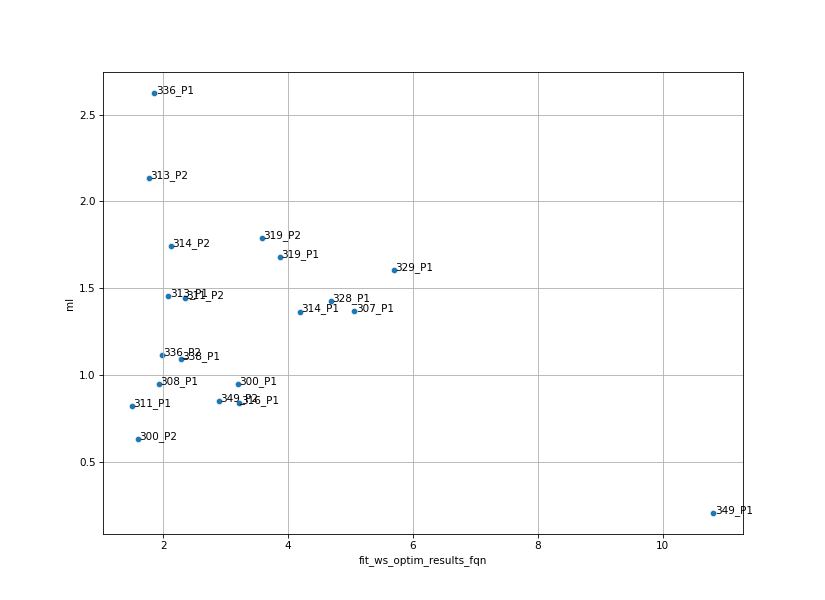

<IPython.core.display.Javascript object>


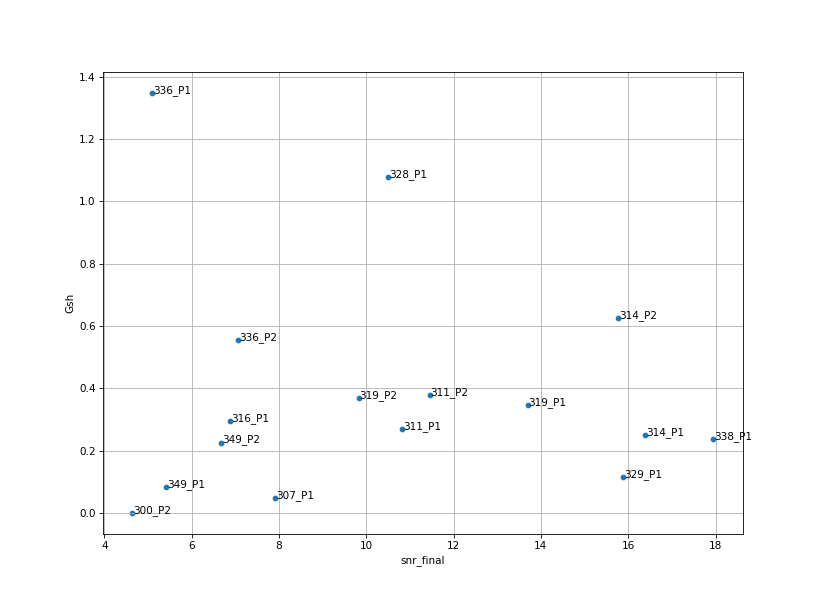

<IPython.core.display.Javascript object>


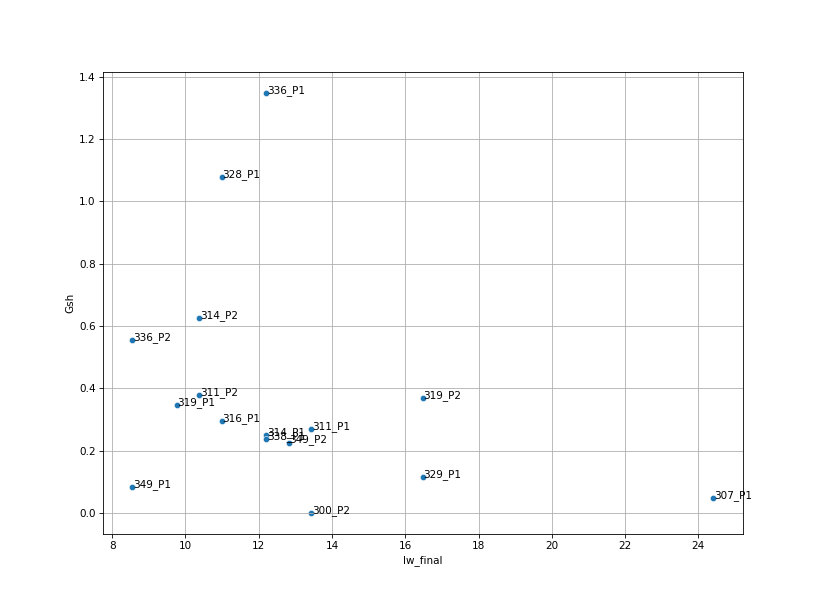

<IPython.core.display.Javascript object>


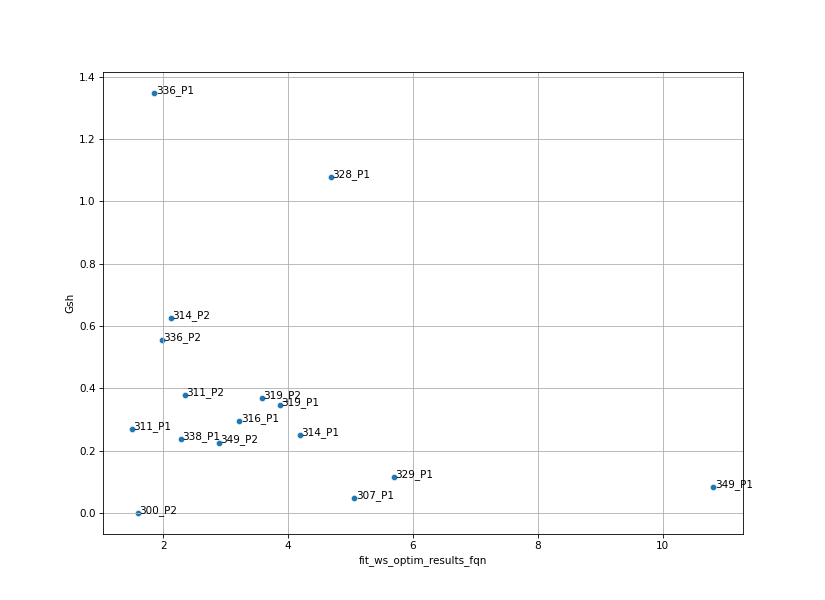

<IPython.core.display.Javascript object>


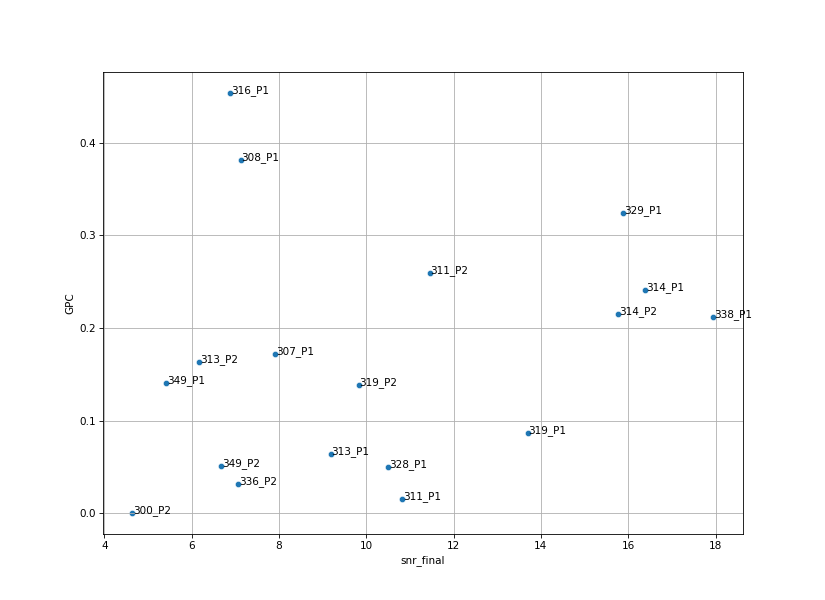

<IPython.core.display.Javascript object>


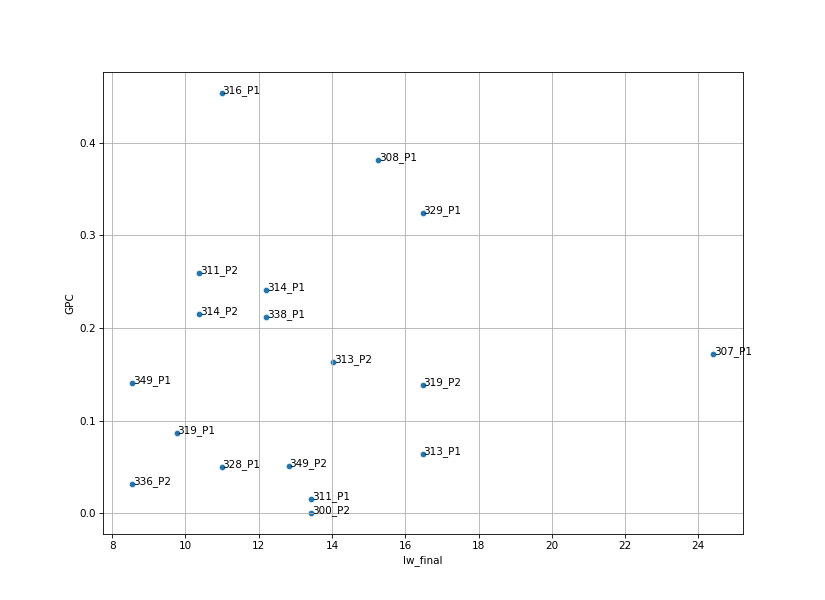

<IPython.core.display.Javascript object>


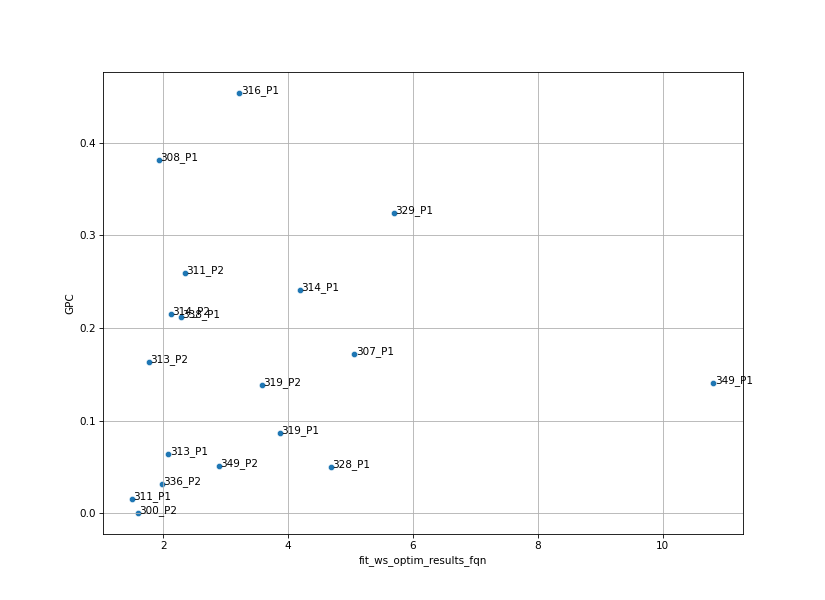

<IPython.core.display.Javascript object>


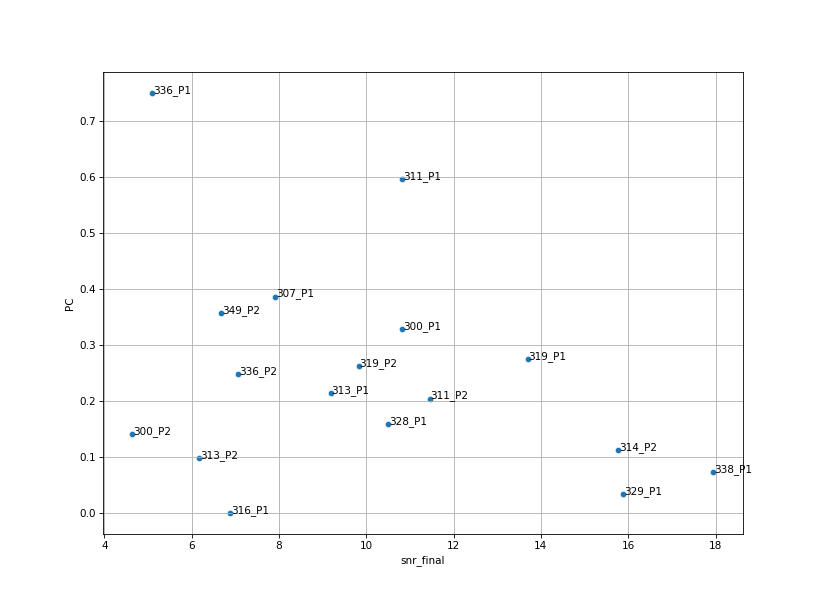

<IPython.core.display.Javascript object>


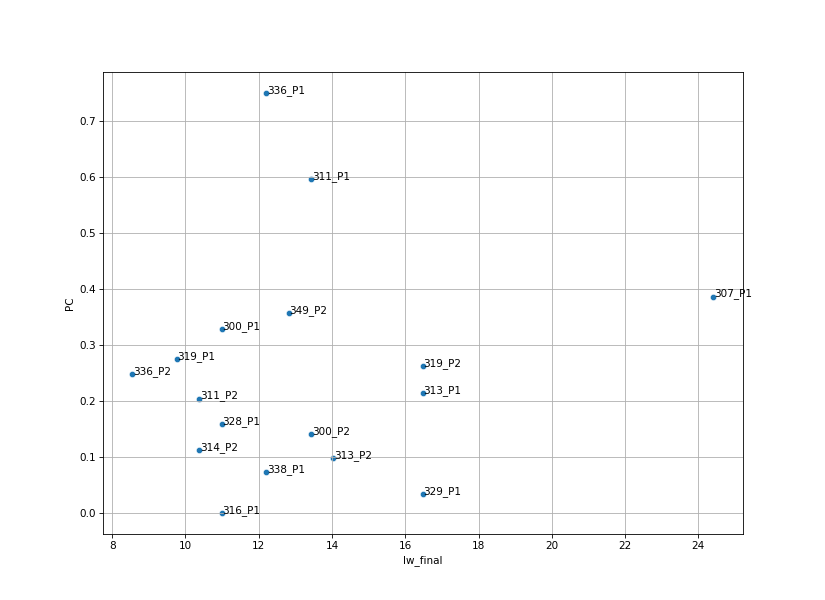

<IPython.core.display.Javascript object>


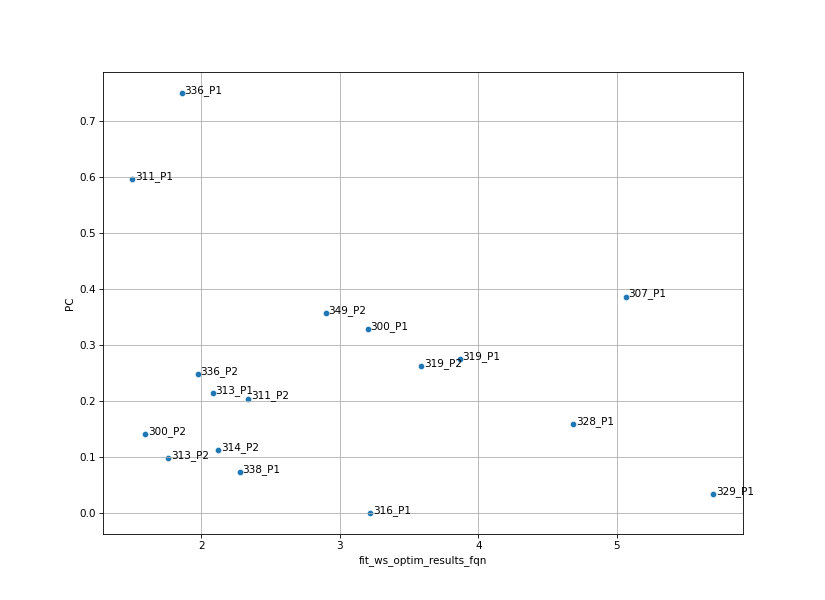

<IPython.core.display.Javascript object>


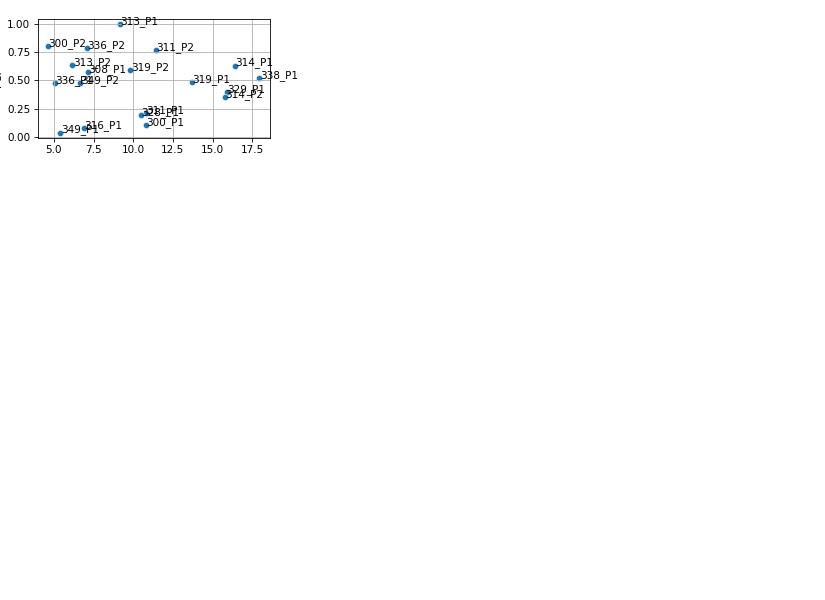

<IPython.core.display.Javascript object>


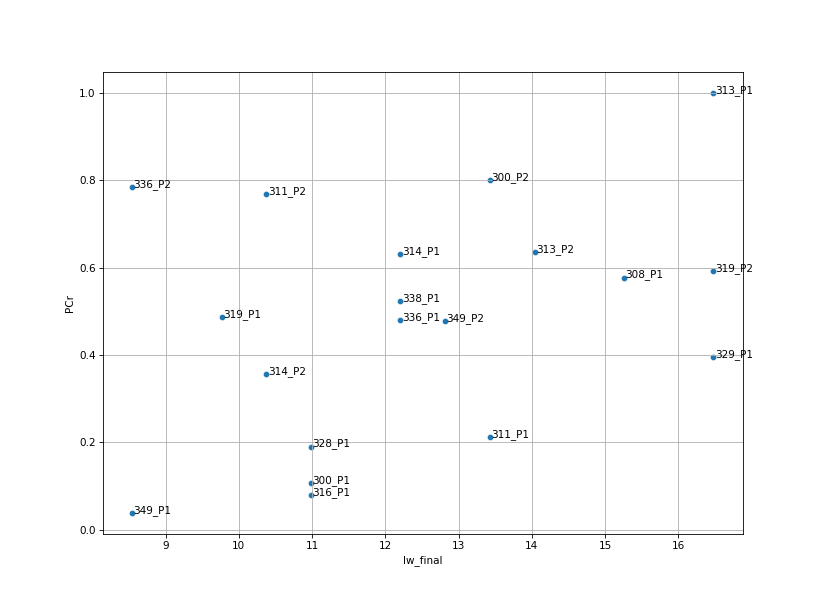

<IPython.core.display.Javascript object>


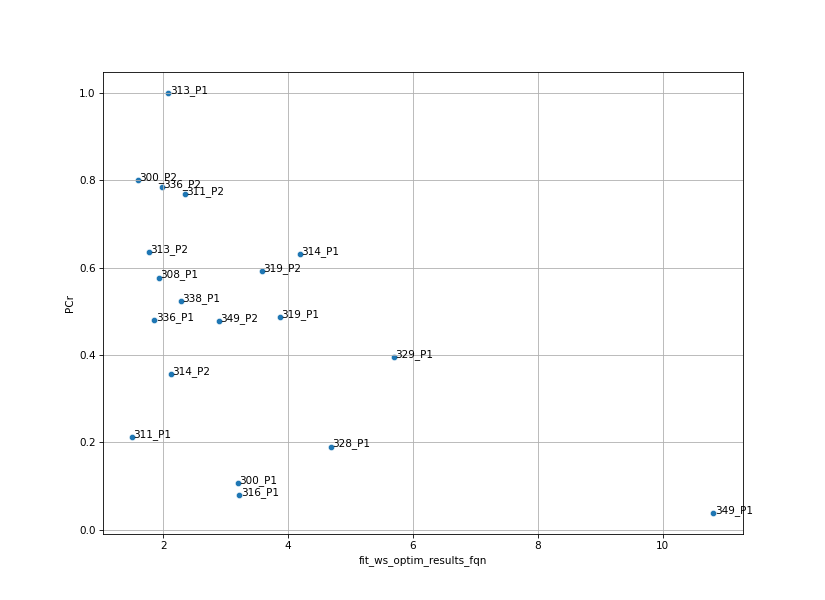

<IPython.core.display.Javascript object>


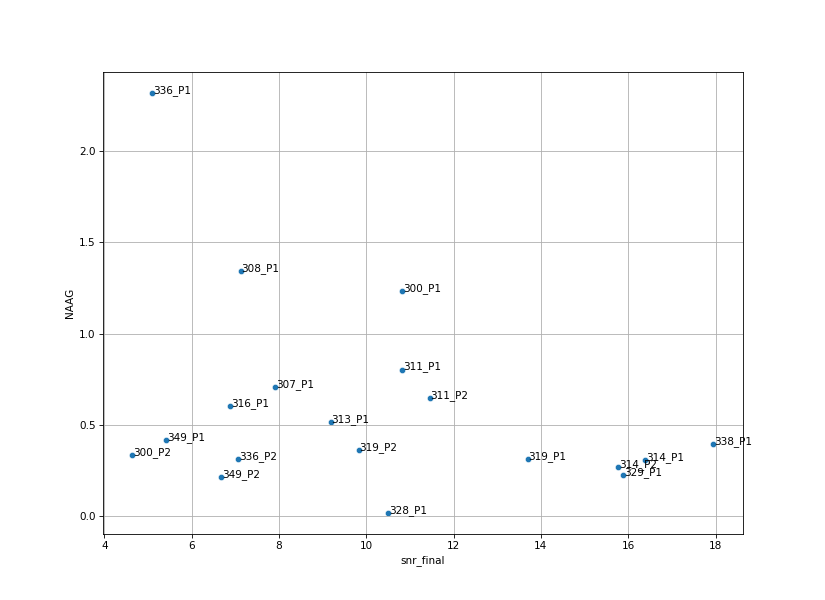

<IPython.core.display.Javascript object>


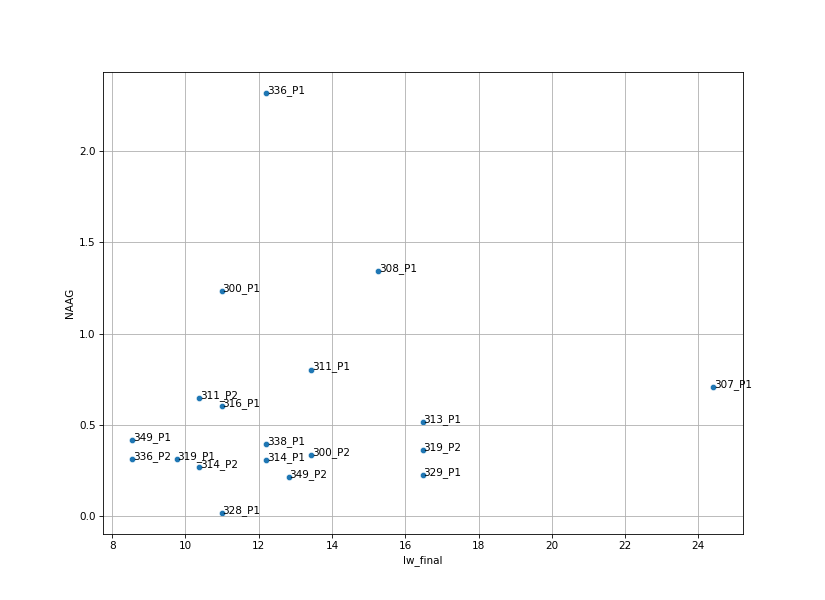

<IPython.core.display.Javascript object>


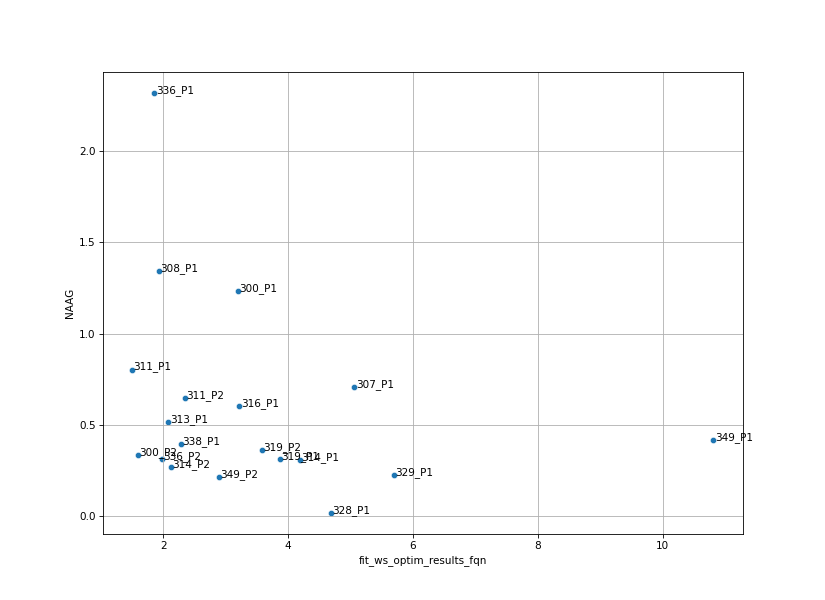

<IPython.core.display.Javascript object>


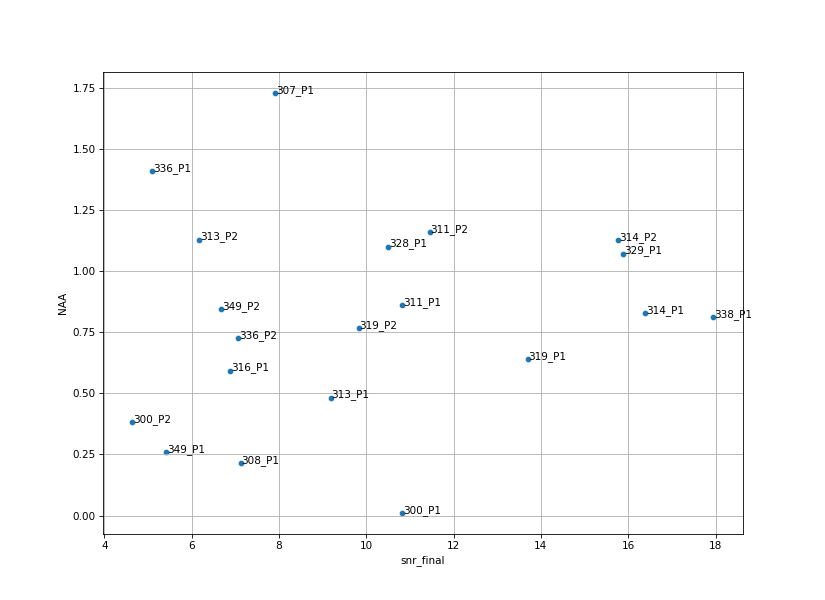

<IPython.core.display.Javascript object>


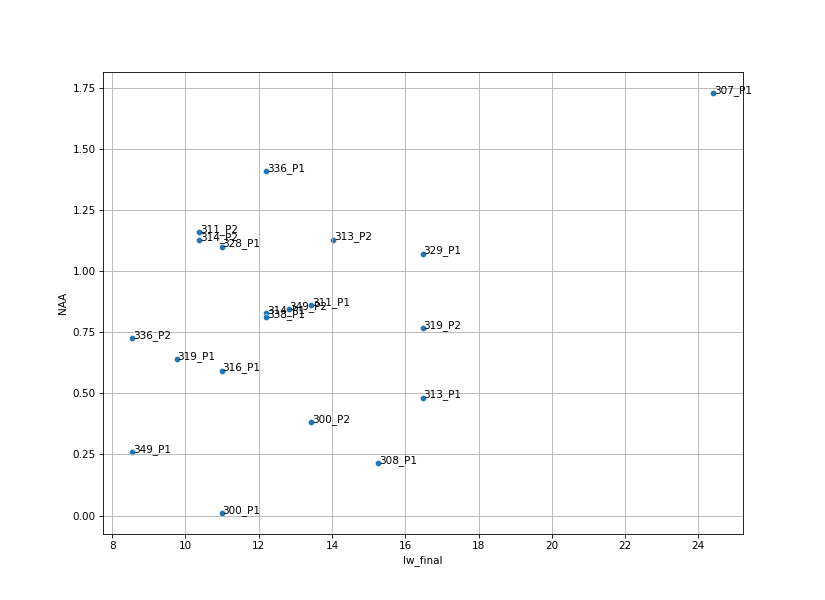

<IPython.core.display.Javascript object>


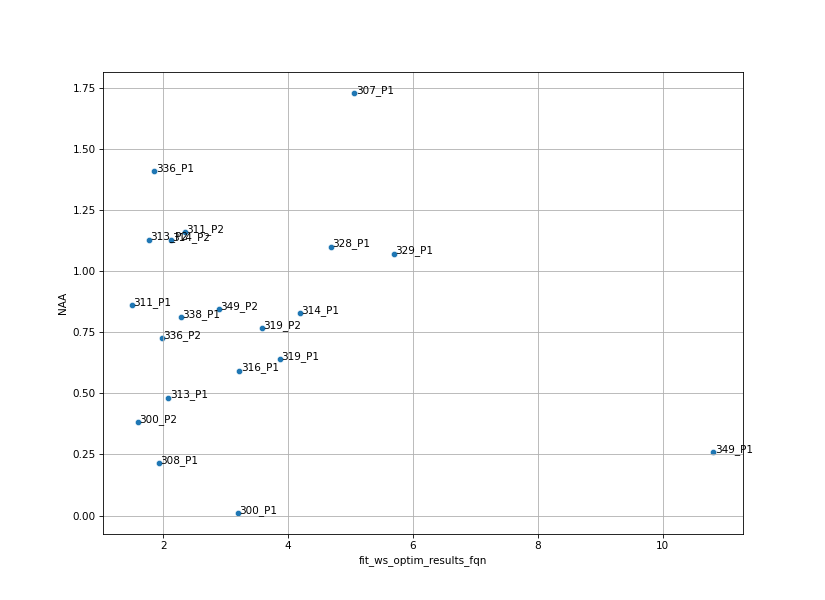

In [33]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

# watch ratios per metabolite
for m in ["tCho", "tNAA", "mI", "Gsh", "GPC", "PC", "PCr", "NAAG", "NAA"]:
    this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] ==m)]

    plt.figure()
    g = sns.scatterplot(x="snr_final", y="param_val", data=this_df)
    add_labels("snr_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="lw_final", y="param_val", data=this_df)
    add_labels("lw_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="fit_ws_optim_results_fqn", y="param_val", data=this_df)
    add_labels("fit_ws_optim_results_fqn", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

* tCho: 307_P1, 308_P1, 300_P2, 336_P1, 349_P1 are far
* tNAA: 307_P1, 308_P1, 336_P1, 349_P1 are far
* mI: 307_P1, 308_P1, 336_P1, 349_P1 are far

Good news is that...
* 307_P1 has a LW of 24Hz
* 349_P1 has a SNR of 5 and a FQN above 10
* 336_P1 has a low SNR of 5.1
* 300_P2 ha a low SNR of 4.3

Need to check manually 308_P1

Thresholding at SNR=6, LW=20Hz and FQN at 10 should help

## Annotated CRBs

<IPython.core.display.Javascript object>


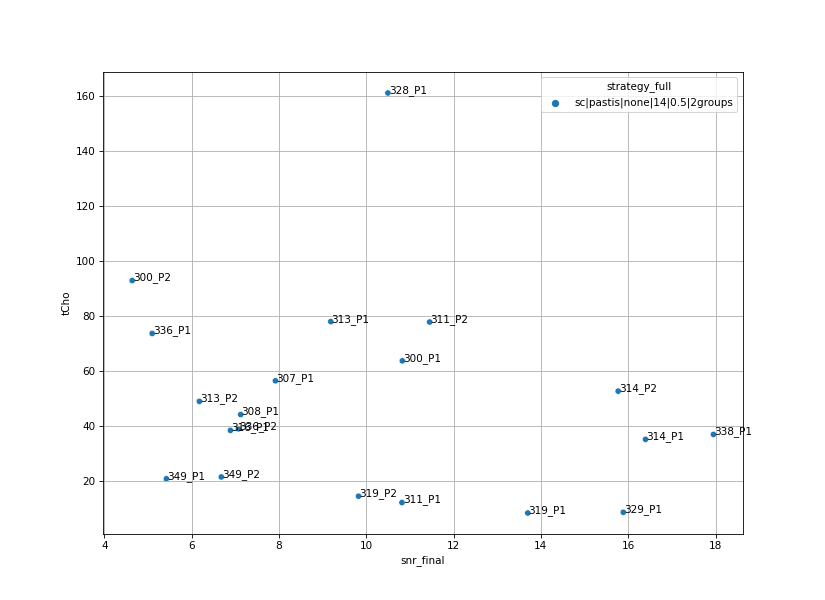

<IPython.core.display.Javascript object>


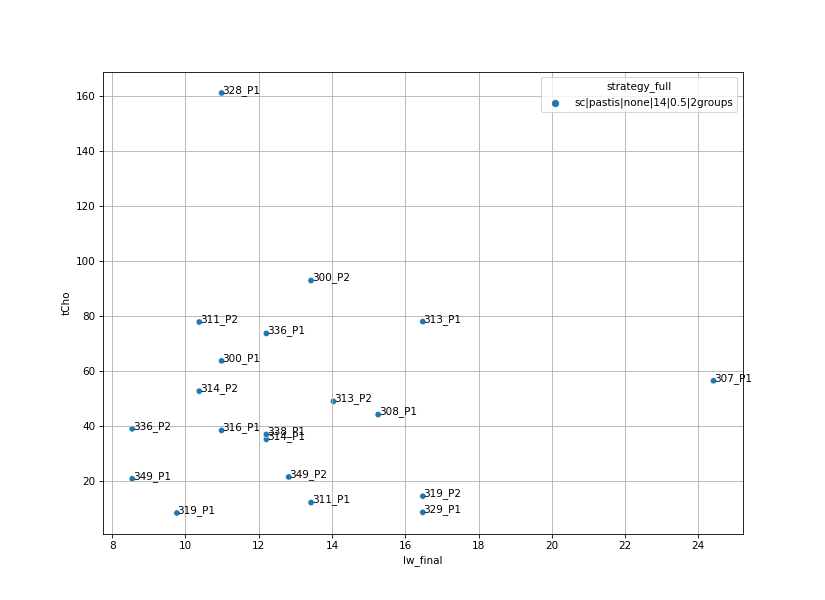

<IPython.core.display.Javascript object>


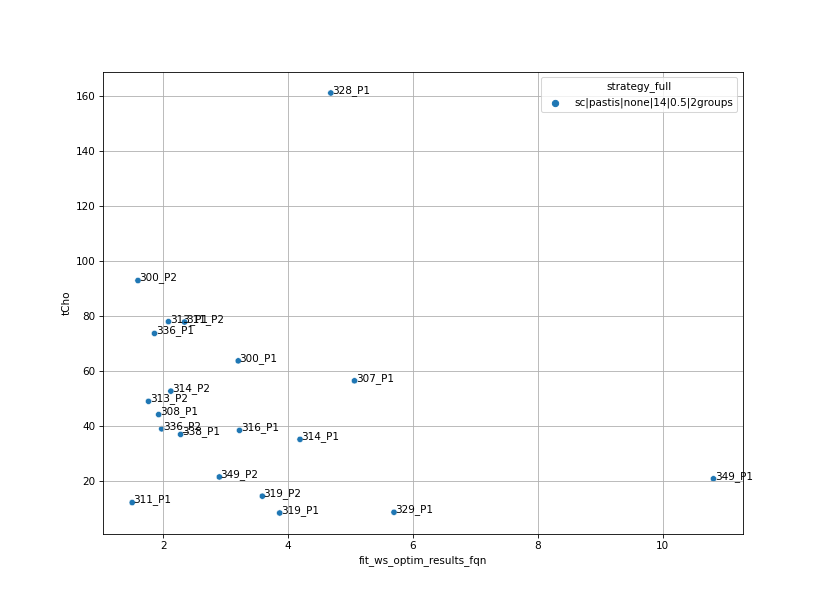

<IPython.core.display.Javascript object>


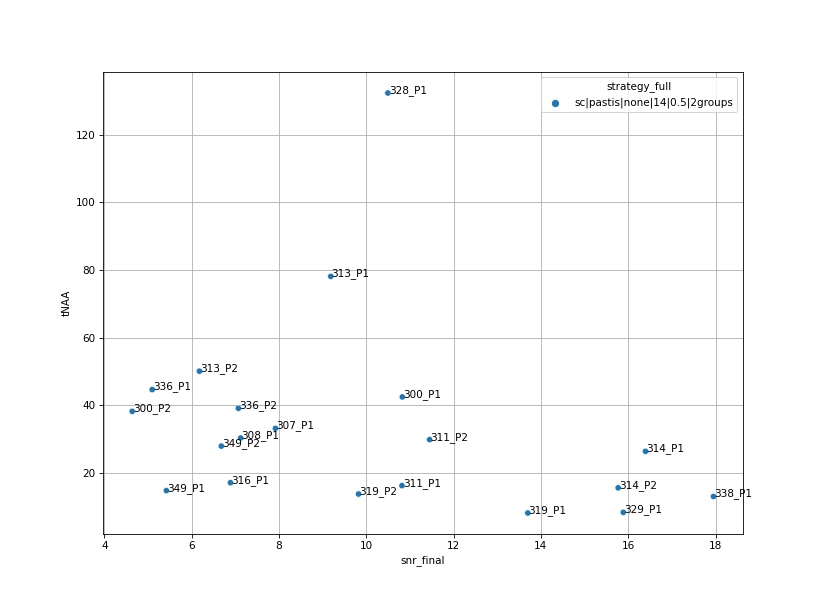

<IPython.core.display.Javascript object>


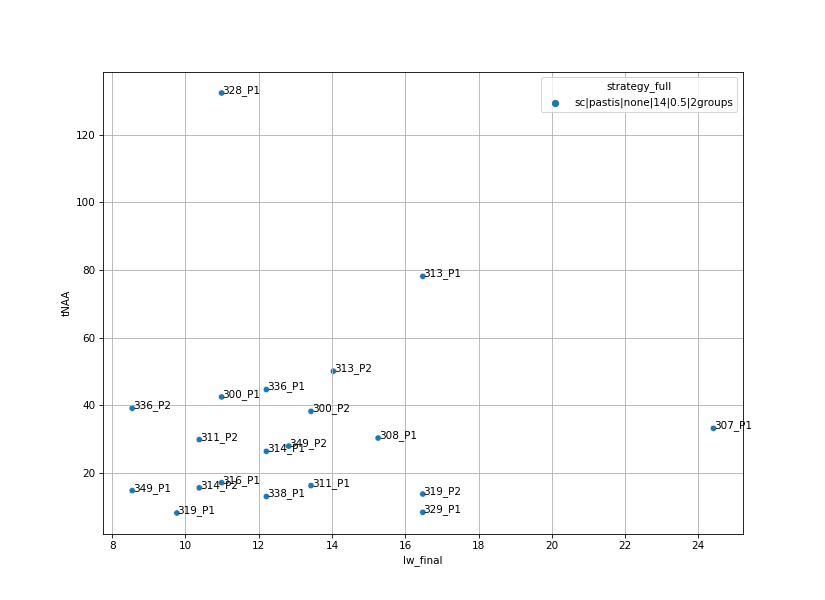

<IPython.core.display.Javascript object>


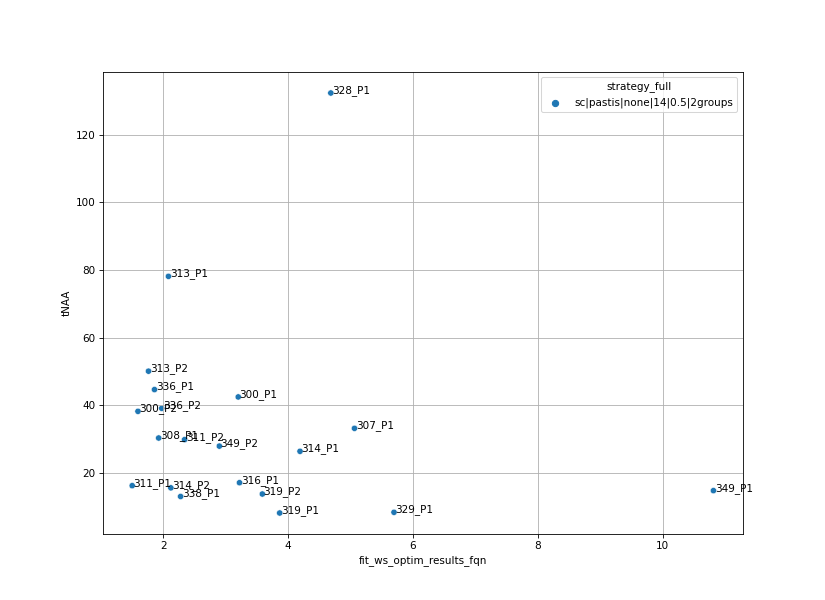

<IPython.core.display.Javascript object>


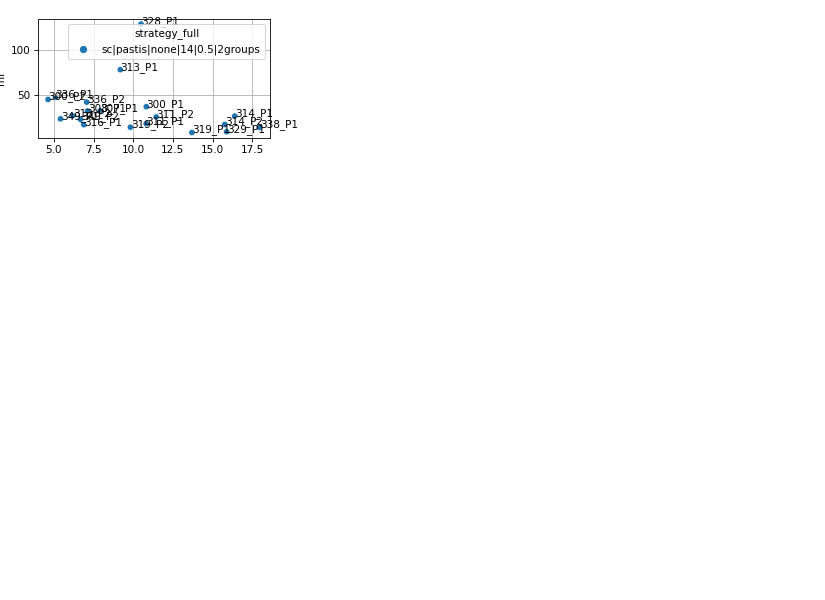

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


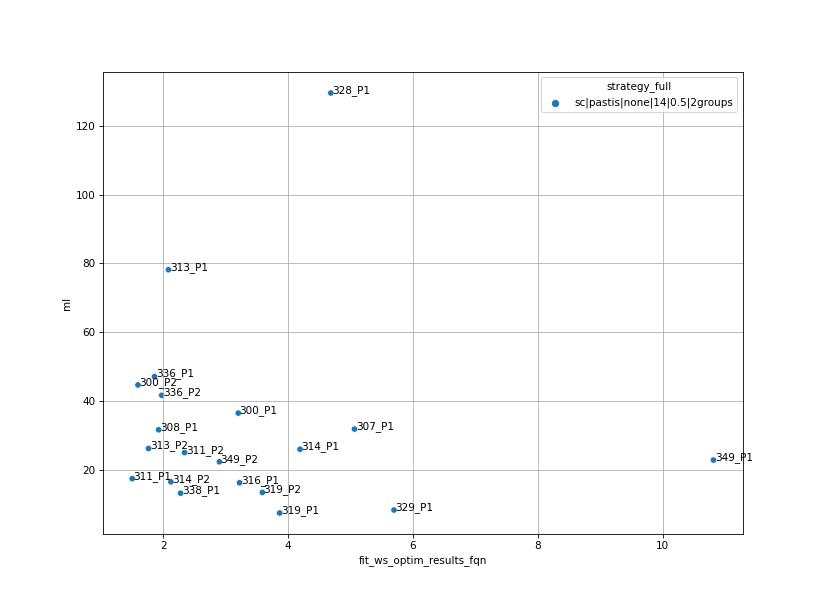

<IPython.core.display.Javascript object>


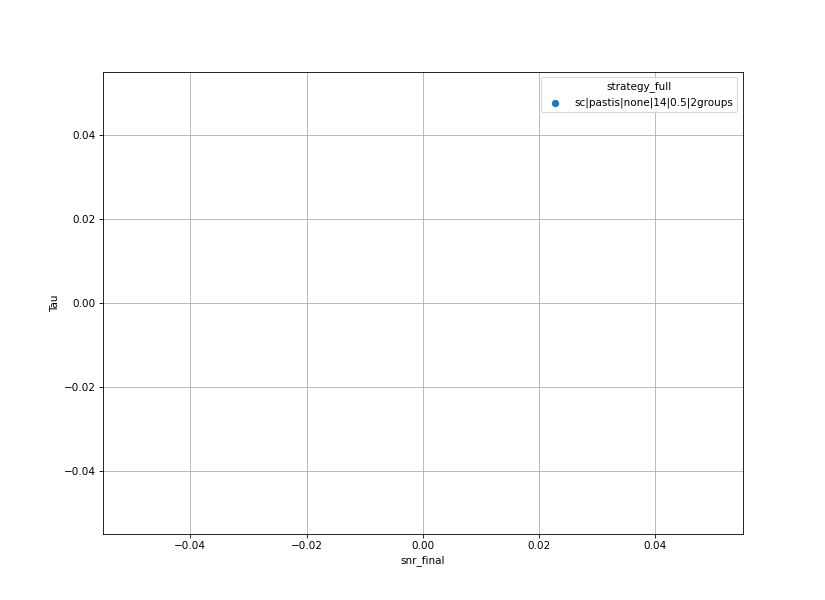

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


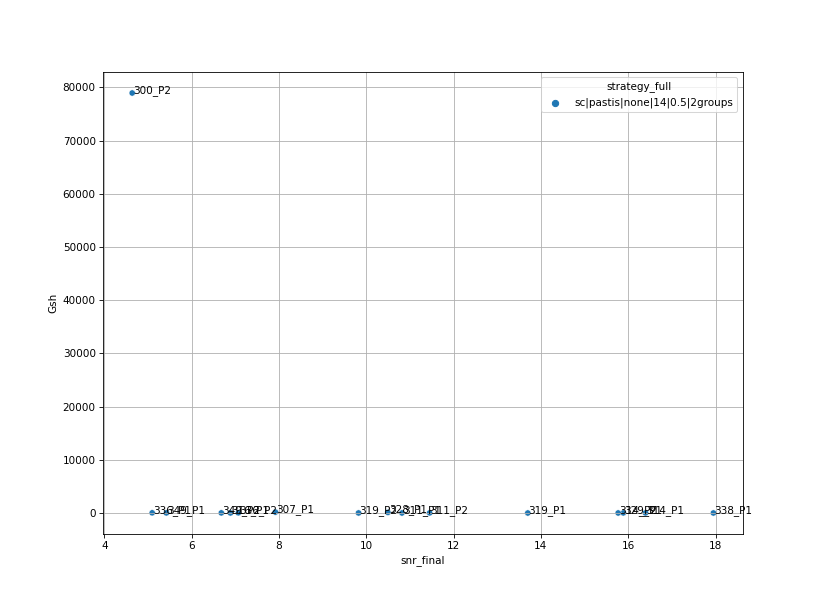

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


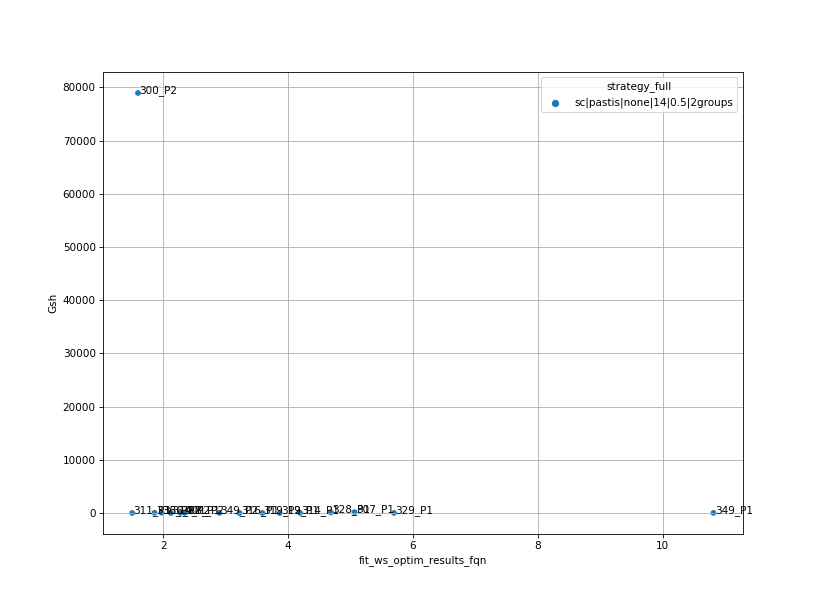

In [34]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

# watch ratios per metabolite
for m in ["tCho", "tNAA", "mI", "Tau", "Gsh"]:
    this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "err_prct") &  
                     (df["param_m_name"] ==m)]

    plt.figure()
    g = sns.scatterplot(x="snr_final", y="param_val", hue="strategy_full", data=this_df)
    add_labels("snr_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="lw_final", y="param_val", hue="strategy_full", data=this_df)
    add_labels("lw_final", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

    plt.figure()
    g = sns.scatterplot(x="fit_ws_optim_results_fqn", y="param_val", hue="strategy_full", data=this_df)
    add_labels("fit_ws_optim_results_fqn", "param_val", "patient_pass_id", this_df, plt.gca())
    plt.grid('on')
    plt.ylabel(m)

Corrupted CRBs :
* 300_P2, 313_P2 for (Gsh)
300_P2 should be filtered out anyway

# Data quality filtering by SNR & LW & FQN
and take care of orphan patients, etc.

In [35]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 10

ref_strategy_full_sc = "sc|pastis|none|14|0.5|2groups"
ref_strategy_full_brain = "brain|pastis|none|14|0.5|2groups"

def filter_by_SNR_LW_FQN(this_df, 
                         this_threshold_snr_final, 
                         this_threshold_lw_final, 
                         this_threshold_fqn_final,
                         this_ref_strategy_full):

    # add a column
    this_df["included"] = False
    this_df["pass_after_filter"] = this_df["pass"]
    this_df["patient_pass_id_after_filter"] = this_df["patient_pass_id"]
    this_df["patient_pass_id_pretty_after_filter"] = this_df["patient_pass_id_pretty"]

    # keep only the reference reco_template, fit stategies, etc.
    this_df_ref = this_df.loc[(this_df["strategy_full"] == this_ref_strategy_full)]

    # apply SNR/LW/FQN filter
    this_df_ref_filtered = this_df_ref.loc[(this_df_ref["snr_final"] > this_threshold_snr_final) &
                                   (this_df_ref["lw_final"] < this_threshold_lw_final) &
                                   (this_df_ref["fit_ws_optim_results_fqn"] < this_threshold_fqn_final)]

    # remember the data hash indexes to keep
    data_hash_2keep_list = this_df_ref_filtered.index.get_level_values("data_hash").unique().tolist()

    # find pass 1 patients
    this_df_ref_filtered_p1 = this_df_ref_filtered.loc[(this_df_ref_filtered["pass"] == 1)]
    # remember them
    patient_id_p1_list = this_df_ref_filtered_p1["patient_id"].unique().tolist()

    # find pass 2 patients which are not previously found pass 1 list
    this_df_ref_filtered_p2_orphan = this_df_ref_filtered.loc[ (this_df_ref_filtered["pass"] == 2) &
                            ~this_df_ref_filtered["patient_id"].isin(patient_id_p1_list) ]

    # remember their ids
    orphan_patient_id_list = list(this_df_ref_filtered_p2_orphan["patient_id"].unique())
    print("found %d orphan P2 patients. Fixing them..." % len(orphan_patient_id_list))
    print(orphan_patient_id_list)

    # apply filter to whole df
    this_df.loc[this_df.index.get_level_values("data_hash").isin(data_hash_2keep_list), "included"] = True

    # transform the orphan pass 2 patients into pass 1 and rename them
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "pass_after_filter"] = 1
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "patient_pass_id_after_filter"] = this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list)]["patient_pass_id"].str.replace("P2", "P1")
    this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list), "patient_pass_id_pretty_after_filter"] = this_df.loc[this_df["patient_id"].isin(orphan_patient_id_list)]["patient_pass_id_pretty"].str.replace("P2", "P1")

    # print stuff
    nP1_orig = len(this_df.loc[(this_df["pass"] == 1)].drop_duplicates("patient_id"))
    nP2_orig = len(this_df.loc[(this_df["pass"] == 2)].drop_duplicates("patient_id"))
    nP1_after_filter = len(this_df.loc[this_df["included"] & (this_df["pass_after_filter"] == 1)].drop_duplicates("patient_id"))
    nP2_after_filter = len(this_df.loc[this_df["included"] & (this_df["pass_after_filter"] == 2)].drop_duplicates("patient_id"))
    prct_reject = nP1_after_filter / nP1_orig * 100
    print("n (P1) = %d / %d (%.2f%% included)" % (nP1_after_filter, nP1_orig, prct_reject))
    print("n (P2) = %d / %d" % (nP2_after_filter, nP2_orig))

    return(this_df)

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_strategy_full_sc)

df_brain = filter_by_SNR_LW_FQN(df_brain, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_strategy_full_brain)


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 4 / 7
found 0 orphan P2 patients. Fixing them...
[]
n (P1) = 2 / 3 (66.67% included)
n (P2) = 0 / 0


# [FIG] SNR & LW & FQN scatter plot

In [36]:
df = df_sc_all_reco.loc[(df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")].drop_duplicates("patient_pass_id")

print("There is %d datasets included" % len(df.loc[df["included"]]))
print("There is %d datasets excluded" % len(df.loc[~df["included"]]))
print("Datasets rejected (%%) = %.2f" % (len(df.loc[~df["included"]]) / len(df) * 100))

print("--- All datasets ---")
print("Mean SNR = %.2f (%.2f)" % (df["snr_final"].mean(),
                                    df["snr_final"].std()))
print("Range SNR = [%.2f - %.2f]" % (df["snr_final"].min(),
                                    df["snr_final"].max()))
print("Mean FWHM = %.2f ppm (%.2f)" % (df["lw_final"].mean() / (7 * 42.576),
                                        df["lw_final"].std() / (7 * 42.576)))
print("Mean FWHM = %.2f Hz (%.2f)" % (df["lw_final"].mean(),
                                        df["lw_final"].std()))
print("Mean FQN = %.2f (%.2f)" % (df["fit_ws_optim_results_fqn"].mean(), 
                                    df["fit_ws_optim_results_fqn"].std()))

print("--- Included datasets ---")
print("Mean SNR = %.2f (%.2f)" % (df.loc[df["included"]]["snr_final"].mean(),
                                    df.loc[df["included"]]["snr_final"].std()))
print("Range SNR = [%.2f - %.2f]" % (df.loc[df["included"]]["snr_final"].min(),
                                    df.loc[df["included"]]["snr_final"].max()))
print("Mean FWHM = %.2f ppm (%.2f)" % (df.loc[df["included"]]["lw_final"].mean() / (7 * 42.576),
                                        df.loc[df["included"]]["lw_final"].std() / (7 * 42.576)))
print("Mean FWHM = %.2f Hz (%.2f)" % (df.loc[df["included"]]["lw_final"].mean(),
                                        df.loc[df["included"]]["lw_final"].std()))
print("Mean FQN = %.2f (%.2f)" % (df.loc[df["included"]]["fit_ws_optim_results_fqn"].mean(), 
                                    df.loc[df["included"]]["fit_ws_optim_results_fqn"].std()))


There is 16 datasets included
There is 4 datasets excluded
Datasets rejected (%) = 20.00
--- All datasets ---
Mean SNR = 9.96 (4.11)
Range SNR = [4.64 - 17.95]
Mean FWHM = 0.04 ppm (0.01)
Mean FWHM = 13.00 Hz (3.64)
Mean FQN = 3.33 (2.15)
--- Included datasets ---
Mean SNR = 11.01 (3.88)
Range SNR = [6.18 - 17.95]
Mean FWHM = 0.04 ppm (0.01)
Mean FWHM = 12.59 Hz (2.55)
Mean FQN = 2.96 (1.19)


n = 21


<IPython.core.display.Javascript object>


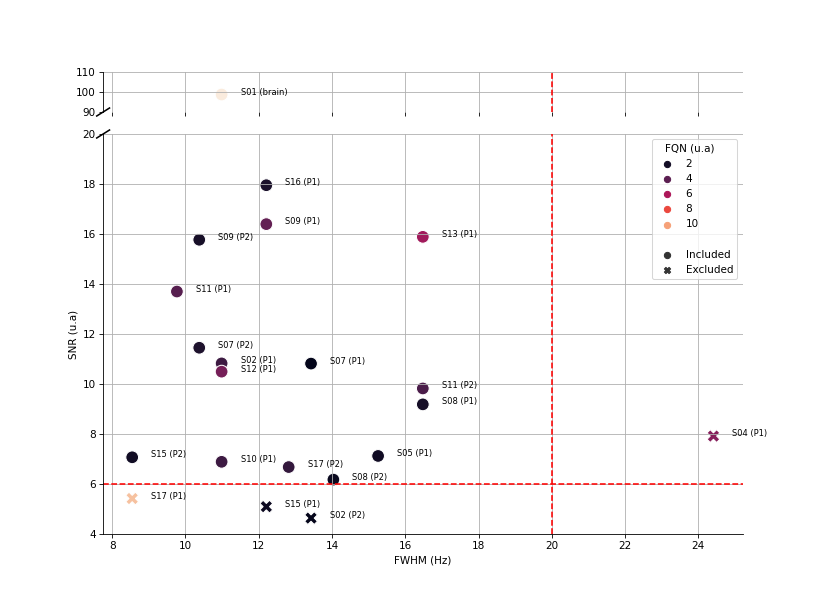

patient_pass_id  \
data_hash                        strategy_reco fit_ws_fit_hash                                    
2fff316122fc89a0b4d1f918f6cd62d8 sc            811c575861e6af8e9018c95c42530909          300_P1   
1baf6b702f39fefb5ad9e44179057ef7 sc            15c7948baff790f76b6d63c86d8780ff          307_P1   
a2b582b37a04bd4efc43138368bc0b96 sc            330135992aefca5f8c0d111d33e7b107          308_P1   
7cb024e470b0b2b072436635a19a1c00 sc            43a1722b7f6d2edd8c5fa15ec0165b11          311_P1   
9f8067ea065153da5b3a352d58f6ca23 sc            cc20bae3422c97d5e8e8d3d5749ac67c          313_P1   
0a58f85af8c32d06cbbca74391447ad2 sc            f89c349ae4ef9bdf50511eb8f94f1153          314_P1   
5f9a42662bfe3586bee57f3ead964778 sc            e995e28109f12ebc801142cbb7819216          316_P1   
f416f6db6cda52195e3b8046fc586ef2 sc            ca701ff66645dc092b4381355d5f8e48          319_P1   
b9875913db5c0f321922f819401cc02e sc            babdbe0526941261864f5fce3e2a6b70          328_P1   
fc8cb0e8f7b3747a10eeabc1cf8ab9fb sc            8664a086f10c08ed7c228c00477d5551          329_P1   
2e9c959e58727727c1576108fb6ef2b9 sc            11a3fe84cd36a62c79b4cb5517c8af31          336_P1   
afb10548c794ebbf8bd304be1f52b0c1 sc            aeee925c33fbd1ed4fbed581411311d8          338_P1   
ef31f01b58b8279ef0df239b6d15a055 sc            d75cd15ca6701d35e4400d46e8276b6f          300_P2   
62f4072c25c940cd1bfcb41a560749e2 sc            8ccd43889d662d918111314e3784e7ad          349_P1   
75ae13bc44bf3d55f5be46d4c59df84d sc            294508806b9fea4be5a103f5a19ad63b          311_P2   
967a1b8dace220e916df680759f31d84 sc            1bd990e11fa2e23421d3bea4bba8e4ed          336_P2   
90d883145e25fe54b74b05c16b56ace1 sc            29efeba2cb219d94449a28266b60e478          319_P2   
e8481853cde6f05d66b1c43d8dd00e40 sc            dbfd85e102ea2f402eda8923d49fdc52          313_P2   
e2c8b162388ff1d24dca288885b87e4b sc            f36d5d79ca550d664e4f0aad0e39a47a          314_P2   
45b70edaa2460689b120a7ed10a1f6e1 sc            af88a2559547f868ee3a9f3126ea9d50          349_P2   
b057a3e07319341e032e3c6c36ec4d83 brain         dc84673fa11aa8bd9252239c659110ff          296_P1   

                                                                                 included  
data_hash                        strategy_reco fit_ws_fit_hash                             
2fff316122fc89a0b4d1f918f6cd62d8 sc            811c575861e6af8e9018c95c42530909      True  
1baf6b702f39fefb5ad9e44179057ef7 sc            15c7948baff790f76b6d63c86d8780ff     False  
a2b582b37a04bd4efc43138368bc0b96 sc            330135992aefca5f8c0d111d33e7b107      True  
7cb024e470b0b2b072436635a19a1c00 sc            43a1722b7f6d2edd8c5fa15ec0165b11      True  
9f8067ea065153da5b3a352d58f6ca23 sc            cc20bae3422c97d5e8e8d3d5749ac67c      True  
0a58f85af8c32d06cbbca74391447ad2 sc            f89c349ae4ef9bdf50511eb8f94f1153      True  
5f9a42662bfe3586bee57f3ead964778 sc            e995e28109f12ebc801142cbb7819216      True  
f416f6db6cda52195e3b8046fc586ef2 sc            ca701ff66645dc092b4381355d5f8e48      True  
b9875913db5c0f321922f819401cc02e sc            babdbe0526941261864f5fce3e2a6b70      True  
fc8cb0e8f7b3747a10eeabc1cf8ab9fb sc            8664a086f10c08ed7c228c00477d5551      True  
2e9c959e58727727c1576108fb6ef2b9 sc            11a3fe84cd36a62c79b4cb5517c8af31     False  
afb10548c794ebbf8bd304be1f52b0c1 sc            aeee925c33fbd1ed4fbed581411311d8      True  
ef31f01b58b8279ef0df239b6d15a055 sc            d75cd15ca6701d35e4400d46e8276b6f     False  
62f4072c25c940cd1bfcb41a560749e2 sc            8ccd43889d662d918111314e3784e7ad     False  
75ae13bc44bf3d55f5be46d4c59df84d sc            294508806b9fea4be5a103f5a19ad63b      True  
967a1b8dace220e916df680759f31d84 sc            1bd990e11fa2e23421d3bea4bba8e4ed      True  
90d883145e25fe54b74b05c16b56ace1 sc            29efeba2cb219d94449a28266b60e478      True  
e8481853cde6f05d66b1c43d8dd00e40 sc            dbfd85e

In [37]:
this_df = df

# making an empty col for Included/Excluded
this_df[" "] = "Included"
this_df.loc[~this_df["included"], " "] = "Excluded"

# add best brain dataset
this_df_brain = df_brain.loc[(df_brain["strategy_full"] == "brain|pastis|none|14|0.5|2groups")].drop_duplicates("patient_pass_id")
this_df_brain = this_df_brain.loc[ (this_df_brain["snr_final"] == this_df_brain["snr_final"].max())]

this_df_brain = this_df_brain.drop_duplicates("patient_pass_id")
this_df_brain[" "] = "Included"

# concat and rename scale labels
this_df = pd.concat([this_df, this_df_brain])
this_df = this_df.rename(columns = {'snr_final':'SNR (u.a)'})
this_df = this_df.rename(columns = {'lw_final':'FWHM (Hz)'})
this_df = this_df.rename(columns = {'fit_ws_optim_results_fqn':'FQN (u.a)'})

print("n = %d" % len(this_df))

# broken axis scatter plot
cm = sns.color_palette("rocket", as_cmap=True)
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True,
                                      gridspec_kw={'hspace':0.10, 'height_ratios':[1, 10]})
g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                palette=cm, hue="FQN (u.a)",
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_top, legend=False)

ax_top.grid(True)
ax_top.axhline(threshold_snr_final, color='r', linestyle='--')
ax_top.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_labels = this_df.loc[(this_df["SNR (u.a)"] > 50)]
this_df_labels = this_df_labels.drop_duplicates("patient_pass_id")
add_labels("FWHM (Hz)", "SNR (u.a)", "patient_pass_id_pretty", this_df_labels, ax_top, 8, 0.5, 0.0)

g = sns.scatterplot(x="FWHM (Hz)", y="SNR (u.a)",
                palette=cm, hue="FQN (u.a)",
                style=" ", style_order=["Included", "Excluded"],
                s=150, data=this_df, ax=ax_bottom)
ax_bottom.grid(True)
ax_bottom.axhline(threshold_snr_final, color='r', linestyle='--')
ax_bottom.axvline(threshold_lw_final, color='r', linestyle='--')

this_df_labels = this_df.loc[(this_df["SNR (u.a)"] < 50)]
this_df_labels = this_df_labels.drop_duplicates("patient_pass_id")
add_labels("FWHM (Hz)", "SNR (u.a)", "patient_pass_id_pretty", this_df_labels, ax_bottom, 8, 0.5, 0.0)

ax_top.set_ylim([90, 110])
ax_top.set_ylabel("")
ax_bottom.set_ylim(4, 20)
sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

# draw the small break sign
ax = ax_top
d = .01
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d*10, +d*10), **kwargs)
ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

plt.savefig("./notebooks/figs/fig_snr_lw.svg")

this_df[["patient_pass_id", "included"]]

# Stats: data acquisition, quality
## Height & Weight & BMI

In [38]:
print("--- before filtering ---")
df = df_sc_all_reco.loc[(df_sc_all_reco["pass"] == 1)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))
print("Median BMI = %.2f" % (df["patient_bmi"].median()))
print("Mean age = %.2f +/-%.2f" % (df["patient_age"].mean(), df["patient_age"].std()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

print("--- before filtering [brain]---")
df = df_brain.loc[(df_brain["pass"] == 1)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))
print("Median BMI = %.2f" % (df["patient_bmi"].median()))
print("Mean age = %.2f +/-%.2f" % (df["patient_age"].mean(), df["patient_age"].std()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

--- before filtering ---
n = 13
Mean weight = 57.15kgs +/-14.79
Mean height = 1.65m +/-0.13
Mean BMI = 20.56 +/-2.89
Median BMI = 20.55
Mean age = 29.08 +/-5.01
Sex = M(4) F(9)
--- before filtering [brain]---
n = 3
Mean weight = 61.67kgs +/-20.21
Mean height = 1.71m +/-0.19
Mean BMI = 20.49 +/-2.95
Median BMI = 20.06
Mean age = 30.33 +/-0.58
Sex = M(1) F(2)


In [39]:
print("--- after filtering ---")
df = df_sc_all_reco.loc[(df_sc_all_reco["pass"] == 1) &
                        (df_sc_all_reco["included"] == True)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))
print("Mean age = %.2f +/-%.2f" % (df["patient_age"].mean(), df["patient_age"].std()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

print("--- after filtering [brain] ---")
df = df_brain.loc[(df_brain["pass"] == 1) &
                        (df_brain["included"] == True)].drop_duplicates("patient_id")

print("n = %d" % len(df))

print("Mean weight = %.2fkgs +/-%.2f" % (df["patient_weight"].mean(), df["patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f" % (df["patient_height"].mean(), df["patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f" % (df["patient_bmi"].mean(), df["patient_bmi"].std()))
print("Mean age = %.2f +/-%.2f" % (df["patient_age"].mean(), df["patient_age"].std()))

sex_counts = df.groupby("patient_sex")
print("Sex = M(%d) F(%d)" % (df.loc[sex_counts.groups["M"]]["patient_id"].nunique(), 
                             df.loc[sex_counts.groups["F"]]["patient_id"].nunique()))

--- after filtering ---
n = 10
Mean weight = 55.90kgs +/-16.27
Mean height = 1.64m +/-0.13
Mean BMI = 20.33 +/-3.21
Mean age = 29.50 +/-5.54
Sex = M(3) F(7)
--- after filtering [brain] ---
n = 2
Mean weight = 60.00kgs +/-28.28
Mean height = 1.67m +/-0.24
Mean BMI = 20.70 +/-4.14
Mean age = 30.50 +/-0.71
Sex = M(1) F(1)


## Voxel dimensions

In [40]:
df = df_sc_all_reco.drop_duplicates(["patient_pass_id"])

print("n = %d" % len(df))

print("* Voxel volume (cm3) = %.2f (%.2f)" % (df["voxel_vol_cm3"].mean(), 
                                              df["voxel_vol_cm3"].std()))

print("* Voxel X dimension (mm) = %.2f (%.2f)" % (df["voxel_size_x_mm"].mean(), 
                                              df["voxel_size_x_mm"].std()))
print("* Voxel Y dimension (mm) = %.2f (%.2f)" % (df["voxel_size_y_mm"].mean(), 
                                              df["voxel_size_y_mm"].std()))
print("* Voxel Z dimension (mm) = %.2f (%.2f)" % (df["voxel_size_z_mm"].mean(), 
                                              df["voxel_size_z_mm"].std()))

n = 20
* Voxel volume (cm3) = 0.97 (0.36)
* Voxel X dimension (mm) = 6.95 (1.39)
* Voxel Y dimension (mm) = 6.50 (0.89)
* Voxel Z dimension (mm) = 21.05 (2.52)


In [41]:
df["voxel_size_x_mm"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f     9.000000
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57     8.000003
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c     6.000002
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674     9.000000
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802     7.999996
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b     7.999997
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f     5.999998
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    10.000004
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c     6.000000
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

In [42]:
df["voxel_size_y_mm"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    8.000000
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    8.000000
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    6.000000
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    8.000002
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    6.000000
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    7.999997
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    5.999998
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    8.000003
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    5.999999
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3c19ba96fe

In [43]:
df["voxel_size_z_mm"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    20.000000
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    20.000007
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    20.000005
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    20.000004
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    22.999989
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    20.000000
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    20.000000
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    25.000000
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    22.999995
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

## CSDE (new calculation)

In [44]:
df["voxel_size_argsort_list"] = [np.argsort(o.voxel_size) for o in df["data_obj"]]

df["voxel_size_1stdim_mm"] = [o.voxel_size[0] for o in df["data_obj"]]
df["voxel_size_2nddim_mm"] = [o.voxel_size[1] for o in df["data_obj"]]
df["voxel_size_3rddim_mm"] = [o.voxel_size[2] for o in df["data_obj"]]

df["csde_1st_dim"] = [3400.0 if(type(o) == sim.mrs_seq_eja_svs_slaser) else np.nan for o in df["sequence_obj"]]
df["csde_1st_dim"] = df["csde_1st_dim"] / (df["voxel_size_1stdim_mm"] * 0.001)
df["csde_1st_dim"] = 1000.0 * df["reco_dataset_raw_data_sequence_f0"] / df["csde_1st_dim"]
df["csde_1st_dim"] = df["csde_1st_dim"] / df["voxel_size_1stdim_mm"] * 100.0

df["csde_2nd_dim"] = [o.pulse_rfc_r / (o.pulse_rfc_duration / 1000.0) if(type(o) == sim.mrs_seq_eja_svs_slaser) else np.nan for o in df["sequence_obj"]]
df["csde_2nd_dim"] = df["csde_2nd_dim"] / (df["voxel_size_2nddim_mm"] * 0.001)
df["csde_2nd_dim"] = 1000.0 * df["reco_dataset_raw_data_sequence_f0"] / df["csde_2nd_dim"]
df["csde_2nd_dim"] = df["csde_2nd_dim"] / df["voxel_size_2nddim_mm"] * 100.0

df["csde_3rd_dim"] = [o.pulse_rfc_r / (o.pulse_rfc_duration / 1000.0) if(type(o) == sim.mrs_seq_eja_svs_slaser) else np.nan for o in df["sequence_obj"]]
df["csde_3rd_dim"] = df["csde_3rd_dim"] / (df["voxel_size_3rddim_mm"] * 0.001)
df["csde_3rd_dim"] = 1000.0 * df["reco_dataset_raw_data_sequence_f0"] / df["csde_3rd_dim"]
df["csde_3rd_dim"] = df["csde_3rd_dim"] / df["voxel_size_3rddim_mm"] * 100.0

df["csde_x_new"] = [np.array([c1, c2, c3])[inds][1] for c1, c2, c3, inds in zip(df["csde_1st_dim"], df["csde_2nd_dim"], df["csde_3rd_dim"], df["voxel_size_argsort_list"])]
df["csde_y_new"] = [np.array([c1, c2, c3])[inds][0] for c1, c2, c3, inds in zip(df["csde_1st_dim"], df["csde_2nd_dim"], df["csde_3rd_dim"], df["voxel_size_argsort_list"])]
df["csde_z_new"] = [np.array([c1, c2, c3])[inds][2] for c1, c2, c3, inds in zip(df["csde_1st_dim"], df["csde_2nd_dim"], df["csde_3rd_dim"], df["voxel_size_argsort_list"])]


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value i

In [45]:
print("n = %d" % len(df))

print("* X dimension (%%/ppm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_x_new"].mean(), 
                                                 df["csde_x_new"].std(), 
                                                 df["csde_x_new"].min(), 
                                                 df["csde_x_new"].max()))

print("* Y dimension (%%/ppm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_y_new"].mean(), 
                                                 df["csde_y_new"].std(), 
                                                 df["csde_y_new"].min(), 
                                                 df["csde_y_new"].max()))

print("* Z dimension (%%/ppm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_z_new"].mean(), 
                                                 df["csde_z_new"].std(), 
                                                 df["csde_z_new"].min(), 
                                                 df["csde_z_new"].max()))


n = 20
* X dimension (%/ppm) = 11.42 (2.82) [8.74 - 17.83]
* Y dimension (%/ppm) = 11.49 (3.21) [8.74 - 17.83]
* Z dimension (%/ppm) = 12.90 (2.49) [8.74 - 17.83]


In [46]:
ppm_shift = 1.7
df["csde_x_new_mm"] = df["voxel_size_x_mm"] * (df["csde_x_new"] * ppm_shift) / 100.0
df["csde_y_new_mm"] = df["voxel_size_y_mm"] * (df["csde_y_new"] * ppm_shift) / 100.0
df["csde_z_new_mm"] = df["voxel_size_z_mm"] * (df["csde_z_new"] * ppm_shift) / 100.0


print ("*** Water ***")
print("* X dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_x_new_mm"].mean(), 
                                                 df["csde_x_new_mm"].std(), 
                                                 df["csde_x_new_mm"].min(), 
                                                 df["csde_x_new_mm"].max()))

print("* Y dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_y_new_mm"].mean(), 
                                                 df["csde_y_new_mm"].std(), 
                                                 df["csde_y_new_mm"].min(), 
                                                 df["csde_y_new_mm"].max()))

print("* Z dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_z_new_mm"].mean(), 
                                                 df["csde_z_new_mm"].std(), 
                                                 df["csde_z_new_mm"].min(), 
                                                 df["csde_z_new_mm"].max()))

ppm_shift = 1
df["csde_x_new_mm"] = df["voxel_size_x_mm"] * (df["csde_x_new"] * ppm_shift) / 100.0
df["csde_y_new_mm"] = df["voxel_size_y_mm"] * (df["csde_y_new"] * ppm_shift) / 100.0
df["csde_z_new_mm"] = df["voxel_size_z_mm"] * (df["csde_z_new"] * ppm_shift) / 100.0


print ("*** NAA ***")
print("* X dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_x_new_mm"].mean(), 
                                                 df["csde_x_new_mm"].std(), 
                                                 df["csde_x_new_mm"].min(), 
                                                 df["csde_x_new_mm"].max()))

print("* Y dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_y_new_mm"].mean(), 
                                                 df["csde_y_new_mm"].std(), 
                                                 df["csde_y_new_mm"].min(), 
                                                 df["csde_y_new_mm"].max()))

print("* Z dimension (mm) = %.2f (%.2f) [%.2f - %.2f]" % (df["csde_z_new_mm"].mean(), 
                                                 df["csde_z_new_mm"].std(), 
                                                 df["csde_z_new_mm"].min(), 
                                                 df["csde_z_new_mm"].max()))

*** Water ***
* X dimension (mm) = 1.35 (0.48) [0.89 - 3.03]
* Y dimension (mm) = 1.29 (0.47) [0.89 - 2.43]
* Z dimension (mm) = 4.59 (0.90) [2.97 - 6.06]
*** NAA ***
* X dimension (mm) = 0.80 (0.28) [0.52 - 1.78]
* Y dimension (mm) = 0.76 (0.27) [0.52 - 1.43]
* Z dimension (mm) = 2.70 (0.53) [1.75 - 3.57]


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

Could it be that these CSDE correlated with MRS or fit quality?

In [47]:
df["csde_x_new"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f     8.741378
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    10.402170
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674     8.741347
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    10.402209
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    17.832347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c     8.741340
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

In [48]:
df["csde_y_new"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57     8.741350
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c     8.741320
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802     8.741359
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    10.402209
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    17.832347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    13.374250
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

In [49]:
df["csde_z_new"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    10.402170
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b     8.741352
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f     8.741332
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36     8.741347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    13.374250
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

## CSDE vs Data quality

<IPython.core.display.Javascript object>


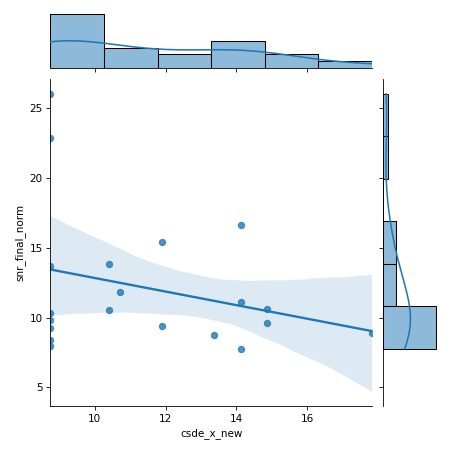

R = -0.28


<IPython.core.display.Javascript object>


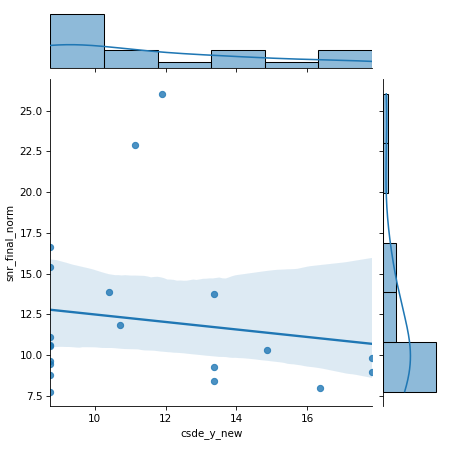

R = -0.15


<IPython.core.display.Javascript object>


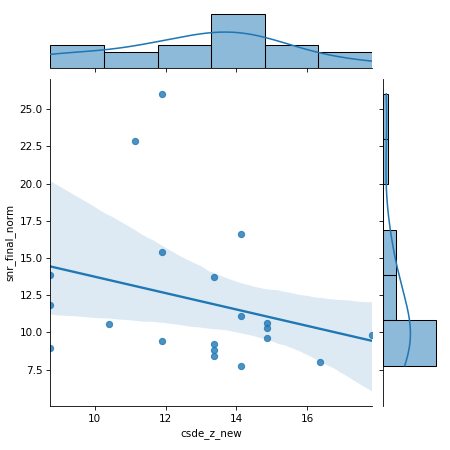

R = -0.28


<IPython.core.display.Javascript object>


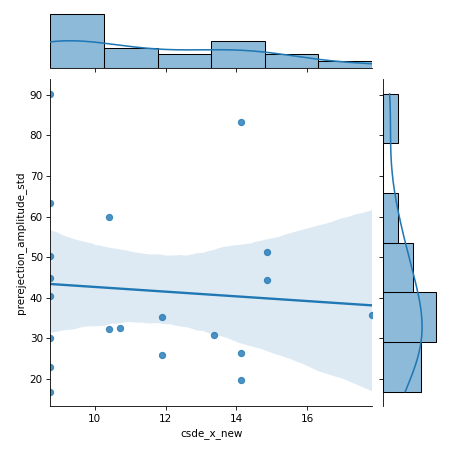

R = -0.08


<IPython.core.display.Javascript object>

R = 0.18


<IPython.core.display.Javascript object>


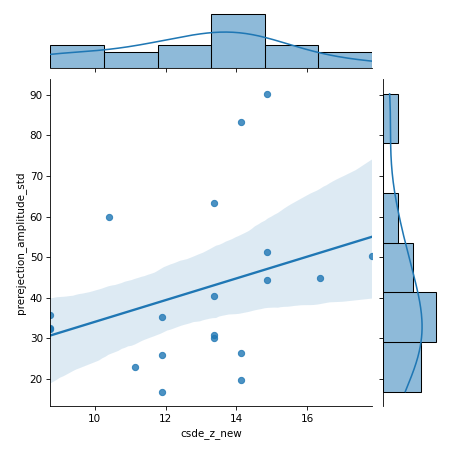

R = 0.33


<IPython.core.display.Javascript object>


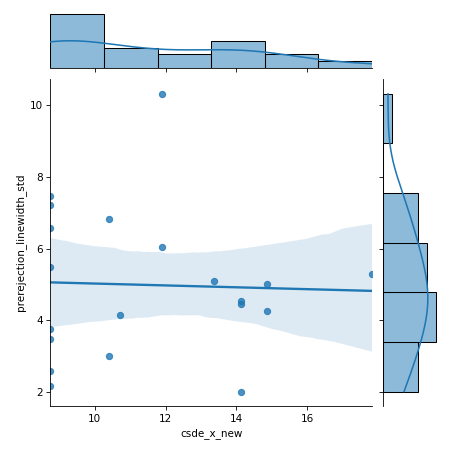

R = -0.04


<IPython.core.display.Javascript object>


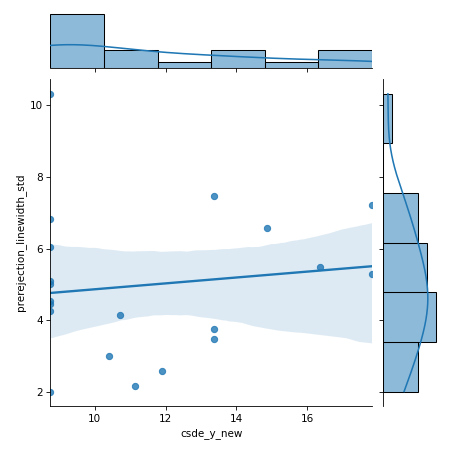

R = 0.13


<IPython.core.display.Javascript object>

R = 0.17


<IPython.core.display.Javascript object>


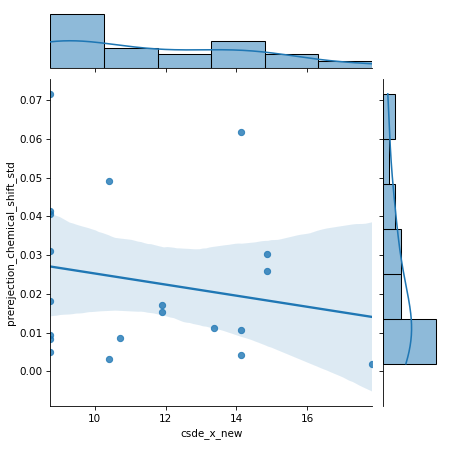

R = -0.20


<IPython.core.display.Javascript object>


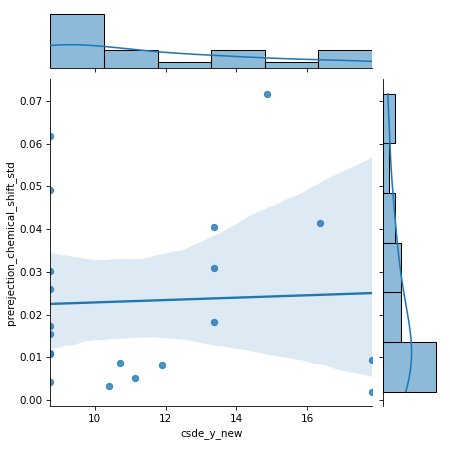

R = 0.04


<IPython.core.display.Javascript object>


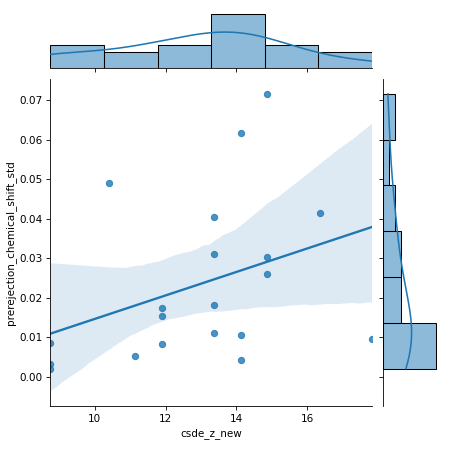

R = 0.36


<IPython.core.display.Javascript object>


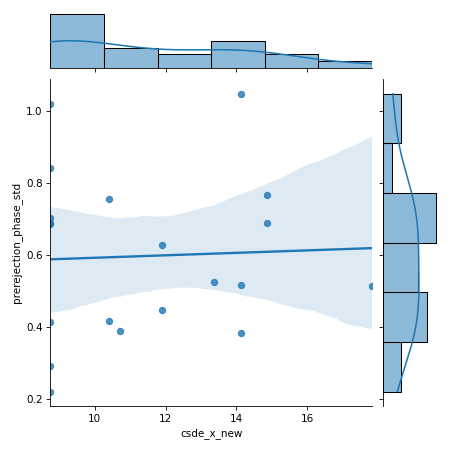

R = 0.04


<IPython.core.display.Javascript object>

R = 0.08


<IPython.core.display.Javascript object>

R = 0.43


In [50]:
par_list = [df["snr_final_norm"], 
            df["prerejection_amplitude_std"], 
            df["prerejection_linewidth_std"],
            df["prerejection_chemical_shift_std"],
            df["prerejection_phase_std"]]

for y in par_list:
    x = df["csde_x_new"]
    g = sns.JointGrid(x=x, y=y)
    g.plot_joint(sns.regplot)
    g.plot_marginals(sns.histplot, kde=True)
    print("R = %.2f" % x.corr(y))

    x = df["csde_y_new"]
    g = sns.JointGrid(x=x, y=y)
    g.plot_joint(sns.regplot)
    g.plot_marginals(sns.histplot, kde=True)
    print("R = %.2f" % x.corr(y))

    x = df["csde_z_new"]
    g = sns.JointGrid(x=x, y=y)
    g.plot_joint(sns.regplot)
    g.plot_marginals(sns.histplot, kde=True)
    print("R = %.2f" % x.corr(y))


There could be a relation between SNR, signal stability and some CSDE but not very strong. 

## CSDE (old calculation)

In [51]:
print("* X dimension (%%/ppm) = %.2f" % df["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df["csde_z"].mean())

print("* For protocol(i)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["csde_z"].mean())

print("* For protocol(ii)?")
print("* X dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_x"].mean())
print("* Y dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_y"].mean())
print("* Z dimension (%%/ppm) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["csde_z"].mean())

* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.54
* Z dimension (%/ppm) = 13.54
* For protocol(i)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 13.06
* Z dimension (%/ppm) = 13.06
* For protocol(ii)?
* X dimension (%/ppm) = 8.74
* Y dimension (%/ppm) = 14.66
* Z dimension (%/ppm) = 14.66


In [52]:
df["csde_x"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    8.741378
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    8.741350
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    8.741320
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    8.741347
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    8.741359
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    8.741352
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    8.741332
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    8.741347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    8.741340
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3c19ba96fe

In [53]:
df["csde_y"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    10.402170
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    10.402209
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    17.832347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    13.374250
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

In [54]:
df["csde_z"]

data_hash                         strategy_reco  fit_ws_fit_hash                 
2fff316122fc89a0b4d1f918f6cd62d8  sc             fe2b5cb6c6b15b14379d5717eed3b18f    13.374308
1baf6b702f39fefb5ad9e44179057ef7  sc             78e05bb995cbc226261bf0a47ff4ae57    11.888236
a2b582b37a04bd4efc43138368bc0b96  sc             8d3d19fe1d08602c5ffc630f6a36150c    10.402170
7cb024e470b0b2b072436635a19a1c00  sc             eb5f4efa865cc9e9c2a8f6d58239f674    16.346318
9f8067ea065153da5b3a352d58f6ca23  sc             276f94b35b24f4949b7f76c0f6c7a802    13.374280
0a58f85af8c32d06cbbca74391447ad2  sc             e6e340d0a1e3e631ee0b81d2fd87547b    10.402209
5f9a42662bfe3586bee57f3ead964778  sc             c744f72057d21aa7b12eafecb28a3c0f    10.699390
f416f6db6cda52195e3b8046fc586ef2  sc             e75b0cb935129187f238ce71cf7bbe36    17.832347
b9875913db5c0f321922f819401cc02e  sc             38d1ba2cad296b8d8df8fd2259cf427c    13.374250
fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc             f0e5f7b73019b3

## Average TE

In [55]:
print("n = %d" % len(df))

print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df["reco_dataset_raw_data_sequence_te"].mean(), 
                                                 df["reco_dataset_raw_data_sequence_te"].std(), 
                                                 df["reco_dataset_raw_data_sequence_te"].min(), 
                                                 df["reco_dataset_raw_data_sequence_te"].max()))

print("* For protocol(i)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].mean(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].std(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].min(),
                                                 df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_te"].max()))

print("* For protocol(ii)?")
print("* TE (ms) = %.2f (%.2f) [%.2f - %.2f]" % (df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].mean(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].std(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].min(),
                                                df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_te"].max()))


n = 20
* TE (ms) = 46.01 (13.51) [21.16 - 90.00]
* For protocol(i)?
* TE (ms) = 51.55 (11.79) [41.68 - 90.00]
* For protocol(ii)?
* TE (ms) = 33.08 (6.73) [21.16 - 38.96]


## Min and average TR

In [56]:
print("n = %d" % len(df))

print("* Min TR (ms) = %.2f" % df["reco_dataset_raw_data_sequence_tr"].mean())

print("* For protocol(i)?")
print("* Min TR (ms) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] >=20]["reco_dataset_raw_data_sequence_tr"].mean())

print("* For protocol(ii)?")
print("* Min TR (ms) = %.2f" % df.loc[df["reco_dataset_raw_data_sequence_pulse_rfc_r"] <20]["reco_dataset_raw_data_sequence_tr"].mean())


print("* Eff TR (s) = %.2f" % (df["acqtime_eff"] / df["reco_dataset_raw_data_sequence_na"]).mean())


n = 20
* Min TR (ms) = 4893.00
* For protocol(i)?
* Min TR (ms) = 4577.86
* For protocol(ii)?
* Min TR (ms) = 5628.33
* Eff TR (s) = 7.17


## Acquisition time

In [57]:
print("n = %d" % len(df))

print("* Acquisition time (min) = %.2f" % (df["acqtime"].mean() / 60))
print("* Eff acquisition time (min) = %.2f" % (df["acqtime_eff"].mean() / 60))

n = 20
* Acquisition time (min) = 9.71
* Eff acquisition time (min) = 13.44


## Data discardment
### Average rejection rate

In [58]:
df = df_sc_all_reco.loc[(df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")].drop_duplicates(["patient_pass_id"])

print("n = %d" % len(df))
print("* Data rejected (%%) = %.2f" % df["rejection_rate_prct"].mean())

n = 20
* Data rejected (%) = 5.90


### Rejection method used the most

In [59]:
plt.figure()
this_df = df
this_df["rejection_method"] = this_df["rejection_method"].astype(str)
this_df = this_df.loc[this_df["rejection_method"] != "None"]
this_df.groupby("rejection_method")["patient_pass_id"].nunique().plot.pie(autopct="%.1f%%")

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='patient_pass_id'>

### Gain in SNR/LW
#### Compare sc_nodatarej vs. sc_nodatarej_norea

In [60]:
df = df_sc_all_reco.loc[df_sc_all_reco.index.get_level_values("strategy_reco").isin(["sc_nodatarej_norea", "sc_nodatarej"])]
df = df.reset_index().drop_duplicates(["patient_pass_id", "reco_template_name"])

df = df.reset_index().sort_values(by=["data_hash", "reco_template_name"], ascending=False)

df["snr_rel_diff"] = df.groupby(["data_hash"])["snr_final"].pct_change().fillna(0) * 100.0
df["lw_diff"] = df.groupby(["data_hash"])["lw_final"].diff().fillna(0)

print("--- sc_nodatarej vs. sc_nodatarej_norea ---")
print("n = %d" % len(df))
print("* SNR gain (%%) = %.2f" % (df.loc[df["reco_template_name"] == "sc_nodatarej"]["snr_rel_diff"].mean()))
print("* FWHM gain (Hz) = %.2f" % (df.loc[df["reco_template_name"] == "sc_nodatarej"]["lw_diff"].mean()))

df[["data_hash", "reco_template_name", "patient_pass_id", "snr_final", "lw_final", "snr_rel_diff", "lw_diff"]]

--- sc_nodatarej vs. sc_nodatarej_norea ---
n = 40
* SNR gain (%) = 2.00
* FWHM gain (Hz) = -6.35


data_hash  reco_template_name patient_pass_id  \
29  fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc_nodatarej_norea          329_P1   
9   fc8cb0e8f7b3747a10eeabc1cf8ab9fb        sc_nodatarej          329_P1   
27  f416f6db6cda52195e3b8046fc586ef2  sc_nodatarej_norea          319_P1   
7   f416f6db6cda52195e3b8046fc586ef2        sc_nodatarej          319_P1   
32  ef31f01b58b8279ef0df239b6d15a055  sc_nodatarej_norea          300_P2   
12  ef31f01b58b8279ef0df239b6d15a055        sc_nodatarej          300_P2   
37  e8481853cde6f05d66b1c43d8dd00e40  sc_nodatarej_norea          313_P2   
17  e8481853cde6f05d66b1c43d8dd00e40        sc_nodatarej          313_P2   
38  e2c8b162388ff1d24dca288885b87e4b  sc_nodatarej_norea          314_P2   
18  e2c8b162388ff1d24dca288885b87e4b        sc_nodatarej          314_P2   
28  b9875913db5c0f321922f819401cc02e  sc_nodatarej_norea          328_P1   
8   b9875913db5c0f321922f819401cc02e        sc_nodatarej          328_P1   
31  afb10548c794ebbf8bd304be1f52b0c1  sc_nodatarej_norea          338_P1   
11  afb10548c794ebbf8bd304be1f52b0c1        sc_nodatarej          338_P1   
22  a2b582b37a04bd4efc43138368bc0b96  sc_nodatarej_norea          308_P1   
2   a2b582b37a04bd4efc43138368bc0b96        sc_nodatarej          308_P1   
24  9f8067ea065153da5b3a352d58f6ca23  sc_nodatarej_norea          313_P1   
4   9f8067ea065153da5b3a352d58f6ca23        sc_nodatarej          313_P1   
35  967a1b8dace220e916df680759f31d84  sc_nodatarej_norea          336_P2   
15  967a1b8dace220e916df680759f31d84        sc_nodatarej          336_P2   
36  90d883145e25fe54b74b05c16b56ace1  sc_nodatarej_norea          319_P2   
16  90d883145e25fe54b74b05c16b56ace1        sc_nodatarej          319_P2   
23  7cb024e470b0b2b072436635a19a1c00  sc_nodatarej_norea          311_P1   
3   7cb024e470b0b2b072436635a19a1c00        sc_nodatarej          311_P1   
34  75ae13bc44bf3d55f5be46d4c59df84d  sc_nodatarej_norea          311_P2   
14  75ae13bc44bf3d55f5be46d4c59df84d        sc_nodatarej          311_P2   
33  62f4072c25c940cd1bfcb41a560749e2  sc_nodatarej_norea          349_P1   
13  62f4072c25c940cd1bfcb41a560749e2        sc_nodatarej          349_P1   
26  5f9a42662bfe3586bee57f3ead964778  sc_nodatarej_norea          316_P1   
6   5f9a42662bfe3586bee57f3ead964778        sc_nodatarej          316_P1   
39  45b70edaa2460689b120a7ed10a1f6e1  sc_nodatarej_norea          349_P2   
19  45b70edaa2460689b120a7ed10a1f6e1        sc_nodatarej          349_P2   
20  2fff316122fc89a0b4d1f918f6cd62d8  sc_nodatarej_norea          300_P1   
0   2fff316122fc89a0b4d1f918f6cd62d8        sc_nodatarej          300_P1   
30  2e9c959e58727727c1576108fb6ef2b9  sc_nodatarej_norea          336_P1   
10  2e9c959e58727727c1576108fb6ef2b9        sc_nodatarej          336_P1   
21  1baf6b702f39fefb5ad9e44179057ef7  sc_nodatarej_norea          307_P1   
1   1baf6b702f39fefb5ad9e44179057ef7        sc_nodatarej          307_P1   
25  0a58f85af8c32d06cbbca74391447ad2  sc_nodatarej_norea          314_P1   
5   0a58f85af8c32d06cbbca74391447ad2        sc_nodatarej          314_P1   

    snr_final   lw_final  snr_rel_diff    lw_diff  
29  14.296147  20.751953      0.000000   0.000000  
9   15.813580  15.869141     10.614285  -4.882813  
27  14.554223  10.986328      0.000000   0.000000  
7   14.761143   9.765625      1.421715  -1.220703  
32   5.995440  22.583008      0.000000   0.000000  
12   4.636314  13.427734    -22.669328  -9.155273  
37   7.825510  17.089844      0.000000   0.000000  
17   6.690841  14.648438    -14.499622  -2.441406  
38  19.127877  12.207031      0.000000   0.000000  
18  15.769126  10.375977    -17.559451  -1.831055  
28  11.103476  14.038086      0.000000   0.000000  
8   10.896074  10.986328     -1.867906  -3.051758  
31  14.048240  15.869141      0.000000   0.000000  
11  17.951592  12.207031     27.785345  -3.662109  
22   6.874873  33.569336      0.000000   0.000000  
2    7.304202  14.648438      6.244911 -18.920898  
24   9.255101  24.414062  

#### Compare sc vs. sc_nodatarej_norea

In [61]:
df = df_sc_all_reco.loc[df_sc_all_reco.index.get_level_values("strategy_reco").isin(["sc_nodatarej_norea", "sc"])]
df = df.reset_index().drop_duplicates(["patient_pass_id", "reco_template_name"])

df = df.reset_index().sort_values(by=["data_hash", "reco_template_name"], ascending=False)

df["snr_rel_diff"] = df.groupby(["data_hash"])["snr_final"].pct_change().fillna(0) * 100.0
df["lw_diff"] = df.groupby(["data_hash"])["lw_final"].diff().fillna(0)

print("--- sc vs. sc_nodatarej_norea ---")
print("n = %d" % len(df))
print("* SNR gain (%%) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["snr_rel_diff"].mean()))
print("* FWHM gain (Hz) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["lw_diff"].mean()))

df[["data_hash", "reco_template_name", "patient_pass_id", "snr_final", "lw_final", "snr_rel_diff", "lw_diff"]]

--- sc vs. sc_nodatarej_norea ---
n = 40
* SNR gain (%) = -2.10
* FWHM gain (Hz) = -6.47


data_hash  reco_template_name patient_pass_id  \
29  fc8cb0e8f7b3747a10eeabc1cf8ab9fb  sc_nodatarej_norea          329_P1   
9   fc8cb0e8f7b3747a10eeabc1cf8ab9fb                  sc          329_P1   
27  f416f6db6cda52195e3b8046fc586ef2  sc_nodatarej_norea          319_P1   
7   f416f6db6cda52195e3b8046fc586ef2                  sc          319_P1   
32  ef31f01b58b8279ef0df239b6d15a055  sc_nodatarej_norea          300_P2   
12  ef31f01b58b8279ef0df239b6d15a055                  sc          300_P2   
37  e8481853cde6f05d66b1c43d8dd00e40  sc_nodatarej_norea          313_P2   
17  e8481853cde6f05d66b1c43d8dd00e40                  sc          313_P2   
38  e2c8b162388ff1d24dca288885b87e4b  sc_nodatarej_norea          314_P2   
18  e2c8b162388ff1d24dca288885b87e4b                  sc          314_P2   
28  b9875913db5c0f321922f819401cc02e  sc_nodatarej_norea          328_P1   
8   b9875913db5c0f321922f819401cc02e                  sc          328_P1   
31  afb10548c794ebbf8bd304be1f52b0c1  sc_nodatarej_norea          338_P1   
11  afb10548c794ebbf8bd304be1f52b0c1                  sc          338_P1   
22  a2b582b37a04bd4efc43138368bc0b96  sc_nodatarej_norea          308_P1   
2   a2b582b37a04bd4efc43138368bc0b96                  sc          308_P1   
24  9f8067ea065153da5b3a352d58f6ca23  sc_nodatarej_norea          313_P1   
4   9f8067ea065153da5b3a352d58f6ca23                  sc          313_P1   
35  967a1b8dace220e916df680759f31d84  sc_nodatarej_norea          336_P2   
15  967a1b8dace220e916df680759f31d84                  sc          336_P2   
36  90d883145e25fe54b74b05c16b56ace1  sc_nodatarej_norea          319_P2   
16  90d883145e25fe54b74b05c16b56ace1                  sc          319_P2   
23  7cb024e470b0b2b072436635a19a1c00  sc_nodatarej_norea          311_P1   
3   7cb024e470b0b2b072436635a19a1c00                  sc          311_P1   
34  75ae13bc44bf3d55f5be46d4c59df84d  sc_nodatarej_norea          311_P2   
14  75ae13bc44bf3d55f5be46d4c59df84d                  sc          311_P2   
33  62f4072c25c940cd1bfcb41a560749e2  sc_nodatarej_norea          349_P1   
13  62f4072c25c940cd1bfcb41a560749e2                  sc          349_P1   
26  5f9a42662bfe3586bee57f3ead964778  sc_nodatarej_norea          316_P1   
6   5f9a42662bfe3586bee57f3ead964778                  sc          316_P1   
39  45b70edaa2460689b120a7ed10a1f6e1  sc_nodatarej_norea          349_P2   
19  45b70edaa2460689b120a7ed10a1f6e1                  sc          349_P2   
20  2fff316122fc89a0b4d1f918f6cd62d8  sc_nodatarej_norea          300_P1   
0   2fff316122fc89a0b4d1f918f6cd62d8                  sc          300_P1   
30  2e9c959e58727727c1576108fb6ef2b9  sc_nodatarej_norea          336_P1   
10  2e9c959e58727727c1576108fb6ef2b9                  sc          336_P1   
21  1baf6b702f39fefb5ad9e44179057ef7  sc_nodatarej_norea          307_P1   
1   1baf6b702f39fefb5ad9e44179057ef7                  sc          307_P1   
25  0a58f85af8c32d06cbbca74391447ad2  sc_nodatarej_norea          314_P1   
5   0a58f85af8c32d06cbbca74391447ad2                  sc          314_P1   

    snr_final   lw_final  snr_rel_diff    lw_diff  
29  14.296147  20.751953      0.000000   0.000000  
9   15.886397  16.479492     11.123627  -4.272461  
27  14.554223  10.986328      0.000000   0.000000  
7   13.698833   9.765625     -5.877267  -1.220703  
32   5.995440  22.583008      0.000000   0.000000  
12   4.636314  13.427734    -22.669328  -9.155273  
37   7.825510  17.089844      0.000000   0.000000  
17   6.175400  14.038086    -21.086292  -3.051758  
38  19.127877  12.207031      0.000000   0.000000  
18  15.769126  10.375977    -17.559451  -1.831055  
28  11.103476  14.038086      0.000000   0.000000  
8   10.493958  10.986328     -5.489441  -3.051758  
31  14.048240  15.869141      0.000000   0.000000  
11  17.951592  12.207031     27.785345  -3.662109  
22   6.874873  33.569336      0.000000   0.000000  
2    7.121938  15.258789      3.593743 -18.310547  
24   9.255101  24.414062  

#### Compare sc vs. sc_nodatarej

In [62]:
df = df_sc_all_reco.loc[df_sc_all_reco.index.get_level_values("strategy_reco").isin(["sc_nodatarej", "sc"])]
df = df.reset_index().drop_duplicates(["patient_pass_id", "reco_template_name"])

df = df.reset_index().sort_values(by=["data_hash", "reco_template_name"], ascending=False)

df["snr_rel_diff"] = df.groupby(["data_hash"])["snr_final"].pct_change().fillna(0) * 100.0
df["lw_diff"] = df.groupby(["data_hash"])["lw_final"].diff().fillna(0)

print("--- sc vs. sc_nodatarej ---")
print("n = %d" % len(df))
print("* SNR gain (%%) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["snr_rel_diff"].mean()))
print("* FWHM gain (Hz) = %.2f" % (df.loc[df["reco_template_name"] == "sc"]["lw_diff"].mean()))

df[["data_hash", "reco_template_name", "patient_pass_id", "snr_final", "lw_final", "snr_rel_diff", "lw_diff"]]

--- sc vs. sc_nodatarej ---
n = 40
* SNR gain (%) = -3.88
* FWHM gain (Hz) = -0.12


data_hash reco_template_name patient_pass_id  \
29  fc8cb0e8f7b3747a10eeabc1cf8ab9fb       sc_nodatarej          329_P1   
9   fc8cb0e8f7b3747a10eeabc1cf8ab9fb                 sc          329_P1   
27  f416f6db6cda52195e3b8046fc586ef2       sc_nodatarej          319_P1   
7   f416f6db6cda52195e3b8046fc586ef2                 sc          319_P1   
32  ef31f01b58b8279ef0df239b6d15a055       sc_nodatarej          300_P2   
12  ef31f01b58b8279ef0df239b6d15a055                 sc          300_P2   
37  e8481853cde6f05d66b1c43d8dd00e40       sc_nodatarej          313_P2   
17  e8481853cde6f05d66b1c43d8dd00e40                 sc          313_P2   
38  e2c8b162388ff1d24dca288885b87e4b       sc_nodatarej          314_P2   
18  e2c8b162388ff1d24dca288885b87e4b                 sc          314_P2   
28  b9875913db5c0f321922f819401cc02e       sc_nodatarej          328_P1   
8   b9875913db5c0f321922f819401cc02e                 sc          328_P1   
31  afb10548c794ebbf8bd304be1f52b0c1       sc_nodatarej          338_P1   
11  afb10548c794ebbf8bd304be1f52b0c1                 sc          338_P1   
22  a2b582b37a04bd4efc43138368bc0b96       sc_nodatarej          308_P1   
2   a2b582b37a04bd4efc43138368bc0b96                 sc          308_P1   
24  9f8067ea065153da5b3a352d58f6ca23       sc_nodatarej          313_P1   
4   9f8067ea065153da5b3a352d58f6ca23                 sc          313_P1   
35  967a1b8dace220e916df680759f31d84       sc_nodatarej          336_P2   
15  967a1b8dace220e916df680759f31d84                 sc          336_P2   
36  90d883145e25fe54b74b05c16b56ace1       sc_nodatarej          319_P2   
16  90d883145e25fe54b74b05c16b56ace1                 sc          319_P2   
23  7cb024e470b0b2b072436635a19a1c00       sc_nodatarej          311_P1   
3   7cb024e470b0b2b072436635a19a1c00                 sc          311_P1   
34  75ae13bc44bf3d55f5be46d4c59df84d       sc_nodatarej          311_P2   
14  75ae13bc44bf3d55f5be46d4c59df84d                 sc          311_P2   
33  62f4072c25c940cd1bfcb41a560749e2       sc_nodatarej          349_P1   
13  62f4072c25c940cd1bfcb41a560749e2                 sc          349_P1   
26  5f9a42662bfe3586bee57f3ead964778       sc_nodatarej          316_P1   
6   5f9a42662bfe3586bee57f3ead964778                 sc          316_P1   
39  45b70edaa2460689b120a7ed10a1f6e1       sc_nodatarej          349_P2   
19  45b70edaa2460689b120a7ed10a1f6e1                 sc          349_P2   
20  2fff316122fc89a0b4d1f918f6cd62d8       sc_nodatarej          300_P1   
0   2fff316122fc89a0b4d1f918f6cd62d8                 sc          300_P1   
30  2e9c959e58727727c1576108fb6ef2b9       sc_nodatarej          336_P1   
10  2e9c959e58727727c1576108fb6ef2b9                 sc          336_P1   
21  1baf6b702f39fefb5ad9e44179057ef7       sc_nodatarej          307_P1   
1   1baf6b702f39fefb5ad9e44179057ef7                 sc          307_P1   
25  0a58f85af8c32d06cbbca74391447ad2       sc_nodatarej          314_P1   
5   0a58f85af8c32d06cbbca74391447ad2                 sc          314_P1   

    snr_final   lw_final  snr_rel_diff       lw_diff  
29  15.813580  15.869141      0.000000  0.000000e+00  
9   15.886397  16.479492      0.460467  6.103516e-01  
27  14.761143   9.765625      0.000000  0.000000e+00  
7   13.698833   9.765625     -7.196666  0.000000e+00  
32   4.636314  13.427734      0.000000  0.000000e+00  
12   4.636314  13.427734      0.000000  0.000000e+00  
37   6.690841  14.648438      0.000000  0.000000e+00  
17   6.175400  14.038086     -7.703674 -6.103516e-01  
38  15.769126  10.375977      0.000000  0.000000e+00  
18  15.769126  10.375977      0.000000  0.000000e+00  
28  10.896074  10.986328      0.000000  0.000000e+00  
8   10.493958  10.986328     -3.690469  0.000000e+00  
31  17.951592  12.207031      0.000000  0.000000e+00  
11  17.951592  12.207031      0.000000  0.000000e+00  
22   7.304202  14.648438      0.000000  0.000000e+00  
2    7.121938  15.258789     -2.495337  6.103516e-01  
24   9.050039  1

* Frequency realignment is really benefic: +2%SNR but surtout -6Hz LW
* Data discardment performance is really not observable in terms of SNR/LW: just a little better LW but actually a loss in SNR (-3%)! Is it really usefull here???

# Investigating rejected datasets:

## [FIG] Normalized SNR vs. BMI

<IPython.core.display.Javascript object>


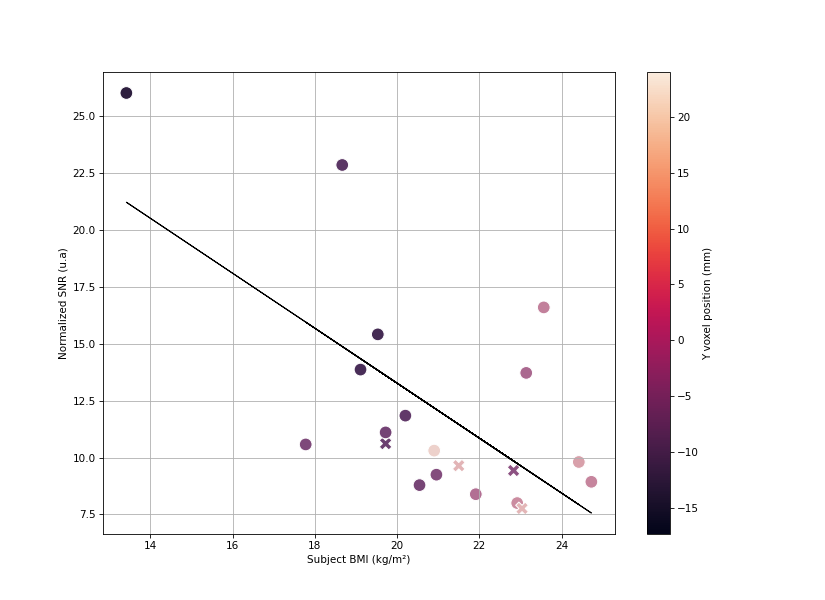

R = -0.65


In [63]:
df = df_sc_all_reco.loc[(df_sc_all_reco.index.get_level_values("strategy_reco") == "sc")].drop_duplicates("patient_pass_id")

this_df = df
this_df = this_df.rename(columns = {'snr_final_norm':'Normalized SNR (u.a)'})
this_df = this_df.rename(columns = {'patient_bmi':'Subject BMI'})
x = this_df["Subject BMI"]
y = this_df["Normalized SNR (u.a)"]

plt.figure()
g = sns.scatterplot(x="Subject BMI", y="Normalized SNR (u.a)",
                hue="voxel_pos_y_mm", cmap=cm,
                style="included", style_order=[True, False],
                s=150, data=this_df)

plt.grid(True)

norm = plt.Normalize(this_df['voxel_pos_y_mm'].min(), this_df['voxel_pos_y_mm'].max())
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
g.get_legend().remove()
cb = g.figure.colorbar(sm)
cb.set_label(label='Y voxel position (mm)')

plt.show()

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='k', linewidth=1)

print("R = %.2f" % x.corr(y))

plt.xlabel("Subject BMI (kg/m²)")

plt.savefig("./notebooks/figs/fig_snr_bmi.svg")

## 5ppm artefact?

<IPython.core.display.Javascript object>


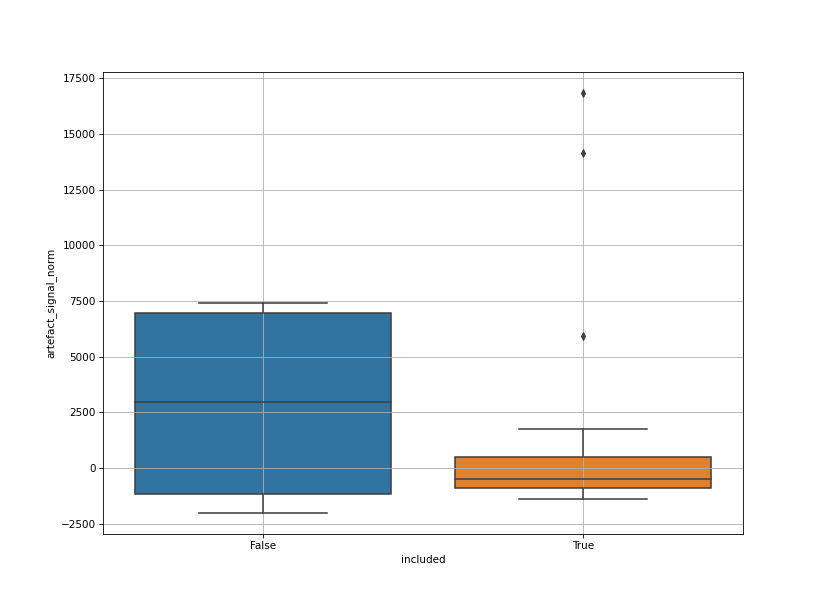

In [64]:
plt.figure()
g = sns.boxplot(x="included", y="artefact_signal_norm", data=df)
plt.grid('on')

Clearly, rejected datasets show a stronger 5ppm artefact level in average... It is one of the reasons yes. 

# [FIG] Spectra gallery

In [65]:
this_df = df_sc_all_reco.loc[(df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")].drop_duplicates("patient_pass_id")

this_df = this_df.loc[this_df["patient_pass_id"].isin(["338_P1", "314_P2", "311_P1", "300_P2"])]

# add best brain dataset
this_df_brain = df_brain.loc[(df_brain["strategy_full"] == "brain|pastis|none|14|0.5|2groups")].drop_duplicates("patient_pass_id")

this_df_brain = this_df_brain.loc[ (this_df_brain["snr_final"] == this_df_brain["snr_final"].max())]

# concat
this_df = pd.concat([this_df, this_df_brain])
this_df = this_df.sort_values(by="snr_final")

# add SNR to the label
this_df["spectra_gllr_lbl"] = ["%s (%.1f)" % (s1.replace(" (P1)", "").replace(" (P2)", ""), s2) for (s1, s2) in zip(this_df["patient_pass_id_pretty"], this_df["snr_final"])]

k = 0
label_x = 1.9 #ppm
for this_index, this_row in this_df.iterrows():
    s = this_row["data_obj"]
    
    s.set_display_offset(10000.0 * k)
    fig = s.display_spectrum_1d(1000)
    
    # add some x/y for annotation
    this_df.at[this_index, "spectrum_label_x"] = label_x
    this_df.at[this_index, "spectrum_label_y"] = 10000.0 * k
    
    # line color
    if(this_row["included"] or (this_row["snr_final"] > 50)):
        fig.axes[0].get_lines()[-1].set_color('black')
    else:
        fig.axes[0].get_lines()[-1].set_color('grey')
        
    # iterate
    k += 1

add_labels("spectrum_label_x", "spectrum_label_y", "spectra_gllr_lbl", this_df, plt.gca(),  9, 0, 3500)

ax = fig.axes
ax[0].set(yticklabels=[])
ax[0].get_legend().remove()
plt.ylabel("")
  
plt.xlim([5, 1])
yts = plt.yticks()
plt.yticks(yts[0][0:-4])
plt.ylim([-5000, 75000])

# add metabolites labels
yo = 10000
plt.text(2, 60000 + yo, "tNAA")
plt.text(2.5, 35000 + yo, "Glx")
plt.text(2.85, 33000 + yo, "NAA")
plt.text(3, 50000 + yo, "tCr")
plt.text(3.55, 45000 + yo, "tCho")
plt.text(3.52, 34000 + yo, "Tau")
plt.text(4.15, 45000 + yo, "tCr")
plt.text(4.25, 35000 + yo, "mI")
plt.text(3.65, 38000 + yo, "mI")
plt.text(3.9, 38000 + yo, "Glu")


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>

/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/reco.py:3162: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  plt.figure(ifig).canvas.set_window_title("display_spectrum_1d (mrs.reco.MRSData2)")
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/home/tangir/data/work/recherche/crmbm/python/pastis/mrs/reco.py:3162: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  plt.figure(ifig).canvas.set_window_title("display_spectrum_1d (mrs.reco.MRSData2)")
/home/tangir/data/work/recherche/crmbm/python

Text(3.9, 48000, 'Glu')

In [66]:
# get previous fig and paste it here
new_fig = plt.figure(figsize=(13,6))
new_fig.subplots_adjust(wspace=0.01, hspace=0.01)

fig = plt.figure(1000)
ax_previous_fig = fig.axes[0]

ax_previous_fig.figure=new_fig
new_fig.axes.append(ax_previous_fig)
new_fig.add_axes(ax_previous_fig)

dummy = new_fig.add_subplot(1,3,(1,2))
ax_previous_fig.set_position(dummy.get_position())
dummy.remove()

xlim = ax_previous_fig.get_xlim()
ylim = ax_previous_fig.get_ylim()
ax_previous_fig.text(xlim[0] - (xlim[0]-xlim[1])*0.02, 
                     ylim[0] + (ylim[1]-ylim[0])*0.02, 
                    "A.",
                    fontsize=12)

# add a nice anatomy for spinal cord
t2w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/314-yt-p2-moelle/20200625/01_0005_t2-tse-sag-2d-10sl-p2-trig-s4-nd/original-primary-m-norm-nd_e01_0001.dcm")

ind_patient = 2
this_df_nice_subject = this_df.loc[this_df["patient_pass_id"] == "314_P2"]
pcg = this_df_nice_subject["data_obj"].iloc[0]
print(this_df_nice_subject["patient_pass_id"].iloc[0])
print(this_df_nice_subject["patient_id_pretty"].iloc[0])
print(this_df_nice_subject["voxel_size_x_mm"].iloc[0])
print(this_df_nice_subject["voxel_size_y_mm"].iloc[0])
print(this_df_nice_subject["voxel_size_z_mm"].iloc[0])

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index = t2w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.4, -1],
                     [0, -0.4, 1],
                     [0, 0.4, 1],
                     [0, 0.4, -1],
                     [0, -0.4, -1]]
corner_coords = np.array([t2w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])


ax = new_fig.add_subplot(2,2,4)
ax.imshow(t2w[pcg_centre_index[2]], cmap=plt.cm.gray)
ax.plot(corner_coords[:, 0], corner_coords[:, 1], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "C.",
        fontsize=12, color="white")

<IPython.core.display.Javascript object>

314_P2
S09
5.99999999977624
5.99999738454667
19.999991281076372


Text(7.18, 240.14, 'C.')

In [67]:
# add a nice anatomy for brain

t1w = suspect.image.load_dicom_volume("/home/tangir/crmbm/acq/347-re-p1-moelle/20200123/01_0009_mp2rage-wip900-sag-0-6iso-p3-uni-den/original-primary-m-nd-uni_e01_0001.dcm")

pcg = reco.MRSData2("/home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat")

pcg_centre = pcg.to_scanner(0, 0, 0)
pcg_centre_index_brain = t1w.from_scanner(*pcg_centre).round().astype(int)

corner_coords_pcg = [[0, -0.75, -0.75],
                     [0, -0.75,  0.75],
                     [0, 0.75, 0.75],
                     [0, 0.75, -0.75],
                     [0, -0.75, -0.75]]
corner_coords = np.array([t1w.from_scanner(*pcg.to_scanner(*coord)) for coord in corner_coords_pcg])

ax = new_fig.add_subplot(2,2,2)
img_tmp = t1w[:, pcg_centre_index_brain[1], :].T
img_tmp = np.concatenate((np.zeros([402, int((402-256)/2)]), img_tmp), axis=1)
img_tmp = np.concatenate((img_tmp, np.zeros([402, int((402-256)/2)])), axis=1)

ax.imshow(img_tmp, cmap=plt.cm.gray)
ax.plot(corner_coords[:, 1]+int((402-256)/2), corner_coords[:, 0], 'red')
ax.set_xticks([])
ax.set_yticks([])
new_fig.subplots_adjust(wspace=0.1, hspace=0.01)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.text(xlim[0] - (xlim[0]-xlim[1])*0.03, 
        ylim[0] + (ylim[1]-ylim[0])*0.06, 
        "B.",
        fontsize=12, color="white")


new_fig.savefig("./notebooks/figs/fig_spectra.svg")

(INFO)  reco.py.__new__: reading data file...
(INFO)  reco.py.__new__: /home/tangir/crmbm/acq_twix/347-re-p1-moelle/meas_MID228_slaser_R_N=10_2_longTE_SNR+++_FID50587.dat
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 48
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 34
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 39
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at position 37
  match = re.findall(rgx, header_string)
/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/suspect/io/twix.py:115: FutureWarning: Possible nested set at po

# [FIG] Fit example
with the best fit we have :)

data_hash                         strategy_reco  fit_ws_fit_hash                 
e2c8b162388ff1d24dca288885b87e4b  sc             f36d5d79ca550d664e4f0aad0e39a47a    S09 (P2)
Name: patient_pass_id_pretty_after_filter, dtype: object
removing peak(s) with HSVD: ██████████████████████████████ done.
removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  metabolite_basis_set.__init__: initializing metabolite database...
(INFO)  metabolite_basis_set._read_xls_file: reading metabolite basis set from XLS file...
(INFO)  mrs_seq_press.initialize: initializing sequence using pyGAMMA...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Ala/Ala]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asc/Asc]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Asp/Asp]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho/Cho_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho/Cho_CH2]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cho_CH3/Cho_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH3/Cr_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Cr_CH2/Cr_CH2]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [EA/EA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Eth/Eth]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GABA/GABA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating M

removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Glc/Glc_b]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gln/Gln]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Glu/Glu]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gly/Glyci]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_Gp]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_PC_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [GPC/GPC_PC_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Gly]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Cys]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Gsh/Gsh_Glu]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Lac/Lac]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [mI/mI]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA/NAA_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA/NAA_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAA_CH3/NAA_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Ace]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Asp]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [NAAG/NAAG_Glu]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PCr/PCr]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PC/PC_CH2]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PC/PC_CH3]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [PE/PE]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [sI/sI]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Tau/Tau]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [Water/Water]...


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipA/LipA]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipB/LipB]...
(INFO)  mrs_seq_press._compute_metabolite_signals: simulating MRS signal for metabolite [LipC/LipC]...


<IPython.core.display.Javascript object>


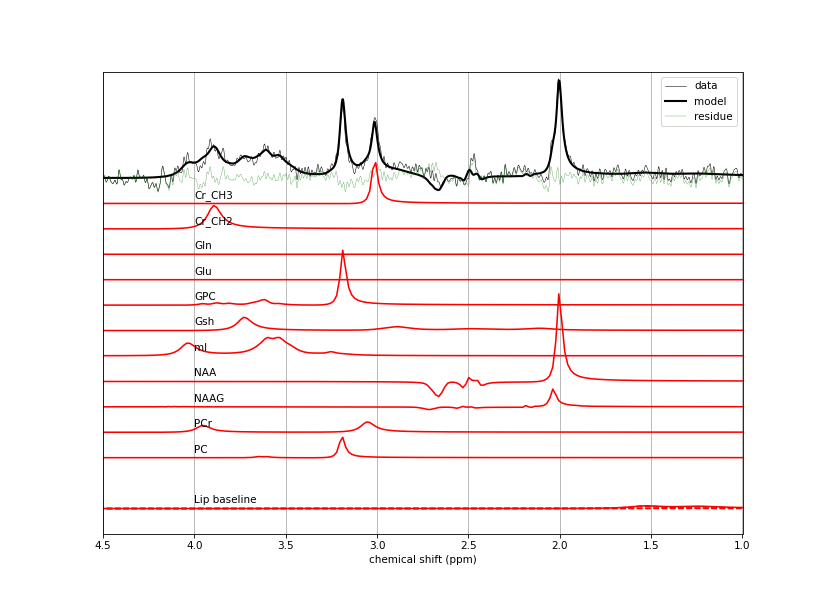

314_P2 R(t/f) = 0.73/0.72 FQN = 2.1


In [84]:
import mrs.fit as fit

this_df = df_sc_all_reco.loc[(df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")].drop_duplicates("patient_pass_id")

# preview
this_df = this_df.sort_values("fit_ws_optim_results_rsq_f", ascending=False).drop_duplicates("patient_pass_id")
this_df = this_df.head(5)

# best
this_df = this_df.loc[this_df["patient_pass_id"].isin(["314_P2"])]
print(this_df["patient_pass_id_pretty_after_filter"])

for this_index, this_row in this_df.iterrows():
    s_data = this_row["data_obj"]
    s_data = s_data.correct_peak_removal_1d(50, [4.5, 6], False)
    s_data = s_data.correct_peak_removal_1d(50, [0, 1.8], False)

    # fit params
    p_fit = this_row["final_fit_params_arr"]

    # PRESS seq
    seq = sim.mrs_seq_press(s_data.sequence.te, s_data.sequence.tr, s_data.sequence.na, 
                            s_data.sequence.ds, s_data.sequence.nuclei, 
                            s_data.sequence.npts, s_data.sequence.voxel_size, 
                            s_data.sequence.fs, s_data.sequence.f0)
    
    seq.bandpass_filter_range_ppm = [0, 4.2]

    seq.initialize()
    fig = plt.figure()
    ax = fig.subplots()
    fit.disp_fit(ax, s_data, p_fit, seq, True, True, None, False, [1, 4.5])
    print(this_row["patient_pass_id"] + " R(t/f) = %.2f/%.2f FQN = %.1f" % (this_row["fit_ws_optim_results_rsq_t"],
                                                                            this_row["fit_ws_optim_results_rsq_f"],
                                                                            this_row["fit_ws_optim_results_fqn"]))

fig = plt.gcf()
fig.savefig("./notebooks/figs/fig_fit.svg")

# P1 quantification results

## Automatic adjustment of SNR/LW/FQN thresholds

In [69]:
threshold_snr_final_list = [5, 6, 7, 8, 9, 10]
threshold_lw_final_list = [15, 20, 25]
threshold_fqn_final_list = [4, 5, 6, 7]

ref_strategy_full_sc = "sc|pastis|none|14|0.5|2groups"

this_df_reslist = []
k = 0
for this_snr in threshold_snr_final_list:
    for this_lw in threshold_lw_final_list:
        for this_fqn in threshold_fqn_final_list:

            df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                                    this_snr,
                                                    this_lw,
                                                    this_fqn,
                                                    ref_strategy_full_sc)

            df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                                    (df_sc_all_reco.index.get_level_values("strategy_reco") == "sc") &
                                    (df_sc_all_reco["strategy_full"] == ref_strategy_full_sc) &
                                    (df_sc_all_reco["pass"] == 1)]

            # watch ratios
            this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                             (df["param_val_err"] == "val") &  
                             (df["param_m_name"].isin(["tCr", "tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "GABA", "NAAG"]))]

            this_df["param_val"] = this_df["param_val"].replace([np.inf, -np.inf], np.nan)
            this_df = this_df[this_df["param_val"].notna()].reset_index()

            this_df = this_df.loc[(this_df["param_m_name"].isin(["tCho", "tNAA", "mI"]))]
            this_df_res = this_df.groupby(["param_m_name"])["param_val"].agg(["mean", "median", "std"])
            this_df_res["snr_threshold"] = this_snr
            this_df_res["lw_threshold"] = this_lw
            this_df_res["fqn_threshold"] = this_fqn
            this_df_reslist.append(this_df_res)

            k += 1
            print("%.2f%% done" % (100 * k / (len(threshold_snr_final_list) * len(threshold_lw_final_list) * len(threshold_fqn_final_list))))


found 3 orphan P2 patients. Fixing them...
['313', '314', '349']
n (P1) = 9 / 13 (69.23% included)
n (P2) = 2 / 7


/home/tangir/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.39% done
found 2 orphan P2 patients. Fixing them...
['313', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 3 / 7
2.78% done
found 2 orphan P2 patients. Fixing them...
['313', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 3 / 7
4.17% done
found 2 orphan P2 patients. Fixing them...
['313', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 3 / 7
5.56% done
found 2 orphan P2 patients. Fixing them...
['314', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 4 / 7
6.94% done
found 1 orphan P2 patients. Fixing them...
['349']
n (P1) = 11 / 13 (84.62% included)
n (P2) = 5 / 7
8.33% done
found 1 orphan P2 patients. Fixing them...
['349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 5 / 7
9.72% done
found 1 orphan P2 patients. Fixing them...
['349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 5 / 7
11.11% done
found 2 orphan P2 patients. Fixing them...
['314', '349']
n (P1) = 10 / 13 (76.92% included)
n (P2) = 4 / 7
12.50% done
found 1 orphan P2 patients. Fixing them...
['349']
n (P1

<IPython.core.display.Javascript object>


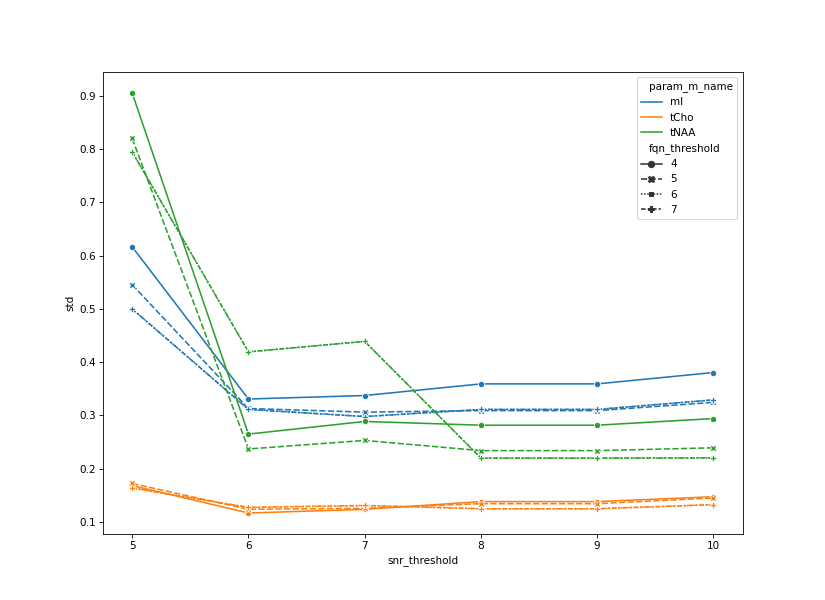

<IPython.core.display.Javascript object>


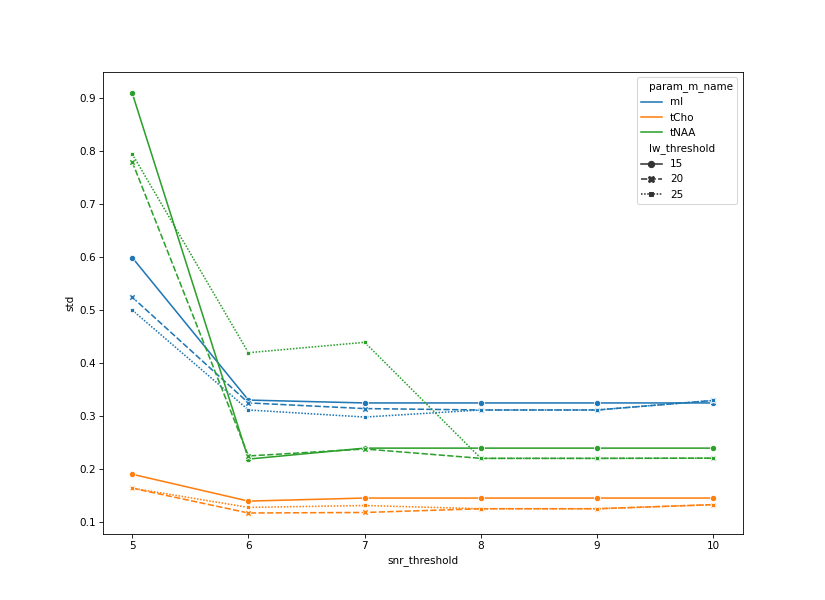

<IPython.core.display.Javascript object>

In [70]:
this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["lw_threshold"] == this_df_res_concat["lw_threshold"].max())]

plt.figure()
g = sns.lineplot(x="snr_threshold", y="std",
                hue="param_m_name",
                style="fqn_threshold", markers=True,
                data=this_df_res_concat)

this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["fqn_threshold"] == this_df_res_concat["fqn_threshold"].max())]

plt.figure()
g = sns.lineplot(x="snr_threshold", y="std",
                hue="param_m_name",
                style="lw_threshold", markers=True,
                data=this_df_res_concat)

this_df_res_concat = pd.concat(this_df_reslist).reset_index()
this_df_res_concat = this_df_res_concat.loc[(this_df_res_concat["snr_threshold"] == 8)]

plt.figure()
g = sns.lineplot(x="fqn_threshold", y="std",
                hue="param_m_name",
                style="lw_threshold", markers=True,
                data=this_df_res_concat)


## Final stats: Mean, Median, STDs, CRBs, pastis vs. LCModel, sc vs. sc_nodatarej

In [71]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 10

ref_strategy_full_sc = "sc|pastis|none|14|0.5|2groups"

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_strategy_full_sc)

df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) &
                        (df_sc_all_reco["strategy_full"].isin(["sc|lcmodel|none|1|nan|nan",
                                                               "sc_nodatarej|lcmodel|none|1|nan|nan",
                                                               "sc_nodatarej|pastis|none|14|0.5|2groups",
                                                               "sc|pastis|none|14|0.5|2groups"])) & 
                        (df_sc_all_reco["pass_after_filter"] == 1)]


found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 4 / 7


In [72]:
# watch SDs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "GABA", "Gln", "Glu", "Gsh", "Glx", "Asp"]))]

this_df = this_df[this_df["param_val"].notna()].reset_index()

this_df_grp_disp = this_df.sort_values("strategy_fit_constraint_type").groupby(["param_m_name", "strategy_full"])["param_val"].std()

pd.set_option('display.max_rows', 300)
this_df.groupby(["param_m_name", "strategy_full"])["param_val"].agg(["mean", "median", "std", "size"]).round(2)

mean  median   std  size
param_m_name strategy_full                                                    
Asp          sc_nodatarej|lcmodel|none|1|nan|nan      0.40    0.38  0.23    12
             sc|lcmodel|none|1|nan|nan                0.43    0.43  0.20    11
GABA         sc_nodatarej|lcmodel|none|1|nan|nan      0.19    0.15  0.10    12
             sc|lcmodel|none|1|nan|nan                0.19    0.18  0.11    12
Gln          sc_nodatarej|lcmodel|none|1|nan|nan      0.67    0.45  0.52    10
             sc_nodatarej|pastis|none|14|0.5|2groups  0.75    0.40  0.75     9
             sc|lcmodel|none|1|nan|nan                0.71    0.46  0.66    11
             sc|pastis|none|14|0.5|2groups            0.72    0.63  0.52     8
Glu          sc_nodatarej|lcmodel|none|1|nan|nan      0.44    0.21  0.40     5
             sc_nodatarej|pastis|none|14|0.5|2groups  0.69    0.39  0.96     8
             sc|lcmodel|none|1|nan|nan                0.60    0.46  0.65     7
             sc|pastis|none|14|0.5|2groups            0.55    0.50  0.52     9
Glx          sc_nodatarej|lcmodel|none|1|nan|nan      0.81    0.63  0.72    11
             sc_nodatarej|pastis|none|14|0.5|2groups  1.23    0.75  0.97    10
             sc|lcmodel|none|1|nan|nan                1.00    0.60  1.01    12
             sc|pastis|none|14|0.5|2groups            0.97    0.90  0.71    11
Gsh          sc_nodatarej|lcmodel|none|1|nan|nan      0.33    0.31  0.16    11
             sc_nodatarej|pastis|none|14|0.5|2groups  0.34    0.28  0.32    12
             sc|lcmodel|none|1|nan|nan                0.39    0.29  0.31    10
             sc|pastis|none|14|0.5|2groups            0.38    0.27  0.29     9
Tau          sc_nodatarej|lcmodel|none|1|nan|nan      0.81    0.81  0.81     2
             sc|lcmodel|none|1|nan|nan                0.67    0.57  0.57     4
mI           sc_nodatarej|lcmodel|none|1|nan|nan      0.97    1.08  0.47    12
             sc_nodatarej|pastis|none|14|0.5|2groups  1.25    1.28  0.48    12
             sc|lcmodel|none|1|nan|nan                0.88    1.07  0.56    12
             sc|pastis|none|14|0.5|2groups            1.18    1.10  0.31    12
tCho         sc_nodatarej|lcmodel|none|1|nan|nan      0.34    0.34  0.15    12
             sc_nodatarej|pastis|none|14|0.5|2groups  0.38    0.32  0.19    12
             sc|lcmodel|none|1|nan|nan                0.33    0.35  0.15    12
             sc|pastis|none|14|0.5|2groups            0.35    0.34  0.11    12
tNAA         sc_nodatarej|lcmodel|none|1|nan|nan      1.68    1.59  0.61    12
             sc_nodatarej|pastis|none|14|0.5|2groups  1.27    1.22  0.46    12
             sc|lcmodel|none|1|nan|nan                1.62    1.57  0.53    12
             sc|pastis|none|14|0.5|2groups            1.21    1.17  0.22    12

In [73]:
# all metabolites averaged
this_df_mean = this_df.loc[(this_df["param_m_name"].isin(["tCho", "tNAA", "mI"]))]
this_df_mean.groupby(["strategy_full"])["param_val"].agg(["mean", "median", "std", "size"]).sort_values("mean")

mean    median       std  size
strategy_full                                                              
sc|pastis|none|14|0.5|2groups            0.911331  0.976238  0.459491    36
sc|lcmodel|none|1|nan|nan                0.945442  1.012933  0.693528    36
sc_nodatarej|pastis|none|14|0.5|2groups  0.965211  0.970416  0.569378    36
sc_nodatarej|lcmodel|none|1|nan|nan      0.998126  0.947075  0.706469    36

<IPython.core.display.Javascript object>


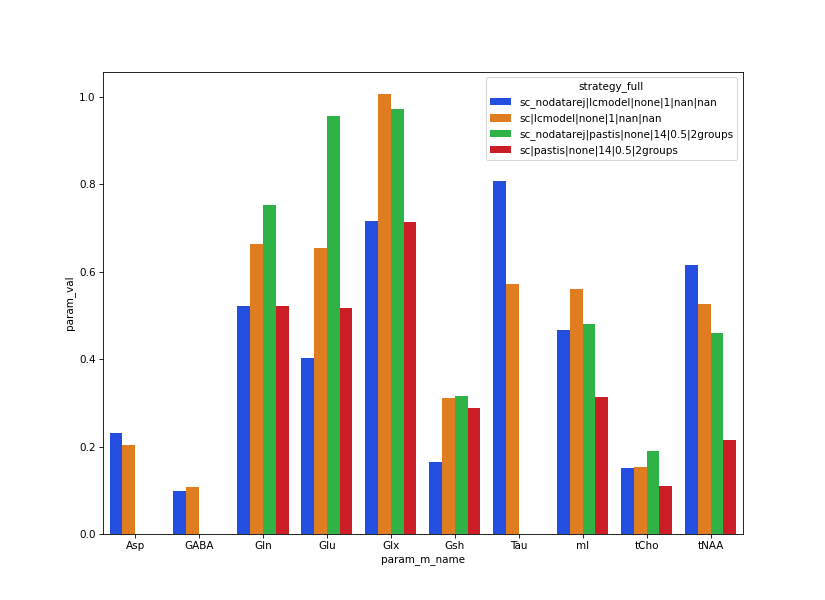

In [74]:
plt.figure()
g = sns.barplot(x="param_m_name",
                y="param_val",
                hue="strategy_full",
                palette = "bright",
                data=this_df_grp_disp.reset_index())

In [75]:
# watch CRBs
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "err_prct") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh", "Glx", "Asp"]))]

this_df = this_df[this_df["param_val"].notna()].reset_index()

this_df_grp_disp = this_df.groupby(["param_m_name", "strategy_full"])["param_val"].mean()

this_df.groupby(["param_m_name", "strategy_full"])["param_val"].agg(["mean", "median", "size"]).round(2)

mean  median  size
param_m_name strategy_full                                                
Asp          sc_nodatarej|lcmodel|none|1|nan|nan      104.99   54.74    12
             sc|lcmodel|none|1|nan|nan                 61.60   60.25    11
Gln          sc_nodatarej|lcmodel|none|1|nan|nan       66.59   65.33    10
             sc_nodatarej|pastis|none|14|0.5|2groups  170.18   52.99     9
             sc|lcmodel|none|1|nan|nan                120.68   68.22    11
             sc|pastis|none|14|0.5|2groups             60.01   51.42     8
Glu          sc_nodatarej|lcmodel|none|1|nan|nan      170.13  126.40     5
             sc_nodatarej|pastis|none|14|0.5|2groups  543.71   47.53     8
             sc|lcmodel|none|1|nan|nan                176.07  125.19     7
             sc|pastis|none|14|0.5|2groups            114.70   65.63     9
Glx          sc_nodatarej|lcmodel|none|1|nan|nan       72.40   68.08    11
             sc_nodatarej|pastis|none|14|0.5|2groups   51.30   50.75    10
             sc|lcmodel|none|1|nan|nan                 97.01   68.70    12
             sc|pastis|none|14|0.5|2groups             87.38   54.67    11
Gsh          sc_nodatarej|lcmodel|none|1|nan|nan       46.39   39.22    11
             sc_nodatarej|pastis|none|14|0.5|2groups  575.42   20.63    12
             sc|lcmodel|none|1|nan|nan                 68.47   38.41    10
             sc|pastis|none|14|0.5|2groups             38.03   29.24     9
Tau          sc_nodatarej|lcmodel|none|1|nan|nan       81.17   81.17     2
             sc|lcmodel|none|1|nan|nan                163.16  155.94     4
mI           sc_nodatarej|lcmodel|none|1|nan|nan       37.34   32.90    12
             sc_nodatarej|pastis|none|14|0.5|2groups   28.91   16.24    12
             sc|lcmodel|none|1|nan|nan                118.92   33.53    12
             sc|pastis|none|14|0.5|2groups             35.72   24.18    12
tCho         sc_nodatarej|lcmodel|none|1|nan|nan       25.41   21.93    12
             sc_nodatarej|pastis|none|14|0.5|2groups   47.44   39.75    12
             sc|lcmodel|none|1|nan|nan                 29.94   24.63    12
             sc|pastis|none|14|0.5|2groups             45.55   37.63    12
tNAA         sc_nodatarej|lcmodel|none|1|nan|nan       26.10   19.75    12
             sc_nodatarej|pastis|none|14|0.5|2groups   30.41   15.57    12
             sc|lcmodel|none|1|nan|nan                 24.81   19.50    12
             sc|pastis|none|14|0.5|2groups             36.64   27.18    12

In [76]:
# all metabolites averaged
this_df_mean = this_df.loc[(this_df["param_m_name"].isin(["tCho", "tNAA", "mI"]))]
this_df_mean.groupby(["strategy_full"])["param_val"].agg(["mean", "median", "std", "size"]).sort_values("median")

mean     median         std  \
strategy_full                                                               
sc_nodatarej|pastis|none|14|0.5|2groups  35.587337  25.808370   32.826149   
sc|lcmodel|none|1|nan|nan                57.890190  26.454826  162.598409   
sc|pastis|none|14|0.5|2groups            39.303748  29.146254   37.028028   
sc_nodatarej|lcmodel|none|1|nan|nan      29.619774  29.609324   15.113242   

                                         size  
strategy_full                                  
sc_nodatarej|pastis|none|14|0.5|2groups    36  
sc|lcmodel|none|1|nan|nan                  36  
sc|pastis|none|14|0.5|2groups              36  
sc_nodatarej|lcmodel|none|1|nan|nan        36

<IPython.core.display.Javascript object>


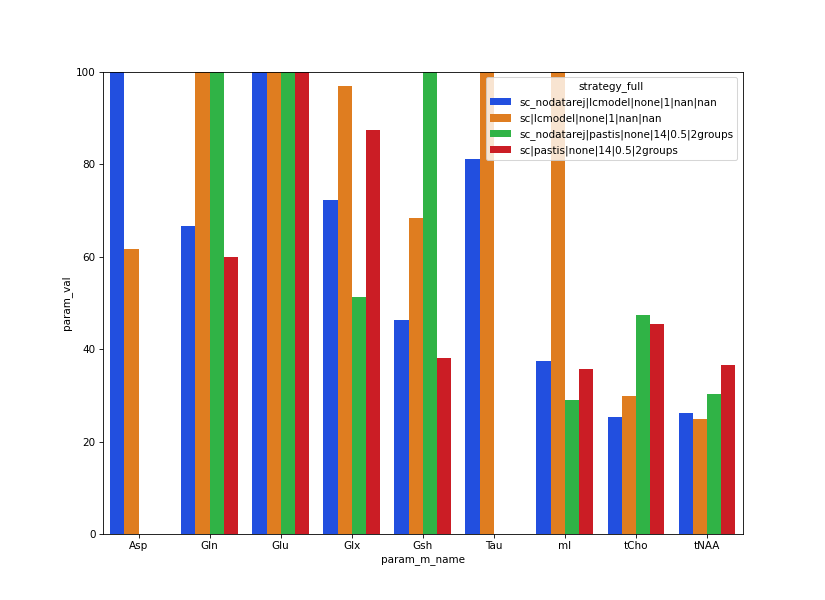

(0.0, 100.0)

In [77]:
plt.figure()
g = sns.barplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full",
                palette = "bright",
                data=this_df_grp_disp.reset_index())

plt.ylim([0, 100])

## PASTIS vs. LCModel: t-tests  

In [78]:
from scipy.stats import ttest_ind

for m in ["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh"]:

    this_df_pastis = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] == m) &  
                     (df["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

    this_df_pastis = this_df_pastis[this_df_pastis["param_val"].notna()].reset_index()
    
    this_df_lcmodel = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                     (df["param_val_err"] == "val") &  
                     (df["param_m_name"] == m) &  
                     (df["strategy_full"] == "sc|lcmodel|none|1|nan|nan")]

    this_df_lcmodel = this_df_lcmodel[this_df_lcmodel["param_val"].notna()].reset_index()
    
    stats, pval = ttest_ind(this_df_pastis["param_val"], this_df_lcmodel["param_val"])

    print("PASTIS vs. LCM [%s] p = %.2f" % (m, pval))


PASTIS vs. LCM [tCho] p = 0.74
PASTIS vs. LCM [tNAA] p = 0.02
PASTIS vs. LCM [mI] p = 0.12
PASTIS vs. LCM [Tau] p = nan
PASTIS vs. LCM [Gln] p = 0.97
PASTIS vs. LCM [Glu] p = 0.87
PASTIS vs. LCM [Gsh] p = 0.92


# P1 vs. P2 quantification results

In [79]:
threshold_snr_final = 6
threshold_lw_final = 20
threshold_fqn_final = 10

ref_strategy_full_sc = "sc|pastis|none|14|0.5|2groups"

df_sc_all_reco = filter_by_SNR_LW_FQN(df_sc_all_reco, 
                                        threshold_snr_final,
                                        threshold_lw_final,
                                        threshold_fqn_final,
                                        ref_strategy_full_sc)

df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) &
                        (df_sc_all_reco["strategy_full"].isin(["sc|lcmodel|none|1|nan|nan",
                                                               "sc_nodatarej|lcmodel|none|1|nan|nan",
                                                               "sc_nodatarej|pastis|none|14|0.5|2groups",
                                                               "sc|pastis|none|14|0.5|2groups"])) 
                       ]

# watch ratios
this_df = df.loc[(df["param_p_type"] == "fit_ws_params_fit_t2cor_ratio_cm") &
                 (df["param_val_err"] == "val") &  
                 (df["param_m_name"].isin(["tCho", "tNAA", "mI", "Tau", "Gln", "Glu", "Gsh", "Glx", "Asp"]))]

# keep only patients that has P1 and P2
# find pass 1 patients
this_df_p1 = this_df.loc[(this_df["pass_after_filter"] == 1)]
# remember them
patient_id_p1_list = this_df_p1["patient_id"].unique().tolist()
# find pass 2 patients which are in previously found pass 1 list
patient_id_p1p2_list = this_df.loc[ (this_df["pass_after_filter"] == 2) &
                            this_df["patient_id"].isin(patient_id_p1_list) ]["patient_id"].unique().tolist()
# select those p1p2 patients
this_df_p1p2 = this_df.loc[ this_df["patient_id"].isin(patient_id_p1p2_list) ]

this_df_p1p2 = this_df_p1p2[this_df_p1p2["param_val"].notna()]
this_df_p1p2[["patient_id", "pass_after_filter", 'param_val']]
this_df_p1p2_grp_disp = this_df_p1p2.groupby(["param_m_name", "strategy_full", "patient_id"])["param_val"].std() / this_df_p1p2.groupby(["param_m_name", "strategy_full", "patient_id"])["param_val"].mean() * 100.0
this_df_p1p2_grp_disp.groupby(["param_m_name", "strategy_full"]).agg(["mean", "median", "std", "size"]).round(2)

found 2 orphan P2 patients. Fixing them...
['336', '349']
n (P1) = 12 / 13 (92.31% included)
n (P2) = 4 / 7


mean  median    std  \
param_m_name strategy_full                                                    
Asp          sc_nodatarej|lcmodel|none|1|nan|nan       47.54   23.64  61.45   
             sc|lcmodel|none|1|nan|nan                 52.42   36.69  60.06   
Gln          sc_nodatarej|lcmodel|none|1|nan|nan       22.03   20.15   8.87   
             sc_nodatarej|pastis|none|14|0.5|2groups   89.17   89.17  72.88   
             sc|lcmodel|none|1|nan|nan                 41.20   22.72  46.23   
             sc|pastis|none|14|0.5|2groups            140.48  140.48    NaN   
Glu          sc_nodatarej|lcmodel|none|1|nan|nan      117.70  117.70    NaN   
             sc_nodatarej|pastis|none|14|0.5|2groups   78.81   78.81   1.18   
             sc|lcmodel|none|1|nan|nan                122.75  122.75    NaN   
             sc|pastis|none|14|0.5|2groups             91.66   73.99  42.54   
Glx          sc_nodatarej|lcmodel|none|1|nan|nan       45.96   43.95  34.47   
             sc_nodatarej|pastis|none|14|0.5|2groups   83.73   80.41  42.04   
             sc|lcmodel|none|1|nan|nan                 60.36   71.96  35.34   
             sc|pastis|none|14|0.5|2groups             92.06   94.27  44.77   
Gsh          sc_nodatarej|lcmodel|none|1|nan|nan       41.82   22.30  38.37   
             sc_nodatarej|pastis|none|14|0.5|2groups   35.71   39.29   7.62   
             sc|lcmodel|none|1|nan|nan                 54.21   49.94  46.10   
             sc|pastis|none|14|0.5|2groups             29.56   23.70  28.55   
Tau          sc_nodatarej|lcmodel|none|1|nan|nan       72.62   72.62    NaN   
             sc|lcmodel|none|1|nan|nan                 74.99   74.99    NaN   
mI           sc_nodatarej|lcmodel|none|1|nan|nan       34.70   38.69  13.43   
             sc_nodatarej|pastis|none|14|0.5|2groups   18.48   12.40  16.76   
             sc|lcmodel|none|1|nan|nan                 36.04   40.33  17.86   
             sc|pastis|none|14|0.5|2groups             21.88   22.03  14.63   
tCho         sc_nodatarej|lcmodel|none|1|nan|nan       17.10   11.61  18.92   
             sc_nodatarej|pastis|none|14|0.5|2groups   15.33   17.23   5.28   
             sc|lcmodel|none|1|nan|nan                 25.19   22.50  14.64   
             sc|pastis|none|14|0.5|2groups             13.21   13.49   8.60   
tNAA         sc_nodatarej|lcmodel|none|1|nan|nan        9.62    9.68   3.08   
             sc_nodatarej|pastis|none|14|0.5|2groups   11.81   13.73   8.38   
             sc|lcmodel|none|1|nan|nan                  8.01    8.82   3.42   
             sc|pastis|none|14|0.5|2groups             10.24   10.29   3.84   

                                                      size  
param_m_name strategy_full                                  
Asp          sc_nodatarej|lcmodel|none|1|nan|nan         4  
             sc|lcmodel|none|1|nan|nan                   4  
Gln          sc_nodatarej|lcmodel|none|1|nan|nan         4  
             sc_nodatarej|pastis|none|14|0.5|2groups     4  
             sc|lcmodel|none|1|nan|nan                   4  
             sc|pastis|none|14|0.5|2groups               3  
Glu          sc_nodatarej|lcmodel|none|1|nan|nan         2  
             sc_nodatarej|pastis|none|14|0.5|2groups     4  
             sc|lcmodel|none|1|nan|nan                   3  
             sc|pastis|none|14|0.5|2groups               4  
Glx          sc_nodatarej|lcmodel|none|1|nan|nan         4  
             sc_nodatarej|pastis|none|14|0.5|2groups     4  
             sc|lcmodel|none|1|nan|nan                   4  
             sc|pastis|none|14|0.5|2groups               4  
Gsh          sc_nodatarej|lcmodel|none|1|nan|nan         4  
             sc_nodatarej|pastis|none|14|0.5|2groups     4  
             sc|lcmodel|none|1|nan|nan                   4  
             sc|pastis|none|14|0.5|2groups               3  
Tau          sc_nodatarej|lcmodel|none|1|nan|nan         2  
             sc|lcmodel|none|1|nan|nan                   2  
mI           sc_nodatarej|l

In [80]:
# all metabolites averaged
this_df_mean = this_df_p1p2.loc[(this_df_p1p2["param_m_name"].isin(["tCho", "tNAA", "mI"]))]
this_df_mean = this_df_mean.groupby(["param_m_name", "strategy_full", "patient_id"])["param_val"].std() / this_df_mean.groupby(["param_m_name", "strategy_full", "patient_id"])["param_val"].mean() * 100.0
this_df_mean.groupby(["strategy_full"]).agg(["mean", "median", "std", "size"]).sort_values("median")

mean     median        std  size
strategy_full                                                                 
sc_nodatarej|lcmodel|none|1|nan|nan      20.473625  13.225694  16.430256    12
sc|pastis|none|14|0.5|2groups            15.107254  13.255958  10.448879    12
sc_nodatarej|pastis|none|14|0.5|2groups  15.206600  13.725633  10.557738    12
sc|lcmodel|none|1|nan|nan                23.078604  15.398905  17.142516    12

In [81]:
g = sns.catplot(x="param_m_name", 
                y="param_val",
                hue="strategy_full", kind="bar", ci=None,
                palette = "bright",
                data=this_df_p1p2_grp_disp.reset_index())

plt.ylim([0, 50])

<IPython.core.display.Javascript object>

(0.0, 50.0)

# Special results for reviewers
## Residual water LW vs. metabolite LW

<IPython.core.display.Javascript object>


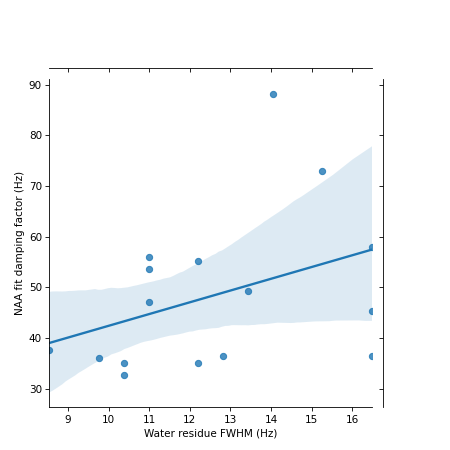

R = 0.38


<IPython.core.display.Javascript object>

R = 0.38


<IPython.core.display.Javascript object>

R = 0.38


<IPython.core.display.Javascript object>


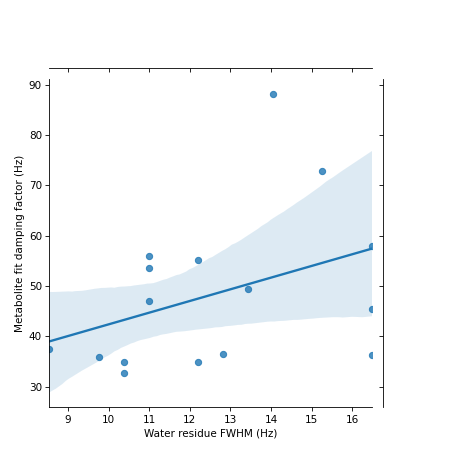

R = 0.38


<IPython.core.display.Javascript object>


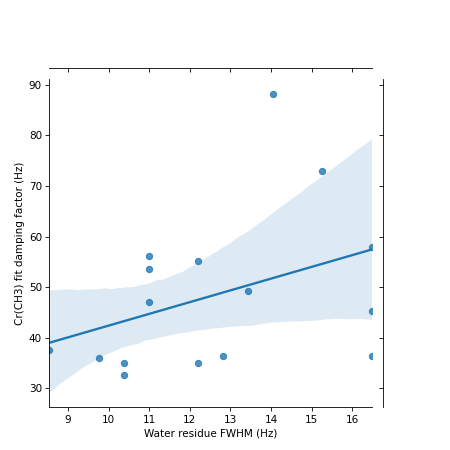

R = 0.38


<IPython.core.display.Javascript object>

R = 0.41


In [82]:
df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

df = df.drop_duplicates("patient_pass_id")

df["NAA fit damping factor (Hz)"] = [p_fit[xxx.m_NAA, xxx.p_dd] for p_fit in df["final_fit_params_arr"]]
df["GPC fit damping factor (Hz)"] = [p_fit[xxx.m_GPC, xxx.p_dd] for p_fit in df["final_fit_params_arr"]]
df["PC fit damping factor (Hz)"] = [p_fit[xxx.m_PC, xxx.p_dd] for p_fit in df["final_fit_params_arr"]]
df["Cr(CH3) fit damping factor (Hz)"] = [p_fit[xxx.m_Cr_CH3, xxx.p_dd] for p_fit in df["final_fit_params_arr"]]
df["Metabolite fit damping factor (Hz)"] = [float(np.mean(p_fit[[xxx.m_Cr_CH3, 
                                                     xxx.m_NAA,
                                                     xxx.m_GPC,
                                                     xxx.m_PC], xxx.p_dd])) for p_fit in df["final_fit_params_arr"]]

df["Water residue FWHM (Hz)"] = df["lw_final"]
df["noWS water FWHM (Hz)"] = df["lw_ref_final"]

x = df["Water residue FWHM (Hz)"]
y = df["NAA fit damping factor (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))

x = df["Water residue FWHM (Hz)"]
y = df["GPC fit damping factor (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))

x = df["Water residue FWHM (Hz)"]
y = df["PC fit damping factor (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))

x = df["Water residue FWHM (Hz)"]
y = df["Metabolite fit damping factor (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))
fig = plt.gcf()
fig.savefig("./notebooks/figs/fig_r1.3.svg")

x = df["Water residue FWHM (Hz)"]
y = df["Cr(CH3) fit damping factor (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))

x = df["Water residue FWHM (Hz)"]
y = df["noWS water FWHM (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))

removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER R:N=25:1 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 14.65 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 resp trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 23.19 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 17.70 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 36.62 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 23.19 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER 5:5 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 37.23 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER 10:2 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 22.58 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 18.31 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 28.08 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 WS [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 14.65 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 11.60 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 22.58 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 10/2 NA=64 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 37.23 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 27.47 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 13.43 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 10/2 NA=128 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 19.53 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER R:N=25:1 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 21.36 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 resp trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 15.26 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 18.31 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 26.86 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 23.19 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER 5:5 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 24.41 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#1 sLASER 10:2 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 31.74 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 21.97 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 25.02 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20:1 WS [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 16.48 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 15.87 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 14.65 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 10/2 NA=64 trig [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 22.58 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 14.04 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 20/1 NA=128 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 18.92 Hz!


removing peak(s) with HSVD: ██████████████████████████████ done.


(INFO)  MRSData2.analyze_linewidth_1d: results for [#0 sLASER 10/2 NA=128 [RAW]] coming...
(INFO)  MRSData2.analyze_linewidth_1d: LW = 18.31 Hz!


<IPython.core.display.Javascript object>

R = 0.56


<IPython.core.display.Javascript object>


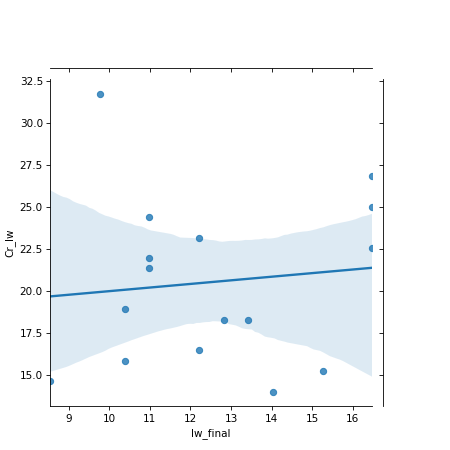

R = 0.11


In [83]:
df = df_sc_all_reco.loc[(df_sc_all_reco["included"]) & 
                        (df_sc_all_reco["strategy_full"] == "sc|pastis|none|14|0.5|2groups")]

df = df.drop_duplicates("patient_pass_id")

# estimate NAA linewidth for each dataset
df["NAA(2.01ppm) FWHM (Hz)"] = np.array([o.correct_peak_removal_1d(100, [0, 1.7], display=False).analyze_linewidth_1d([1.8, 2.2], False, False) for o in df["data_obj"]])
df["Cr_lw"] = np.array([o.correct_peak_removal_1d(100, [0, 1.7], display=False).analyze_linewidth_1d([2.9, 3.1], False, False) for o in df["data_obj"]])
df["Water residue FWHM (Hz)"] = df["lw_final"]

x = df["Water residue FWHM (Hz)"]
y = df["NAA(2.01ppm) FWHM (Hz)"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))
fig = plt.gcf()
fig.savefig("./notebooks/figs/fig_r1.3_another.svg")

x = df["lw_final"]
y = df["Cr_lw"]
g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.regplot)
print("R = %.2f" % x.corr(y))
